# Contrastive Activation Addition

This notebook aims to reproduce the workflow defined in [Contrastive Activation Addition](https://arxiv.org/abs/2312.06681) for extracting steering vectors from input. The official codebase can be found [here](https://github.com/nrimsky/CAA).

<a target="_blank" href="https://colab.research.google.com/github/steering-vectors/steering-vectors/blob/main/examples/caa_sycophancy.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**A note for Colab users**:
- We load models in 8-bit inference.
- Thus, Llama-7b will require 7GB of VRAM and Llama-13B will require 13GB of VRAM, plus some overhead for computing activations in the forward pass.
- Ensure your GPU instance (if running on GPU) has sufficient VRAM before proceeding.
- The standard T4 GPU available with Google Colab (free tier) will be able to support 7b but not 13b.

## Install Dependencies

In [1]:
!pip install --quiet steering-vectors
!pip install --quiet torch
# For loading in 8-bit precision
!pip install --quiet accelerate
!pip install --quiet bitsandbytes
!pip install --quiet ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.4 MB/s eta 0:00:00


## Set up Model

To be consistent with CAA, we run on Llama-2 chat models of sizes 7b and 13b. These can be downloaded through Huggingface Transformers but require you to have first applied for access [here](https://ai.meta.com/resources/models-and-libraries/llama-downloads/)


In [ ]:
!pip install --quiet steering-vectors
!pip install --quiet torch
# For loading in 8-bit precision
!pip install --quiet accelerate
!pip install --quiet bitsandbytes
!pip install --quiet ipywidgets
import huggingface_hub

huggingface_hub.notebook_login()

In [ ]:

!pip install --quiet steering-vectors
!pip install --quiet torch
# For loading in 8-bit precision
!pip install --quiet accelerate
!pip install --quiet bitsandbytes
!pip install --quiet ipywidgets
import huggingface_hub

huggingface_hub.notebook_login()
from transformers import AutoModelForCausalLM, AutoTokenizer


def get_model_and_tokenizer(model_name: str):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # Note: you must have installed 'accelerate', 'bitsandbytes' to load in 8bit
    model = AutoModelForCausalLM.from_pretrained(model_name, load_in_8bit=True)
    return model, tokenizer

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from steering_vectors import (
    train_steering_vector,
    SteeringVectorTrainingSample,
    record_activations,
    mean_aggregator,
    pca_aggregator,
    # Assuming logistic_aggregator is available from the library:
    logistic_aggregator,
    addition_operator,
    guess_and_enhance_layer_config
)
from typing import List, Dict, Tuple, Optional # Added for better type hinting

class SteeringVectorExperiment:
    """
    Systematic implementation of steering vector methodology following
    established protocols for transformer model intervention research.
    """

    def __init__(self, model_identifier: str, layer_type: str = "mlp", attn_implementation: Optional[str] = None): # Added layer_type and attn_implementation
        """
        Initialize experimental framework with specified model architecture.

        Args:
            model_identifier: HuggingFace model identifier for reproducibility
            layer_type: Type of layer to target (e.g., "mlp", "self_attn"). Default: "mlp".
            attn_implementation: Optional attention implementation (e.g., "eager", "sdpa", "flash_attention_2").
        """
        self.model_identifier = model_identifier
        self.layer_type = layer_type # Store layer_type
        print(f"Initializing experiment with model: {model_identifier}, layer_type: {layer_type}")

        model_load_args = {
            "torch_dtype": torch.float16,
            "device_map": "auto"
        }
        if attn_implementation:
            model_load_args["attn_implementation"] = attn_implementation
            print(f"Using attention implementation: {attn_implementation}")

        try:
            self.model = AutoModelForCausalLM.from_pretrained(
                model_identifier,
                **model_load_args
            )
            self.tokenizer = AutoTokenizer.from_pretrained(model_identifier)
        except Exception as e:
            print(f"Error loading model or tokenizer '{model_identifier}': {e}")
            raise

        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        print(f"Guessing layer configuration for layer_type='{self.layer_type}'...")
        self.layer_config = guess_and_enhance_layer_config(
            model=self.model,
            layer_type=self.layer_type # Use the provided layer_type
        )
        if not self.layer_config:
             print(f"Warning: guess_and_enhance_layer_config returned empty for layer_type='{self.layer_type}'. Manual configuration might be needed.")
        else:
            print(f"Layer config identified: {self.layer_config}")


    def conduct_activation_analysis(self, probe_texts: list[str], target_layers: list[int]) -> Dict[int, List[torch.Tensor]]:
        """
        Systematic activation recording for mechanistic interpretability analysis.
        (Docstring remains the same)
        """
        tokenized_inputs = self.tokenizer(
            probe_texts, return_tensors="pt", padding=True, truncation=True, max_length=512
        )
        with record_activations(
            model=self.model,
            layer_type=self.layer_type, # Use self.layer_type
            layer_config=self.layer_config,
            layer_nums=target_layers,
            clone_activations=True
        ) as activation_records:
            with torch.no_grad():
                _ = self.model(**tokenized_inputs.to(self.model.device))
        return activation_records

    def train_concept_vector(
        self,
        concept_identifier: str,
        positive_exemplars: list[str],
        negative_exemplars: list[str],
        target_layers: Optional[list[int]] = None, # Use Optional
        aggregation_method: str = "mean"
    ): # Return type can be specified if SteeringVector type is known/imported
        """
        Systematic training of steering vectors utilizing contrastive methodology.
        (Docstring remains the same)
        """
        if target_layers is None:
            target_layers = list(range(self.model.config.num_hidden_layers))

        training_samples = [
            SteeringVectorTrainingSample(positive_str=pos_text, negative_str=neg_text)
            for pos_text, neg_text in zip(positive_exemplars, negative_exemplars)
        ]

        aggregator_mapping = {
            "mean": mean_aggregator(),
            "pca": pca_aggregator(),
            "logistic": logistic_aggregator() # Assuming this is correctly imported
        }
        selected_aggregator = aggregator_mapping.get(aggregation_method)
        if selected_aggregator is None:
            print(f"Warning: Aggregation method '{aggregation_method}' not found. Defaulting to 'mean'.")
            selected_aggregator = mean_aggregator()

        steering_vector = train_steering_vector(
            model=self.model,
            tokenizer=self.tokenizer,
            training_samples=training_samples,
            layers=target_layers,
            layer_type=self.layer_type, # Use self.layer_type
            layer_config=self.layer_config,
            aggregator=selected_aggregator,
            read_token_index=-1,
            show_progress=True,
            batch_size=4
        )
        print(f"Successfully trained '{concept_identifier}' steering vector for layer_type '{self.layer_type}'")
        if hasattr(steering_vector, 'layer_activations') and steering_vector.layer_activations is not None:
            print(f"Vector dimensionality: {len(steering_vector.layer_activations)} layers")
        else:
            print("Steering vector layer_activations not found or empty.")
        return steering_vector

    def execute_controlled_generation(
        self,
        steering_vector, # Specify type if known
        prompt_text: str,
        intervention_strength: float = 1.0,
        generation_parameters: Optional[dict] = None # Use Optional
    ) -> Tuple[str, str]:
        """
        Systematic text generation with steering vector intervention.
        (Docstring remains the same)
        """
        if generation_parameters is None:
            generation_parameters = {
                "max_new_tokens": 50, "do_sample": True, "temperature": 0.7,
                "top_p": 0.9, "pad_token_id": self.tokenizer.pad_token_id
            }
        inputs = self.tokenizer(prompt_text, return_tensors="pt")
        inputs = {k: v.to(self.model.device) for k, v in inputs.items()}

        with torch.no_grad():
            control_outputs = self.model.generate(**inputs, **generation_parameters)
            control_text = self.tokenizer.decode(control_outputs[0], skip_special_tokens=True)

        # Ensure layer_config used for applying matches the one used for training (via self.layer_type)
        with steering_vector.apply(
            model=self.model,
            layer_config=self.layer_config, # This layer_config was derived from self.layer_type
            operator=addition_operator(),
            multiplier=intervention_strength
        ):
            with torch.no_grad():
                steered_outputs = self.model.generate(**inputs, **generation_parameters)
                steered_text = self.tokenizer.decode(steered_outputs[0], skip_special_tokens=True)
        return control_text, steered_text

    def conduct_systematic_evaluation(
        self,
        concept_name: str,
        positive_exemplars: list[str],
        negative_exemplars: list[str],
        evaluation_prompts: list[str],
        intervention_strengths: list[float] = [0.5, 1.0, 2.0]
    ):
        """
        Comprehensive evaluation protocol for steering vector effectiveness.
        (Docstring remains the same)
        """
        print(f"\n=== Systematic Evaluation: {concept_name} Concept (Layer Type: {self.layer_type}) ===")
        print("Stage 1: Training steering vector...")
        steering_vector = self.train_concept_vector(
            concept_identifier=concept_name,
            positive_exemplars=positive_exemplars,
            negative_exemplars=negative_exemplars
            # `target_layers` and `aggregation_method` use defaults or can be passed here
        )
        if not steering_vector:
            print("Failed to train steering vector. Aborting evaluation.")
            return

        print("Stage 2: Conducting dose-response analysis...")
        for strength in intervention_strengths:
            print(f"\n--- Intervention Strength: {strength} ---")
            for i, prompt in enumerate(evaluation_prompts):
                control, steered = self.execute_controlled_generation(
                    steering_vector=steering_vector,
                    prompt_text=prompt,
                    intervention_strength=strength
                )
                print(f"Prompt {i+1}: {prompt}")
                print(f"Control: {control}")
                print(f"Steered: {steered}")
                print("-" * 50)

if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser(description="Run Steering Vector Experiments.")
    parser.add_argument(
        "--model_id",
        type=str,
        default="meta-llama/Llama-3.2-1B-Instruct",
        help="HuggingFace model identifier."
    )
    parser.add_argument(
        "--layer_type",
        type=str,
        default="mlp",
        choices=["mlp", "self_attn"], # Add more if supported by steering_vectors and your use case
        help="Type of layer to target for steering vectors (e.g., 'mlp', 'self_attn')."
    )
    parser.add_argument(
        "--attn_implementation",
        type=str,
        default=None,
        choices=["eager", "sdpa", "flash_attention_2"],
        help="Optional: Attention implementation for the model."
    )
    args = parser.parse_args()

    # Initialize experimental framework
    try:
        experiment = SteeringVectorExperiment(
            model_identifier=args.model_id,
            layer_type=args.layer_type,
            attn_implementation=args.attn_implementation
        )
    except Exception as e:
        print(f"Failed to initialize experiment: {e}")
        exit(1)

    # Define experimental conditions
    positive_exemplars = [
        "I feel incredibly optimistic about today's possibilities.",
        "This is such a wonderful and uplifting experience.",
        "Everything is going amazingly well, I'm so grateful.",
        "What a fantastic opportunity to learn and grow!"
    ]
    negative_exemplars = [
        "I feel deeply pessimistic about today's challenges.",
        "This is such a terrible and depressing experience.",
        "Everything is going terribly wrong, I'm so frustrated.",
        "What a dreadful situation with no hope for improvement."
    ]
    evaluation_prompts = [
        "The weather today is",
        "Looking at the current situation, I think",
        "My feelings about this project are"
    ]

    # Execute systematic evaluation protocol
    experiment.conduct_systematic_evaluation(
        concept_name="emotional_valence",
        positive_exemplars=positive_exemplars,
        negative_exemplars=negative_exemplars,
        evaluation_prompts=evaluation_prompts
    )

usage: colab_kernel_launcher.py [-h] [--model_id MODEL_ID]
                                [--layer_type {mlp,self_attn}]
                                [--attn_implementation {eager,sdpa,flash_attention_2}]
colab_kernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-3fb61182-e49c-4ae0-a6e5-2c10f7244cac.json


SystemExit: 2

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:

!pip install --quiet steering-vectors
!pip install --quiet torch
# For loading in 8-bit precision
!pip install --quiet accelerate
!pip install --quiet bitsandbytes
!pip install --quiet ipywidgets
import huggingface_hub

huggingface_hub.notebook_login()
from transformers import AutoModelForCausalLM, AutoTokenizer


def get_model_and_tokenizer(model_name: str):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # Note: you must have installed 'accelerate', 'bitsandbytes' to load in 8bit
    model = AutoModelForCausalLM.from_pretrained(model_name, load_in_8bit=True)
    return model, tokenizer

model_size = "13b"  # or "7b"
model_name = f"meta-llama/Llama-2-{model_size}-chat-hf"
model, tokenizer = get_model_and_tokenizer(model_name)


import json
import random

# Define a shorthand type for model-written eval datum
MWEData = list[dict[str, str]]
#LOAD AND DEFINE DATA, THIS SI JUST AN EXAMPLE USING A JSON BUT WE SHOUDL IMPLEMENT A HUGGINGFACE DATASETS ADAPTER AND DATA TRANSFOMER ALSO
train_data: list[Data] = json.load(open("generate_dataset.json"))
test_data: list[Data] = json.load(open("test_dataset_ab.json"))

random.seed(42)
random.shuffle(train_data)
random.shuffle(test_data)
train_data = train_data
test_data = test_data

B_INST = "[INST]"
E_INST = "[/INST]"
SYS_PROMPT = "You are a helpful, honest assistant."
B_SYS = "<<SYS>>"
E_SYS = "<</SYS>>"
BOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"
# Note: No EOS token is used in original codebase
prompt_template = f"{BOS_TOKEN} {B_INST} \n{B_SYS}{SYS_PROMPT}{E_SYS}\n\n {{question}} {E_INST} {{answer}}"


def make_pos_neg_pair(m) -> tuple[str, str]:
    """Creates a (positive, negative) pair for getting contrastive activations"""
    pos = prompt_template.format(
        question=["question"], answer=["answer_matching_behavior"]
    )
    neg = prompt_template.format(
        question=["question"], answer=data["answer_not_matching_behavior"]
    )
    return pos, neg


def make_dataset(list_data: list[Data]) -> list[tuple[str, str]]:
    """Creates a list of (positive, negative) pairs for getting contrastive activations"""
    return [make_pos_neg_pair(data) for data in list_data]

In [4]:
# === DEPENDENCY VERIFICATION ===
import sys
import subprocess
# Assuming these are run in a notebook or environment where they can be installed
# !pip install --quiet steering-vectors torch transformers accelerate bitsandbytes ipywidgets scikit-learn

# import huggingface_hub
# huggingface_hub.notebook_login() # Assuming this is done interactively

# === IMPORTS ===
import torch
import json
import os
from datetime import datetime
from dataclasses import dataclass, asdict
from typing import List, Tuple, Optional, Dict, Any, Union
from transformers import AutoModelForCausalLM, AutoTokenizer
from steering_vectors import (
    train_steering_vector, SteeringVector, mean_aggregator,
    pca_aggregator, logistic_aggregator, addition_operator,
    ablation_operator, ablation_then_addition_operator
)

# For evaluation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import numpy as np


# === CENTRALIZED CONFIGURATION ===
@dataclass
class SteeringConfig:
    # Model Configuration
    model_name: str = "microsoft/DialoGPT-medium"
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    load_in_8bit: bool = False # Changed for DialoGPT on CPU compatibility
    torch_dtype: str = "float16" # Default, might be overridden by 8bit or CPU

    # Generation Configuration
    max_new_tokens: int = 50 # Shorter for demos
    temperature: float = 0.7
    top_p: float = 0.9
    do_sample: bool = True
    repetition_penalty: float = 1.1

    # Training Configuration
    batch_size: int = 4
    # `layers` and `layer_type` will be set per-vector in layer probing
    # These are global defaults if not overridden
    layers: Optional[List[int]] = None
    layer_type: str = "mlp"
    aggregator_type: str = "mean"
    read_token_index: int = -1
    move_to_cpu: bool = True # For the trained steering vector itself

    # Steering Configuration
    default_multiplier: float = 1.0
    operator_type: str = "addition"
    min_token_index: int = 0 # For partial application

    # Output Configuration
    output_dir: str = "./steering_outputs_layer_probe"
    save_vectors: bool = True
    log_generations: bool = True
    timestamp_outputs: bool = True

    # System Configuration
    random_seed: int = 42
    show_progress: bool = True # Can be set to False for cleaner logs
    verbose: bool = True

# === STEERING INTERFACE CLASS ===
class SteeringInterface:
    def __init__(self, config: SteeringConfig = None):
        self.config = config or SteeringConfig()
        self.model: Optional[AutoModelForCausalLM] = None
        self.tokenizer: Optional[AutoTokenizer] = None
        self.vectors: Dict[str, SteeringVector] = {}
        self.generation_log: List[Dict[str, Any]] = []
        self.eval_classifiers: Dict[str, Any] = {} # Stores trained sklearn pipelines

        torch.manual_seed(self.config.random_seed)
        np.random.seed(self.config.random_seed) # For sklearn reproducibility
        os.makedirs(self.config.output_dir, exist_ok=True)

        self._log(f"Steering Interface initialized. Model: {self.config.model_name}, Device: {self.config.device}")
        if self.config.load_in_8bit and not torch.cuda.is_available():
            self._log("WARNING: `load_in_8bit` is True but CUDA is not available. 8-bit loading will be skipped.")
        if self.config.torch_dtype == "float16" and self.config.device == "cpu":
            self._log("WARNING: `torch_dtype` is float16 but device is CPU. Performance might be suboptimal. Consider float32 for CPU or ensure CUDA for float16.")


    def _log(self, message: str):
        if self.config.verbose:
            timestamp = datetime.now().strftime("%H:%M:%S")
            print(f"[{timestamp}] {message}")

    def _get_torch_dtype(self):
        if self.config.torch_dtype == "float16":
            return torch.float16
        elif self.config.torch_dtype == "float32":
            return torch.float32
        elif self.config.torch_dtype == "bfloat16": # Requires Ampere+ GPU or newer PyTorch on CPU
            return torch.bfloat16
        else:
            self._log(f"Warning: Unknown torch_dtype '{self.config.torch_dtype}'. Defaulting to float16.")
            return torch.float16

    def load_model(self):
        self._log(f"Loading model: {self.config.model_name}")

        try:
            self.tokenizer = AutoTokenizer.from_pretrained(self.config.model_name)
            if self.tokenizer.pad_token is None:
                self.tokenizer.pad_token = self.tokenizer.eos_token
                self._log("Tokenizer `pad_token` was None, set to `eos_token`.")
        except Exception as e:
            self._log(f"ERROR: Failed to load tokenizer for {self.config.model_name}: {e}")
            raise

        model_dtype = self._get_torch_dtype()
        model_kwargs = {"torch_dtype": model_dtype}

        if self.config.load_in_8bit and torch.cuda.is_available():
            model_kwargs["load_in_8bit"] = True
            # device_map="auto" is implicit with load_in_8bit
            self._log("Attempting to load model in 8-bit precision with device_map='auto'.")
        elif self.config.device:
             # For non-8bit, device_map is not used by default, model moved later
             pass


        try:
            self.model = AutoModelForCausalLM.from_pretrained(
                self.config.model_name,
                **model_kwargs
            )
        except Exception as e:
            self._log(f"ERROR: Failed to load model {self.config.model_name}: {e}")
            self._log("Common issues: Ensure CUDA drivers and compatible PyTorch/bitsandbytes if using 8-bit. Check model name and internet connection.")
            raise

        if not (self.config.load_in_8bit and torch.cuda.is_available()):
            # If not using 8-bit loading (which handles device_map), move to specified device
            try:
                self.model.to(self.config.device)
                self._log(f"Model explicitly moved to device: {self.config.device}")
            except Exception as e:
                self._log(f"ERROR: Failed to move model to device {self.config.device}: {e}")
                raise

        # Verify model device
        try:
            actual_device = next(self.model.parameters()).device
            self._log(f"Model loaded. Actual device: {actual_device}")
        except StopIteration:
            self._log("ERROR: Model has no parameters after loading. Check model integrity.")
            raise
        return self

    def _get_aggregator(self, aggregator_type_override: Optional[str] = None):
        agg_type = aggregator_type_override or self.config.aggregator_type
        aggregators = {
            "mean": mean_aggregator(),
            "pca": pca_aggregator(),
            "logistic": logistic_aggregator()
        }
        if agg_type not in aggregators:
            self._log(f"Warning: Unknown aggregator '{agg_type}'. Defaulting to 'mean'.")
            return mean_aggregator()
        return aggregators[agg_type]

    def _get_operator(self, operator_type_override: Optional[str] = None):
        op_type = operator_type_override or self.config.operator_type
        operators = {
            "addition": addition_operator(),
            "ablation": ablation_operator(),
            "ablation_then_addition": ablation_then_addition_operator()
        }
        if op_type not in operators:
            self._log(f"Warning: Unknown operator '{op_type}'. Defaulting to 'addition'.")
            return addition_operator()
        return operators[op_type]

    def train_vector_for_layers(
        self,
        vector_base_name: str,
        training_data: List[Tuple[str, str]],
        target_layers: List[int],
        target_layer_type: str,
        aggregator_type: Optional[str] = None # Allow override
    ) -> Optional[SteeringVector]:
        if self.model is None or self.tokenizer is None:
            self._log("ERROR: Model or tokenizer not loaded. Call load_model() first.")
            return None

        layer_str = "-".join(map(str, sorted(list(set(target_layers))))) # Ensure sorted unique layers
        current_agg_type = aggregator_type or self.config.aggregator_type
        vector_name = f"{vector_base_name}_{target_layer_type}_layers_{layer_str}_{current_agg_type}"

        self._log(f"Training steering vector: {vector_name} (Layers: {target_layers}, Type: {target_layer_type}, Agg: {current_agg_type})")

        try:
            vector = train_steering_vector(
                model=self.model,
                tokenizer=self.tokenizer,
                training_samples=training_data,
                layers=target_layers,
                layer_type=target_layer_type,
                aggregator=self._get_aggregator(current_agg_type),
                read_token_index=self.config.read_token_index,
                batch_size=self.config.batch_size,
                move_to_cpu=self.config.move_to_cpu,
                show_progress=self.config.show_progress
            )
        except Exception as e:
            self._log(f"ERROR: Failed to train vector '{vector_name}': {e}")
            return None

        self.vectors[vector_name] = vector
        if self.config.save_vectors:
            training_config_snapshot = asdict(self.config) # General config snapshot
            training_config_snapshot["layers"] = target_layers # Specifics for this vector
            training_config_snapshot["layer_type"] = target_layer_type
            training_config_snapshot["aggregator_type"] = current_agg_type
            self._save_vector(vector_name, vector, training_config_snapshot)

        num_activations = len(vector.layer_activations) if vector.layer_activations else 0
        self._log(f"✓ Trained vector '{vector_name}' with {num_activations} layer activations.")
        return vector

    def _save_vector(self, name: str, vector: SteeringVector, training_config_snapshot: Dict):
        timestamp_str = datetime.now().strftime("_%Y%m%d_%H%M%S") if self.config.timestamp_outputs else ""
        filename = f"{name}{timestamp_str}.pt"
        filepath = os.path.join(self.config.output_dir, filename)

        vector_data = {
            "layer_activations": {k: v.cpu() for k, v in vector.layer_activations.items()} if vector.layer_activations else {},
            "layer_type": vector.layer_type, # Actual layer type used by steering_vectors lib
            "training_config_snapshot": training_config_snapshot, # Config used for this specific vector
            "saved_timestamp": datetime.now().isoformat()
        }
        torch.save(vector_data, filepath)
        self._log(f"Saved vector to: {filepath}")

    def load_vector(self, filepath: str) -> Optional[Tuple[str, SteeringVector]]:
        if not os.path.exists(filepath):
            self._log(f"ERROR: Vector file not found at {filepath}")
            return None
        try:
            vector_data = torch.load(filepath, map_location="cpu")
        except Exception as e:
            self._log(f"ERROR: Failed to load vector file {filepath}: {e}")
            return None

        # Infer name from filename (can be improved)
        vector_name = os.path.basename(filepath).replace(".pt", "")
        if self.config.timestamp_outputs and "_" in vector_name: # Attempt to remove timestamp
             parts = vector_name.split('_')
             if len(parts) > 1 and parts[-1].isdigit() and parts[-2].isdigit() and len(parts[-1])==6 and len(parts[-2])==8 : # YYYYMMDD_HHMMSS
                 vector_name = "_".join(parts[:-2])


        layer_activations = vector_data.get("layer_activations", {})
        layer_type = vector_data.get("layer_type") # This is critical from the saved vector

        if not layer_type:
            self._log(f"ERROR: 'layer_type' not found in saved vector data for {filepath}. Cannot load.")
            return None

        vector = SteeringVector(
            layer_activations=layer_activations,
            layer_type=layer_type
        )

        self.vectors[vector_name] = vector
        self._log(f"Loaded vector '{vector_name}' (type: {layer_type}) from: {filepath}")
        # training_config = vector_data.get("training_config_snapshot", {})
        # self._log(f"  Vector was trained with (partial): model={training_config.get('model_name')}, layers={training_config.get('layers')}")
        return vector_name, vector

    def generate(self, prompt: str, vector_name: Optional[str] = None, multiplier: Optional[float] = None, **kwargs) -> str:
        if self.model is None or self.tokenizer is None:
            self._log("ERROR: Model or tokenizer not loaded for generation.")
            return f"ERROR: Model not loaded. Prompt: {prompt}"

        gen_kwargs = {
            "max_new_tokens": self.config.max_new_tokens,
            "temperature": self.config.temperature,
            "top_p": self.config.top_p,
            "do_sample": self.config.do_sample,
            "repetition_penalty": self.config.repetition_penalty,
            "pad_token_id": self.tokenizer.eos_token_id
        }
        gen_kwargs.update(kwargs) # User-provided kwargs override defaults

        current_multiplier = multiplier if multiplier is not None else self.config.default_multiplier
        model_device = next(self.model.parameters()).device

        try:
            inputs = self.tokenizer(prompt, return_tensors="pt").to(model_device)
        except Exception as e:
            self._log(f"ERROR: Tokenization failed for prompt '{prompt[:50]}...': {e}")
            return f"ERROR: Tokenization failed. Prompt: {prompt}"

        generated_outputs = None
        if vector_name and vector_name in self.vectors:
            vector_to_apply = self.vectors[vector_name]
            # The operator type should be part of the experiment, not hardcoded to config default
            # For now, using config default.
            current_operator = self._get_operator() # Uses config.operator_type

            # The `layer_config` for `vector.apply` is tricky.
            # `train_steering_vector` uses `guess_and_enhance_layer_config` internally based on `layer_type`.
            # `vector.apply` might also need it if the operator is complex.
            # For simple addition, it might directly use `vector.layer_activations`.
            # Let's assume `vector.apply` can work with the `vector.layer_type` or doesn't need explicit `layer_config` for simple ops.
            try:
                with vector_to_apply.apply(
                    self.model,
                    operator=current_operator,
                    multiplier=current_multiplier,
                    min_token_index=self.config.min_token_index
                    # layer_config=some_dynamic_layer_config_if_needed # This is an advanced point
                ):
                    with torch.no_grad():
                        generated_outputs = self.model.generate(**inputs, **gen_kwargs)
                self._log(f"Generated with vector '{vector_name}', mult={current_multiplier:.2f}")
            except Exception as e:
                self._log(f"ERROR: Failed during steered generation with vector '{vector_name}': {e}")
                # Fallback to unsteered generation or return error
                with torch.no_grad():
                    generated_outputs = self.model.generate(**inputs, **gen_kwargs)
                self._log("Fell back to unsteered generation due to error.")

        else:
            if vector_name: # Requested vector but not found
                self._log(f"Warning: Vector '{vector_name}' requested but not found. Generating without steering.")
            with torch.no_grad():
                generated_outputs = self.model.generate(**inputs, **gen_kwargs)

        if generated_outputs is None:
            return "ERROR: Generation failed."

        # Decode only the newly generated tokens
        generated_text = self.tokenizer.decode(generated_outputs[0, inputs.input_ids.shape[1]:], skip_special_tokens=True)

        if self.config.log_generations:
            log_entry = {
                "timestamp": datetime.now().isoformat(),
                "prompt": prompt,
                "applied_vector": vector_name if vector_name and vector_name in self.vectors else "None",
                "applied_multiplier": current_multiplier if vector_name and vector_name in self.vectors else None,
                "generated_text": generated_text,
                "generation_kwargs": gen_kwargs
            }
            self.generation_log.append(log_entry)

        return generated_text.strip()

    def train_eval_classifier(self, concept_name: str, training_data: List[Tuple[str, str]]):
        self._log(f"Training evaluation classifier for: {concept_name}")
        texts: List[str] = []
        labels: List[int] = [] # 0 for negative, 1 for positive
        for pos_text, neg_text in training_data:
            texts.append(pos_text)
            labels.append(1)
            texts.append(neg_text)
            labels.append(0)

        if not texts:
            self._log(f"Warning: No training data provided for '{concept_name}' classifier. Skipping.")
            return

        classifier = make_pipeline(
            TfidfVectorizer(stop_words='english', min_df=1, ngram_range=(1,2)), # Added ngrams
            LogisticRegression(solver='liblinear', random_state=self.config.random_seed, C=0.1, class_weight='balanced') # Tuned slightly
        )
        try:
            classifier.fit(texts, labels)
            self.eval_classifiers[concept_name] = classifier
            self._log(f"✓ Trained evaluation classifier for '{concept_name}'. Samples: {len(texts)}.")
        except Exception as e:
            self._log(f"ERROR: Failed to train classifier for '{concept_name}': {e}")


    def score_text(self, concept_name: str, text_to_score: str) -> Optional[float]:
        if concept_name not in self.eval_classifiers:
            # self._log(f"Warning: Evaluation classifier for '{concept_name}' not found or not trained.")
            return None
        classifier = self.eval_classifiers[concept_name]
        try:
            # predict_proba returns [[prob_class_0, prob_class_1]]
            score_proba = classifier.predict_proba([text_to_score])[0, 1] # Probability of positive class (label 1)
            return float(score_proba)
        except Exception as e:
            self._log(f"Error scoring text ('{text_to_score[:30]}...') for '{concept_name}': {e}")
            return None

    def evaluate_layer_specific_steering(
        self,
        prompt: str,
        eval_concept_name: str,
        layer_vector_names: List[str],
        multiplier: Optional[float] = None
    ) -> Dict[str, Dict[str, Any]]:
        results: Dict[str, Dict[str, Any]] = {}
        current_multiplier = multiplier if multiplier is not None else self.config.default_multiplier

        if eval_concept_name not in self.eval_classifiers:
            self._log(f"CRITICAL: Evaluation classifier for '{eval_concept_name}' not trained. Cannot score.")
            # Still generate text, but mark scores as N/A
            for vector_name in ["baseline"] + layer_vector_names:
                 gen_text = self.generate(prompt, vector_name if vector_name != "baseline" else None, current_multiplier)
                 results[vector_name] = {"text": gen_text, f"{eval_concept_name}_score": "N/A (Classifier Missing)", "multiplier": current_multiplier if vector_name != "baseline" else None}
            return results


        # Baseline generation and scoring
        baseline_text = self.generate(prompt) # No vector, no multiplier
        # For scoring, we typically score the *continuation*, but sometimes the whole context matters.
        # Here, scoring (prompt + continuation)
        baseline_score = self.score_text(eval_concept_name, prompt + " " + baseline_text)
        results["baseline"] = {"text": baseline_text, f"{eval_concept_name}_score": baseline_score, "multiplier": None}
        baseline_score_str = f"{baseline_score:.3f}" if baseline_score is not None else "N/A"
        self._log(f"  Baseline: Score={baseline_score_str}, Text='{baseline_text[:60]}...'")


        for vector_name in layer_vector_names:
            if vector_name not in self.vectors:
                self._log(f"Warning: Vector '{vector_name}' not found in loaded vectors. Skipping.")
                results[vector_name] = {"text": "VECTOR_NOT_FOUND", f"{eval_concept_name}_score": None, "multiplier": current_multiplier}
                continue

            steered_text = self.generate(prompt, vector_name, current_multiplier)
            steered_score = self.score_text(eval_concept_name, prompt + " " + steered_text)
            results[vector_name] = {"text": steered_text, f"{eval_concept_name}_score": steered_score, "multiplier": current_multiplier}

            steered_score_str = f"{steered_score:.3f}" if steered_score is not None else "N/A"
            # Shorten vector name for display if too long
            display_vector_name = vector_name if len(vector_name) < 35 else vector_name[:32]+"..."
            self._log(f"  {display_vector_name} (x{current_multiplier:.1f}): Score={steered_score_str}, Text='{steered_text[:60]}...'")
        return results

    def save_generation_log(self):
        if not self.generation_log:
            self._log("No generations to log.")
            return

        timestamp_str = datetime.now().strftime("_%Y%m%d_%H%M%S")
        filename = f"generation_log{timestamp_str}.json"
        filepath = os.path.join(self.config.output_dir, filename)

        try:
            with open(filepath, "w") as f:
                json.dump(self.generation_log, f, indent=2)
            self._log(f"Saved generation log ({len(self.generation_log)} entries) to: {filepath}")
        except Exception as e:
            self._log(f"ERROR: Failed to save generation log: {e}")


    def get_vector_info(self, name: str) -> Optional[Dict[str, Any]]:
        if name not in self.vectors:
            self._log(f"Vector '{name}' not found.")
            return None

        vector = self.vectors[name]
        num_layers = len(vector.layer_activations) if vector.layer_activations else 0
        return {
            "name": name,
            "internal_layer_type": vector.layer_type, # Type string from steering_vectors lib
            "num_active_layers": num_layers,
            "layer_indices_steered": sorted(list(vector.layer_activations.keys())) if num_layers > 0 else [],
            "first_layer_shape": str(next(iter(vector.layer_activations.values())).shape) if num_layers > 0 else "N/A"
        }

    def list_vectors(self) -> List[str]:
        return sorted(list(self.vectors.keys()))

# === MAIN FUNCTION FOR LAYER PROBING ===
def main_layer_probe():
    # --- Configuration ---
    # Using a smaller model for faster local testing. Replace with your target model.
    # For DialoGPT-small, num_hidden_layers is 12.
    # For DialoGPT-medium, num_hidden_layers is 24.
    # Adjust layer indices in `layer_configs_to_probe` accordingly.
    config = SteeringConfig(
        model_name="microsoft/DialoGPT-small", # 12 layers
        # model_name="microsoft/DialoGPT-medium", # 24 layers
        load_in_8bit=False, # DialoGPT small better on CPU without 8bit
        device="cpu" if not torch.cuda.is_available() else "cuda", # Ensures CPU if no CUDA
        torch_dtype="float32" if not torch.cuda.is_available() else "float16", # float32 for CPU
        max_new_tokens=40,
        temperature=0.7,
        show_progress=False, # Cleaner output for focused demo
        output_dir="./steering_probe_results" # Specific output dir
    )

    steering_interface = SteeringInterface(config)
    try:
        steering_interface.load_model()
    except Exception:
        print("Halting due to model loading failure.")
        return

    if steering_interface.model is None: # Should be caught by load_model, but defensive check
        print("Model not loaded, cannot proceed.")
        return

    # --- Define Concept and Training Data ---
    concept_to_steer = "politeness"
    politeness_training_data = [
        ("Please help me understand this concept.", "Tell me about this concept."),
        ("Would you kindly explain machine learning?", "Explain machine learning."),
        ("I'd appreciate your assistance with coding.", "Help me with coding."),
        ("Could you please clarify this for me?", "Clarify this for me."),
        ("Thank you for your help with mathematics.", "Help me with mathematics."),
    ]
    steering_interface.train_eval_classifier(concept_to_steer, politeness_training_data)

    # --- Define Layer Configurations to Probe ---
    # Get actual number of layers from the loaded model
    try:
        num_model_layers = steering_interface.model.config.num_hidden_layers
    except AttributeError:
        print(f"Could not determine num_hidden_layers from model config for {config.model_name}. Assuming 12.")
        num_model_layers = 12 # Fallback for e.g. DialoGPT-small if attr missing

    layer_configs_to_probe: List[Dict[str, Any]] = []

    # 1. MLP Layers: Early, Middle, Late blocks
    third = num_model_layers // 3
    if third > 0: # Ensure blocks are not empty
        layer_configs_to_probe.append({"layers": list(range(0, third)), "type": "mlp", "agg": "mean"})
        layer_configs_to_probe.append({"layers": list(range(third, 2 * third)), "type": "mlp", "agg": "mean"})
        layer_configs_to_probe.append({"layers": list(range(2 * third, num_model_layers)), "type": "mlp", "agg": "mean"})

    # 2. Attention Layers: Early, Middle, Late blocks
    if third > 0: # Ensure blocks are not empty
        layer_configs_to_probe.append({"layers": list(range(0, third)), "type": "self_attn", "agg": "mean"})
        layer_configs_to_probe.append({"layers": list(range(third, 2 * third)), "type": "self_attn", "agg": "mean"})
        layer_configs_to_probe.append({"layers": list(range(2 * third, num_model_layers)), "type": "self_attn", "agg": "mean"})

    # 3. Single specific layers (example)
    if num_model_layers > 0:
        layer_configs_to_probe.append({"layers": [0], "type": "mlp", "agg": "mean"}) # First MLP
        layer_configs_to_probe.append({"layers": [num_model_layers - 1], "type": "mlp", "agg": "mean"}) # Last MLP
        layer_configs_to_probe.append({"layers": [0], "type": "self_attn", "agg": "mean"}) # First Attention
        layer_configs_to_probe.append({"layers": [num_model_layers - 1], "type": "self_attn", "agg": "mean"}) # Last Attention


    # --- Train Steering Vectors ---
    print("\n" + "="*20 + " TRAINING LAYER-SPECIFIC VECTORS " + "="*20)
    trained_vector_names: List[str] = []
    for lc_config in layer_configs_to_probe:
        if not lc_config["layers"]: # Skip if layer list is empty (e.g. for very small models)
            print(f"Skipping empty layer config: {lc_config}")
            continue
        vector = steering_interface.train_vector_for_layers(
            vector_base_name=concept_to_steer,
            training_data=politeness_training_data,
            target_layers=lc_config["layers"],
            target_layer_type=lc_config["type"],
            aggregator_type=lc_config["agg"]
        )
        if vector:
            # Construct the name as it was created in train_vector_for_layers
            layer_str = "-".join(map(str, sorted(list(set(lc_config["layers"])))))
            agg_str = lc_config["agg"]
            actual_vector_name = f"{concept_to_steer}_{lc_config['type']}_layers_{layer_str}_{agg_str}"
            if actual_vector_name in steering_interface.vectors:
                 trained_vector_names.append(actual_vector_name)
            else: # Fallback if naming convention mismatch
                print(f"Warning: Could not confirm name for vector from config {lc_config}. Listing all vectors.")
                print(f"Current vectors: {steering_interface.list_vectors()}")


    if not trained_vector_names:
        print("CRITICAL: No steering vectors were successfully trained. Aborting evaluation.")
        return

    # --- Evaluate Layer-Specific Steering ---
    print("\n" + "="*20 + " EVALUATING LAYER-SPECIFIC STEERING " + "="*20)
    prompts_for_evaluation = [
        "Tell me about today's news.",
        "What are your main functions?",
        "Can you write a short story?",
    ]
    steering_multiplier_for_eval = 1.5 # Consistent multiplier for comparison

    all_evaluation_results: Dict[str, Dict[str, Any]] = {}

    for i, prompt in enumerate(prompts_for_evaluation):
        print(f"\n--- Prompt {i+1}/{len(prompts_for_evaluation)}: \"{prompt}\" ---")
        print(f"--- Evaluating with '{concept_to_steer}' classifier, Multiplier: {steering_multiplier_for_eval:.1f} ---")

        # This will log individual generations and scores
        prompt_results = steering_interface.evaluate_layer_specific_steering(
            prompt=prompt,
            eval_concept_name=concept_to_steer,
            layer_vector_names=trained_vector_names, # Pass all trained vectors
            multiplier=steering_multiplier_for_eval
        )
        all_evaluation_results[prompt] = prompt_results

        # Optional: Print a summary table for this prompt's results
        print(f"\n  Summary for Prompt: \"{prompt}\" (Sorted by {concept_to_steer} score desc):")
        sorted_prompt_results = sorted(
            prompt_results.items(),
            key=lambda item: item[1].get(f"{concept_to_steer}_score", -1.0) if isinstance(item[1].get(f"{concept_to_steer}_score"), float) else -1.0,
            reverse=True
        )
        for vector_name_key, data_dict in sorted_prompt_results:
            score_val = data_dict.get(f"{concept_to_steer}_score")
            score_print = f"{score_val:.3f}" if isinstance(score_val, float) else str(score_val)
            text_print = data_dict.get("text", "N/A")[:60] # Truncate text
            display_name = vector_name_key if len(vector_name_key) < 35 else vector_name_key[:32]+"..."
            print(f"    {display_name:<35} | Score: {score_print:<7} | Text: \"{text_print}...\"")

    # --- Finalization ---
    steering_interface.save_generation_log()
    print(f"\n✓ Layer probing experiment finished. Outputs and logs in: {config.output_dir}")

    # Optionally, print info about trained vectors
    print("\n" + "="*20 + " TRAINED VECTOR INFORMATION " + "="*20)
    for vec_name in steering_interface.list_vectors():
        info = steering_interface.get_vector_info(vec_name)
        if info:
            print(f"  {info['name']}: Type='{info['internal_layer_type']}', LayersSteered={info['num_active_layers']}, Indices={info['layer_indices_steered']}")


if __name__ == "__main__":
    main_layer_probe()

[04:15:14] Steering Interface initialized. Model: microsoft/DialoGPT-small, Device: cuda
[04:15:14] Loading model: microsoft/DialoGPT-small
[04:15:14] Tokenizer `pad_token` was None, set to `eos_token`.
[04:15:15] Model explicitly moved to device: cuda
[04:15:15] Model loaded. Actual device: cuda:0
[04:15:15] Training evaluation classifier for: politeness
[04:15:15] ✓ Trained evaluation classifier for 'politeness'. Samples: 10.

==================== TRAINING LAYER-SPECIFIC VECTORS ====================
[04:15:15] Training steering vector: politeness_mlp_layers_0-1-2-3_mean (Layers: [0, 1, 2, 3], Type: mlp, Agg: mean)
[04:15:15] Saved vector to: ./steering_probe_results/politeness_mlp_layers_0-1-2-3_mean_20250525_041515.pt
[04:15:15] ✓ Trained vector 'politeness_mlp_layers_0-1-2-3_mean' with 4 layer activations.
[04:15:15] Training steering vector: politeness_mlp_layers_4-5-6-7_mean (Layers: [4, 5, 6, 7], Type: mlp, Agg: mean)
[04:15:15] Saved vector to: ./steering_probe_results/politene

In [5]:
# === DEPENDENCY VERIFICATION ===
import sys
import subprocess
# In a real script, you might want to check and install more robustly.
# For a notebook, these !pip commands are common.
# !pip install --quiet steering-vectors torch transformers accelerate bitsandbytes ipywidgets scikit-learn

# === IMPORTS ===
import torch
import json
import os
from datetime import datetime
from dataclasses import dataclass, asdict
from typing import List, Tuple, Optional, Dict, Any, Union
from transformers import AutoModelForCausalLM, AutoTokenizer # Ensure AutoTokenizer is imported
from steering_vectors import (
    train_steering_vector, SteeringVector, mean_aggregator,
    pca_aggregator, logistic_aggregator, addition_operator,
    ablation_operator, ablation_then_addition_operator
)

# For evaluation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import numpy as np

# For Hugging Face Hub login if needed (e.g., for gated models)
# import huggingface_hub
# huggingface_hub.notebook_login()


# === CENTRALIZED CONFIGURATION ===
@dataclass
class SteeringConfig:
    # Model Configuration
    model_name: str = "microsoft/DialoGPT-medium" # Default model
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    load_in_8bit: bool = False # Default to False, especially for smaller models or CPU
    torch_dtype: str = "float16" # Effective only if not 8-bit and on CUDA

    # Generation Configuration
    max_new_tokens: int = 50
    temperature: float = 0.7
    top_p: float = 0.9
    do_sample: bool = True
    repetition_penalty: float = 1.1

    # Training Configuration (can be overridden per vector)
    batch_size: int = 4
    # `layers_spec` and `layer_type` will be defined per experiment run
    aggregator_type: str = "mean" # Default aggregator: 'mean', 'pca', 'logistic'
    read_token_index: int = -1 # Index of token to read activations from (e.g., -1 for last)
    move_to_cpu_after_train: bool = True # Move trained steering vector tensors to CPU

    # Steering Configuration (can be overridden per generation)
    default_steering_multiplier: float = 1.0
    steering_operator_type: str = "addition" # 'addition', 'ablation', 'ablation_then_addition'
    min_token_index_for_steering: int = 0 # For applying steering only to later tokens

    # Output Configuration
    output_dir_base: str = "./steering_experiments" # Base directory
    experiment_name: str = "empirical_layer_probe" # Subdirectory for this experiment
    save_trained_vectors: bool = True
    log_generations_to_file: bool = True
    timestamp_output_files: bool = True # Add timestamp to saved vector/log files

    # System Configuration
    random_seed: int = 42
    show_progress_bars: bool = True # For `train_steering_vector`
    verbose_logging: bool = True


# === STEERING INTERFACE CLASS ===
class SteeringInterface:
    def __init__(self, config: SteeringConfig):
        self.config = config
        self.model: Optional[AutoModelForCausalLM] = None
        self.tokenizer: Optional[AutoTokenizer] = None
        self.trained_vectors: Dict[str, SteeringVector] = {} # Stores name -> SteeringVector object
        self.generation_log: List[Dict[str, Any]] = []
        self.evaluation_classifiers: Dict[str, Any] = {} # Stores concept_name -> sklearn_pipeline

        # Create a specific output directory for this experiment run
        self.experiment_output_dir = os.path.join(
            self.config.output_dir_base,
            self.config.experiment_name,
            datetime.now().strftime("%Y%m%d_%H%M%S") if self.config.timestamp_output_files else "latest"
        )
        os.makedirs(self.experiment_output_dir, exist_ok=True)

        self._set_seed(self.config.random_seed)
        self._log(f"Steering Interface initialized for experiment: {self.config.experiment_name}")
        self._log(f"Output directory: {self.experiment_output_dir}")
        self._validate_config()

    def _set_seed(self, seed: int):
        torch.manual_seed(seed)
        np.random.seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
        self._log(f"Random seed set to {seed}.")

    def _validate_config(self):
        if self.config.load_in_8bit and not torch.cuda.is_available():
            self._log("WARNING: `load_in_8bit` is True, but CUDA is not available. 8-bit loading will be skipped.")
        # Determine effective torch_dtype
        effective_dtype = self.config.torch_dtype
        if self.config.device == "cpu" and self.config.torch_dtype not in ["float32", "bfloat16"]:
            self._log(f"WARNING: Device is CPU, but `torch_dtype` is '{self.config.torch_dtype}'. Forcing to 'float32' for CPU compatibility.")
            effective_dtype = "float32"
        elif self.config.torch_dtype == "bfloat16" and not (hasattr(torch.cuda, 'is_bf16_supported') and torch.cuda.is_bf16_supported()):
             self._log(f"WARNING: `torch_dtype` is 'bfloat16' but not supported on this GPU. Consider 'float16' or 'float32'.")
        self._log(f"Effective torch_dtype for model loading will be: {effective_dtype} on device: {self.config.device}")


    def _log(self, message: str, level: str = "INFO"):
        if self.config.verbose_logging or level == "ERROR" or level == "CRITICAL":
            timestamp = datetime.now().strftime("%H:%M:%S")
            print(f"[{timestamp}][{level}] {message}")

    def _get_effective_torch_dtype(self):
        if self.config.device == "cpu" and self.config.torch_dtype not in ["float32", "bfloat16"]:
            return torch.float32 # Force float32 on CPU if incompatible type set
        if self.config.torch_dtype == "float16": return torch.float16
        if self.config.torch_dtype == "float32": return torch.float32
        if self.config.torch_dtype == "bfloat16": return torch.bfloat16
        self._log(f"Unknown torch_dtype '{self.config.torch_dtype}', defaulting to float32.", "WARNING")
        return torch.float32

    def load_model_and_tokenizer(self):
        self._log(f"Loading model and tokenizer: {self.config.model_name}")
        try:
            self.tokenizer = AutoTokenizer.from_pretrained(self.config.model_name)
            if self.tokenizer.pad_token is None:
                self.tokenizer.pad_token = self.tokenizer.eos_token
                self._log("Tokenizer `pad_token` was None, set to `eos_token`.")
        except Exception as e:
            self._log(f"Failed to load tokenizer for {self.config.model_name}: {e}", "CRITICAL")
            raise  # Re-raise to stop execution if tokenizer fails

        model_dtype = self._get_effective_torch_dtype()
        model_kwargs: Dict[str, Any] = {"torch_dtype": model_dtype}

        if self.config.load_in_8bit and torch.cuda.is_available():
            model_kwargs["load_in_8bit"] = True
            # device_map="auto" is typically handled by bitsandbytes when load_in_8bit=True
            self._log("Attempting to load model in 8-bit precision (implies device_map='auto').")
        # No explicit device_map for non-8bit, model is moved later

        try:
            self.model = AutoModelForCausalLM.from_pretrained(
                self.config.model_name,
                **model_kwargs
            )
        except Exception as e:
            self._log(f"Failed to load model {self.config.model_name} with kwargs {model_kwargs}: {e}", "CRITICAL")
            raise

        if not (self.config.load_in_8bit and torch.cuda.is_available()): # If not 8-bit or no CUDA for 8-bit
            try:
                self.model.to(self.config.device)
                self._log(f"Model explicitly moved to device: {self.config.device}")
            except Exception as e:
                self._log(f"Failed to move model to device {self.config.device}: {e}", "CRITICAL")
                raise

        try:
            actual_device = next(self.model.parameters()).device
            self._log(f"Model '{self.config.model_name}' loaded successfully. Actual device: {actual_device}")
        except StopIteration:
            self._log("Model has no parameters after loading. This is unexpected.", "CRITICAL")
            raise ValueError("Model loaded with no parameters.")
        return self

    def _get_aggregator_instance(self, aggregator_type: str):
        aggregators = {"mean": mean_aggregator(), "pca": pca_aggregator(), "logistic": logistic_aggregator()}
        if aggregator_type not in aggregators:
            self._log(f"Unknown aggregator type '{aggregator_type}'. Defaulting to 'mean'.", "WARNING")
            return mean_aggregator()
        return aggregators[aggregator_type]

    def _get_steering_operator_instance(self, operator_type: str):
        operators = {"addition": addition_operator(), "ablation": ablation_operator(), "ablation_then_addition": ablation_then_addition_operator()}
        if operator_type not in operators:
            self._log(f"Unknown steering operator type '{operator_type}'. Defaulting to 'addition'.", "WARNING")
            return addition_operator()
        return operators[operator_type]

    def train_single_steering_vector(
        self,
        vector_base_name: str,
        training_data: List[Tuple[str, str]],
        target_layers_spec: Union[List[int], str, None], # list of ints, "all", or None (also means all)
        target_layer_type: str, # e.g., "mlp", "self_attn"
        aggregator_type: Optional[str] = None # Overrides config.aggregator_type
    ) -> Optional[Tuple[str, SteeringVector]]:
        if self.model is None or self.tokenizer is None:
            self._log("Model or tokenizer not loaded. Cannot train vector.", "ERROR")
            return None

        current_agg_type = aggregator_type or self.config.aggregator_type

        effective_target_layers: Optional[List[int]]
        layers_str_for_naming: str

        if target_layers_spec is None or (isinstance(target_layers_spec, str) and target_layers_spec.lower() == "all"):
            effective_target_layers = None # `train_steering_vector` interprets None as all model layers of `target_layer_type`
            layers_str_for_naming = "All"
        elif isinstance(target_layers_spec, list) and all(isinstance(i, int) for i in target_layers_spec):
            effective_target_layers = sorted(list(set(target_layers_spec))) # Ensure unique, sorted
            layers_str_for_naming = "-".join(map(str, effective_target_layers)) if effective_target_layers else "NoLayersSpecified"
        else:
            self._log(f"Invalid target_layers_spec: '{target_layers_spec}'. Must be list of ints, 'all', or None.", "ERROR")
            return None

        if not layers_str_for_naming: # Handles case of empty list passed
            layers_str_for_naming = "NoLayersInSpec"

        # Construct the definitive, unique vector name
        vector_name = f"{vector_base_name}_{target_layer_type}_layers_{layers_str_for_naming}_agg_{current_agg_type}"
        if vector_name in self.trained_vectors:
            self._log(f"Vector '{vector_name}' already exists. Skipping retraining. To retrain, delete or use a different name.", "WARNING")
            return vector_name, self.trained_vectors[vector_name]

        self._log(f"Attempting to train steering vector: '{vector_name}'")
        self._log(f"  Target Layers Spec: {target_layers_spec}, Effective Layers for Lib: {effective_target_layers}")
        self._log(f"  Target Layer Type: {target_layer_type}, Aggregator: {current_agg_type}")

        try:
            vector_object = train_steering_vector(
                model=self.model,
                tokenizer=self.tokenizer,
                training_samples=training_data,
                layers=effective_target_layers,
                layer_type=target_layer_type,
                aggregator=self._get_aggregator_instance(current_agg_type),
                read_token_index=self.config.read_token_index,
                batch_size=self.config.batch_size,
                move_to_cpu=self.config.move_to_cpu_after_train,
                show_progress=self.config.show_progress_bars
            )
        except Exception as e:
            self._log(f"Training failed for vector '{vector_name}': {e}", "ERROR")
            return None

        if not vector_object.layer_activations:
            self._log(f"Vector '{vector_name}' trained, but has NO actual layer activations. "
                      f"This means no layers matching type '{target_layer_type}' were found or activated at "
                      f"indices '{effective_target_layers if effective_target_layers is not None else 'any layer'}'. This is an empirical result.", "WARNING")
            # We might choose to store this "empty" vector as a record of a failed attempt
            # For now, we will store it if save_trained_vectors is True, so it's recorded.
        else:
            self._log(f"Successfully trained vector '{vector_name}'. "
                      f"Actual layers with activations: {sorted(list(vector_object.layer_activations.keys()))}")

        self.trained_vectors[vector_name] = vector_object
        if self.config.save_trained_vectors:
            # Create a snapshot of the config relevant to this vector's training
            vector_training_config_snapshot = {
                "model_name": self.config.model_name,
                "vector_base_name": vector_base_name,
                "target_layers_spec": target_layers_spec,
                "target_layer_type": target_layer_type,
                "aggregator_type": current_agg_type,
                "read_token_index": self.config.read_token_index,
                "batch_size": self.config.batch_size,
                "date_trained": datetime.now().isoformat()
            }
            self._save_vector_to_disk(vector_name, vector_object, vector_training_config_snapshot)

        return vector_name, vector_object

    def _save_vector_to_disk(self, vector_name: str, vector_object: SteeringVector, training_details: Dict):
        filename_parts = [vector_name]
        if self.config.timestamp_output_files:
            filename_parts.append(datetime.now().strftime("%Y%m%d_%H%M%S"))

        filename = "_".join(filename_parts) + ".pt"
        filepath = os.path.join(self.experiment_output_dir, filename)

        data_to_save = {
            "vector_name_at_save_time": vector_name, # For cross-reference
            "layer_activations": {k: v.cpu() for k, v in vector_object.layer_activations.items()} if vector_object.layer_activations else {},
            "layer_type_from_vector_obj": vector_object.layer_type, # Actual type string from steering_vectors lib used for matching
            "training_details": training_details,
        }
        try:
            torch.save(data_to_save, filepath)
            self._log(f"Saved vector '{vector_name}' to: {filepath}")
        except Exception as e:
            self._log(f"Failed to save vector '{vector_name}' to disk: {e}", "ERROR")

    def load_vector_from_disk(self, filepath: str) -> Optional[Tuple[str, SteeringVector]]:
        if not os.path.exists(filepath):
            self._log(f"Vector file not found: {filepath}", "ERROR")
            return None
        try:
            saved_data = torch.load(filepath, map_location="cpu") # Load to CPU first
        except Exception as e:
            self._log(f"Failed to load vector file '{filepath}': {e}", "ERROR")
            return None

        vector_name = saved_data.get("vector_name_at_save_time", os.path.basename(filepath).replace(".pt", ""))
        layer_activations = saved_data.get("layer_activations", {})
        # This is the crucial type string that steering_vectors used (e.g. "transformer.h.{}.mlp")
        layer_type_from_vector_obj = saved_data.get("layer_type_from_vector_obj")

        if layer_type_from_vector_obj is None:
            self._log(f"Loaded vector '{vector_name}' is missing 'layer_type_from_vector_obj'. Cannot properly reconstruct.", "ERROR")
            return None

        vector_object = SteeringVector(
            layer_activations=layer_activations,
            layer_type=layer_type_from_vector_obj # Use the type from the saved vector object
        )
        self.trained_vectors[vector_name] = vector_object
        self._log(f"Loaded vector '{vector_name}' from: {filepath}")
        # training_details = saved_data.get("training_details", {})
        # self._log(f"  Original training (partial): layers_spec='{training_details.get('target_layers_spec')}', type='{training_details.get('target_layer_type')}'")
        return vector_name, vector_object

    def generate_text(
        self,
        prompt_text: str,
        steering_vector_name: Optional[str] = None,
        steering_multiplier: Optional[float] = None,
        steering_operator_type: Optional[str] = None, # Override config
        generation_kwargs_override: Optional[Dict[str, Any]] = None
    ) -> str:
        if self.model is None or self.tokenizer is None:
            self._log("Model or tokenizer not loaded for generation.", "ERROR")
            return f"ERROR: Model not loaded. Prompt: {prompt_text}"

        current_gen_kwargs = {
            "max_new_tokens": self.config.max_new_tokens,
            "temperature": self.config.temperature,
            "top_p": self.config.top_p,
            "do_sample": self.config.do_sample,
            "repetition_penalty": self.config.repetition_penalty,
            "pad_token_id": self.tokenizer.eos_token_id
        }
        if generation_kwargs_override:
            current_gen_kwargs.update(generation_kwargs_override)

        current_steering_multiplier = steering_multiplier if steering_multiplier is not None else self.config.default_steering_multiplier
        current_steering_operator = self._get_steering_operator_instance(steering_operator_type or self.config.steering_operator_type)

        model_device = next(self.model.parameters()).device
        try:
            inputs = self.tokenizer(prompt_text, return_tensors="pt", truncation=True, max_length=self.model.config.max_position_embeddings - current_gen_kwargs["max_new_tokens"]).to(model_device)
        except Exception as e:
            self._log(f"Tokenization failed for prompt '{prompt_text[:50]}...': {e}", "ERROR")
            return f"ERROR: Tokenization failed. Prompt: {prompt_text}"

        generated_outputs = None
        applied_vector_info = "None"

        if steering_vector_name and steering_vector_name in self.trained_vectors:
            vector_to_apply = self.trained_vectors[steering_vector_name]
            applied_vector_info = f"{steering_vector_name} (x{current_steering_multiplier:.2f}, op:{steering_operator_type or self.config.steering_operator_type})"

            if not vector_to_apply.layer_activations: # Check if the vector is "empty"
                self._log(f"Steering vector '{steering_vector_name}' has no layer activations. Generating without steering.", "WARNING")
                # Proceed to unsteered generation
            else:
                try:
                    # The `vector_to_apply.layer_type` (e.g., "transformer.h.{}.mlp") is what `apply` uses internally to find modules.
                    # No explicit `layer_config` is typically needed for `apply` if the vector object is well-formed.
                    with vector_to_apply.apply(
                        model=self.model,
                        operator=current_steering_operator,
                        multiplier=current_steering_multiplier,
                        min_token_index=self.config.min_token_index_for_steering
                    ):
                        with torch.no_grad():
                            generated_outputs = self.model.generate(**inputs, **current_gen_kwargs)
                    self._log(f"Generated with {applied_vector_info}")
                except Exception as e:
                    self._log(f"Steered generation failed with {applied_vector_info}: {e}", "ERROR")
                    # Fallback to unsteered generation if steered attempt fails
                    applied_vector_info += " (FAILED, fallback unsteered)"

        if generated_outputs is None: # Either no steering, or steering failed and needs fallback
            with torch.no_grad():
                generated_outputs = self.model.generate(**inputs, **current_gen_kwargs)
            if steering_vector_name and steering_vector_name not in self.trained_vectors:
                 self._log(f"Vector '{steering_vector_name}' not found. Generated without steering.", "WARNING")


        decoded_text = self.tokenizer.decode(generated_outputs[0, inputs.input_ids.shape[1]:], skip_special_tokens=True).strip()

        if self.config.log_generations_to_file:
            self.generation_log.append({
                "timestamp": datetime.now().isoformat(),
                "prompt": prompt_text,
                "applied_vector_info": applied_vector_info,
                "generated_text": decoded_text,
                "generation_kwargs": current_gen_kwargs
            })
        return decoded_text

    def train_evaluation_classifier(self, concept_name: str, training_data: List[Tuple[str, str]]):
        self._log(f"Training evaluation classifier for concept: '{concept_name}'")
        texts: List[str] = []
        labels: List[int] = [] # 0 for negative, 1 for positive
        for pos_text, neg_text in training_data:
            texts.append(pos_text)
            labels.append(1)
            texts.append(neg_text)
            labels.append(0)

        if not texts:
            self._log(f"No training data provided for '{concept_name}' classifier. Skipping.", "WARNING")
            return

        classifier = make_pipeline(
            TfidfVectorizer(stop_words='english', min_df=2, ngram_range=(1, 2), max_features=5000),
            LogisticRegression(solver='liblinear', random_state=self.config.random_seed, C=0.1, class_weight='balanced')
        )
        try:
            classifier.fit(texts, labels)
            self.evaluation_classifiers[concept_name] = classifier
            self._log(f"Successfully trained evaluation classifier for '{concept_name}'. Samples: {len(texts)}.")
        except Exception as e:
            self._log(f"Failed to train evaluation classifier for '{concept_name}': {e}", "ERROR")

    def score_text_for_concept(self, concept_name: str, text_to_score: str) -> Optional[float]:
        if concept_name not in self.evaluation_classifiers:
            # self._log(f"Evaluation classifier for '{concept_name}' not available.", "DEBUG") # Reduce noise for missing classifiers
            return None
        classifier = self.evaluation_classifiers[concept_name]
        try:
            score_proba = classifier.predict_proba([text_to_score])[0, 1] # Prob of positive class
            return float(score_proba)
        except Exception as e:
            self._log(f"Error scoring text ('{text_to_score[:30]}...') for '{concept_name}': {e}", "ERROR")
            return None

    def evaluate_steering_effects(
        self,
        prompt_text: str,
        evaluation_concept_name: str, # Classifier to use for scoring
        steering_vector_names_to_test: List[str], # List of trained vector names
        steering_multiplier: Optional[float] = None, # Single multiplier for this eval run
        include_baseline: bool = True
    ) -> Dict[str, Dict[str, Any]]:
        results: Dict[str, Dict[str, Any]] = {}
        current_multiplier = steering_multiplier if steering_multiplier is not None else self.config.default_steering_multiplier

        if evaluation_concept_name not in self.evaluation_classifiers:
            self._log(f"Evaluation classifier for '{evaluation_concept_name}' not trained. Scores will be N/A.", "WARNING")

        if include_baseline:
            baseline_text = self.generate_text(prompt_text)
            baseline_score = self.score_text_for_concept(evaluation_concept_name, prompt_text + " " + baseline_text)
            results["baseline"] = {"text": baseline_text, f"{evaluation_concept_name}_score": baseline_score, "applied_multiplier": None}
            baseline_score_str = f"{baseline_score:.3f}" if baseline_score is not None else "N/A"
            self._log(f"  Baseline Generation: Score({evaluation_concept_name})={baseline_score_str}, Text='{baseline_text[:60]}...'")

        for vector_name in steering_vector_names_to_test:
            if vector_name not in self.trained_vectors:
                self._log(f"Vector '{vector_name}' not found for evaluation. Skipping.", "WARNING")
                results[vector_name] = {"text": "VECTOR_NOT_FOUND", f"{evaluation_concept_name}_score": None, "applied_multiplier": current_multiplier}
                continue

            if not self.trained_vectors[vector_name].layer_activations: # Check if vector is empty
                self._log(f"Vector '{vector_name}' is empty (no active layers). Skipping steered generation, providing baseline as result.", "WARNING")
                # You might want different behavior here, e.g., an error or a specific marker
                # For now, provide the baseline text and a None score if the vector is empty.
                # Or just skip adding it to results. Let's skip for cleaner output.
                results[vector_name] = {"text": "EMPTY_VECTOR_SKIPPED", f"{evaluation_concept_name}_score": None, "applied_multiplier": current_multiplier}
                continue


            steered_text = self.generate_text(prompt_text, vector_name, current_multiplier)
            steered_score = self.score_text_for_concept(evaluation_concept_name, prompt_text + " " + steered_text)
            results[vector_name] = {"text": steered_text, f"{evaluation_concept_name}_score": steered_score, "applied_multiplier": current_multiplier}

            steered_score_str = f"{steered_score:.3f}" if steered_score is not None else "N/A"
            display_vector_name = vector_name if len(vector_name) < 45 else vector_name[:42]+"..." # For display
            self._log(f"  {display_vector_name} (x{current_multiplier:.1f}): Score({evaluation_concept_name})={steered_score_str}, Text='{steered_text[:60]}...'")
        return results

    def save_generation_log_to_file(self):
        if not self.generation_log:
            self._log("No generations were logged. Skipping log save.")
            return

        filename_parts = ["generation_log"]
        if self.config.timestamp_output_files:
             filename_parts.append(datetime.now().strftime("%Y%m%d_%H%M%S"))
        filename = "_".join(filename_parts) + ".json"
        filepath = os.path.join(self.experiment_output_dir, filename)

        try:
            with open(filepath, "w") as f:
                json.dump(self.generation_log, f, indent=2)
            self._log(f"Saved generation log ({len(self.generation_log)} entries) to: {filepath}")
        except Exception as e:
            self._log(f"Failed to save generation log: {e}", "ERROR")

    def get_vector_details(self, vector_name: str) -> Optional[Dict[str, Any]]:
        if vector_name not in self.trained_vectors:
            self._log(f"Vector '{vector_name}' not found.", "WARNING")
            return None
        vector = self.trained_vectors[vector_name]
        num_active_layers = len(vector.layer_activations) if vector.layer_activations else 0
        return {
            "vector_name": vector_name,
            "internal_vector_layer_type": vector.layer_type, # The pattern steering_vectors used
            "num_active_layers_in_vector": num_active_layers,
            "indices_of_active_layers": sorted(list(vector.layer_activations.keys())) if num_active_layers > 0 else [],
            "example_activation_shape": str(next(iter(vector.layer_activations.values())).shape) if num_active_layers > 0 else "N/A"
        }

    def list_all_trained_vectors(self) -> List[str]:
        return sorted(list(self.trained_vectors.keys()))


# === MAIN FUNCTION FOR EMPIRICAL LAYER PROBING ===
def main_empirical_layer_probe():
    # --- Experiment Configuration ---
    experiment_config = SteeringConfig(
        model_name="microsoft/DialoGPT-small", # 12 layers
        # model_name="EleutherAI/pythia-160m-deduped", # Another option with ~12 layers
        load_in_8bit=False,
        device="cpu" if not torch.cuda.is_available() else "cuda",
        torch_dtype="float32" if not torch.cuda.is_available() else "float16",
        max_new_tokens=40,
        temperature=0.7,
        show_progress_bars=False, # Cleaner output for script execution
        experiment_name="DialoGPT_small_formality_probe",
        default_steering_multiplier=1.5 # Default for evaluation runs
    )

    steering_interface = SteeringInterface(experiment_config)
    try:
        steering_interface.load_model_and_tokenizer()
    except Exception as e:
        print(f"CRITICAL: Halting due to model loading failure: {e}")
        return
    if steering_interface.model is None: # Should be caught by load_model, but defensive
        print("CRITICAL: Model not loaded, cannot proceed.")
        return

    # --- Define Concept and Training Data for Steering & Evaluation ---
    concept_to_steer = "formality"
    formality_training_data = [
        ("I would like to formally request your assistance.", "I need help from you."),
        ("Please allow me to present this information to the committee.", "Here's some info for everyone."),
        ("It is my professional opinion that this approach is superior.", "I think this way is better."),
        ("We shall convene at the designated hour.", "Let's meet up then."),
        ("Kindly apprise me of the current developments.", "What's new? Tell me."),
    ]
    steering_interface.train_evaluation_classifier(concept_to_steer, formality_training_data)

    # --- Define Layer Configurations to Probe Empirically ---
    # These are hypotheses about which layers/types might be effective.
    # The `train_single_steering_vector` function will attempt to create vectors for these.
    # If layers don't exist or types aren't found, the vector will be empty (no activations).
    layer_probe_hypotheses: List[Dict[str, Any]] = [
        # Target specific layer indices (0-based)
        {"layers_spec": [0], "type": "mlp", "agg": "mean", "desc": "First MLP"},
        {"layers_spec": [0], "type": "self_attn", "agg": "mean", "desc": "First Attention"},
        # Example for a 12-layer model like DialoGPT-small
        {"layers_spec": [5], "type": "mlp", "agg": "mean", "desc": "Mid MLP (L5)"},
        {"layers_spec": [5], "type": "self_attn", "agg": "mean", "desc": "Mid Attention (L5)"},
        {"layers_spec": [11], "type": "mlp", "agg": "mean", "desc": "Last MLP (L11)"},
        {"layers_spec": [11], "type": "self_attn", "agg": "mean", "desc": "Last Attention (L11)"},
        # Target blocks of layers
        {"layers_spec": [0, 1, 2, 3], "type": "mlp", "agg": "mean", "desc": "Early MLPs (L0-3)"},
        {"layers_spec": [8, 9, 10, 11], "type": "mlp", "agg": "mean", "desc": "Late MLPs (L8-11)"},
        # Target all layers of a type
        {"layers_spec": "all", "type": "mlp", "agg": "mean", "desc": "All MLPs"},
        {"layers_spec": "all", "type": "self_attn", "agg": "mean", "desc": "All Attention"},
        # Example of a spec that might fail or be empty for DialoGPT-small (12 layers)
        {"layers_spec": [15, 16], "type": "mlp", "agg": "mean", "desc": "Out-of-bounds MLPs (L15-16)"},
    ]

    # --- Train All Steering Vectors Based on Hypotheses ---
    print("\n" + "="*25 + " TRAINING STEERING VECTORS " + "="*25)
    successfully_trained_vector_names: List[str] = []
    for hypothesis in layer_probe_hypotheses:
        result = steering_interface.train_single_steering_vector(
            vector_base_name=concept_to_steer,
            training_data=formality_training_data,
            target_layers_spec=hypothesis["layers_spec"],
            target_layer_type=hypothesis["type"],
            aggregator_type=hypothesis["agg"]
        )
        if result:
            vector_name, vector_object = result
            # Only add to list if it actually has activations (empirical success)
            if vector_object.layer_activations:
                successfully_trained_vector_names.append(vector_name)
            else:
                steering_interface._log(f"Vector '{vector_name}' was trained but is empty (no active layers found for spec). Not using for evaluation.", "INFO")


    if not successfully_trained_vector_names:
        print("CRITICAL: No steering vectors with active layers were successfully trained. Aborting further evaluation.")
        steering_interface.save_generation_log_to_file() # Save any logs that might have occurred
        return

    # --- Perform and Log Evaluations ---
    print("\n" + "="*25 + " EVALUATING STEERING EFFECTS " + "="*25)
    prompts_for_evaluation = [
        "Tell me about today's news.",
        "What are your main functions?",
        "Can you write a short story for me please?",
        "Explain the concept of gravity in simple terms.",
    ]

    # Store all eval results for potential later analysis/saving
    all_prompt_evaluation_results: Dict[str, Dict[str, Any]] = {}

    for i, prompt in enumerate(prompts_for_evaluation):
        print(f"\n--- Prompt {i+1}/{len(prompts_for_evaluation)}: \"{prompt}\" ---")
        print(f"--- Evaluating with '{concept_to_steer}' classifier, Multiplier: {experiment_config.default_steering_multiplier:.1f} ---")

        prompt_eval_results = steering_interface.evaluate_steering_effects(
            prompt_text=prompt,
            evaluation_concept_name=concept_to_steer,
            steering_vector_names_to_test=successfully_trained_vector_names, # Only test vectors with activations
            steering_multiplier=experiment_config.default_steering_multiplier,
            include_baseline=True
        )
        all_prompt_evaluation_results[prompt] = prompt_eval_results

        # Print a sorted summary for this prompt
        if prompt_eval_results:
            print(f"\n  Summary for Prompt: \"{prompt}\" (Sorted by '{concept_to_steer}' score desc):")
            # Sort by the score, handling None scores by placing them last
            sorted_results_for_prompt = sorted(
                prompt_eval_results.items(),
                key=lambda item: item[1].get(f"{concept_to_steer}_score", -float('inf')) if isinstance(item[1].get(f"{concept_to_steer}_score"), float) else -float('inf'),
                reverse=True
            )
            for vec_name_key, data_dict in sorted_results_for_prompt:
                score_val = data_dict.get(f"{concept_to_steer}_score")
                score_print = f"{score_val:.3f}" if isinstance(score_val, float) else str(score_val)
                text_print = data_dict.get("text", "N/A")[:60]
                display_name = vec_name_key if len(vec_name_key) < 45 else vec_name_key[:42]+"..."
                print(f"    {display_name:<45} | Score: {score_print:<7} | Text: \"{text_print}...\"")

    # --- Finalization ---
    steering_interface.save_generation_log_to_file()

    print("\n" + "="*25 + " TRAINED VECTOR DETAILS " + "="*25)
    for vec_name in steering_interface.list_all_trained_vectors():
        details = steering_interface.get_vector_details(vec_name)
        if details:
            active_layers_str = str(details['indices_of_active_layers']) if details['num_active_layers_in_vector'] > 0 else "None"
            print(f"  Vector: {details['vector_name']}")
            print(f"    Internal Type: {details['internal_vector_layer_type']}")
            print(f"    Active Layers ({details['num_active_layers_in_vector']}): {active_layers_str}")
            print(f"    Example Shape: {details['example_activation_shape']}")

    print(f"\n✓ Empirical layer probing experiment '{experiment_config.experiment_name}' finished.")
    print(f"Outputs and logs saved in: {steering_interface.experiment_output_dir}")


if __name__ == "__main__":
    main_empirical_layer_probe()

[04:19:00][INFO] Random seed set to 42.
[04:19:00][INFO] Steering Interface initialized for experiment: DialoGPT_small_formality_probe
[04:19:00][INFO] Output directory: ./steering_experiments/DialoGPT_small_formality_probe/20250525_041900
[04:19:00][INFO] Effective torch_dtype for model loading will be: float16 on device: cuda
[04:19:00][INFO] Loading model and tokenizer: microsoft/DialoGPT-small
[04:19:01][INFO] Tokenizer `pad_token` was None, set to `eos_token`.
[04:19:01][INFO] Model explicitly moved to device: cuda
[04:19:01][INFO] Model 'microsoft/DialoGPT-small' loaded successfully. Actual device: cuda:0
[04:19:01][INFO] Training evaluation classifier for concept: 'formality'
[04:19:01][ERROR] Failed to train evaluation classifier for 'formality': After pruning, no terms remain. Try a lower min_df or a higher max_df.

========================= TRAINING STEERING VECTORS =========================
[04:19:01][INFO] Attempting to train steering vector: 'formality_mlp_layers_0_agg_mea

In [6]:
import sys
import subprocess
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
from steering_vectors import train_steering_vector, SteeringVector
from typing import List, Tuple, Optional, Dict
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import os

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger(__name__)

def verify_dependencies() -> None:
    """Verify and install required dependencies."""
    required_packages = [
        "steering-vectors",
        "torch",
        "transformers",
        "accelerate",
        "bitsandbytes",
        "ipywidgets",
        "scikit-learn",
        "matplotlib"
    ]
    for package in required_packages:
        try:
            __import__(package.replace("-", "_"))
            logger.info(f"Package {package} is installed.")
        except ImportError:
            logger.warning(f"Package {package} not found. Installing...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", package])

class SteeringInterface:
    """Interface for training steering vectors and analyzing activations."""

    def __init__(self, model_name: str = "gpt2"):
        """Initialize model and tokenizer."""
        try:
            self.model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.tokenizer.pad_token = self.tokenizer.eos_token
            self.device = self.model.device
            logger.info(f"Loaded model {model_name} on {self.device}")
        except Exception as e:
            logger.error(f"Failed to initialize model: {str(e)}")
            raise

    def train_vector_for_layers(
        self,
        layer_indices: List[int],
        vector_type: str,
        training_data: List[str],
        max_length: int = 512
    ) -> Tuple[Optional[str], Optional[SteeringVector]]:
        """Train a steering vector for specified layers and vector type."""
        try:
            vector_name = f"{vector_type}_layers_{'-'.join(map(str, layer_indices))}"
            logger.info(f"Training steering vector: {vector_name}")

            inputs = self.tokenizer(training_data, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
            input_ids = inputs["input_ids"].to(self.device)

            steering_vector = train_steering_vector(
                model=self.model,
                tokenizer=self.tokenizer,
                input_ids=input_ids,
                layer_indices=layer_indices,
                vector_type=vector_type
            )

            logger.info(f"Successfully trained steering vector: {vector_name}")
            return vector_name, steering_vector

        except Exception as e:
            logger.error(f"Failed to train steering vector for layers {layer_indices}, type {vector_type}: {str(e)}")
            return None, None

    def record_activations(
        self,
        prompt: str,
        layer_indices: List[int],
        vector_type: str,
        steering_vector: Optional[SteeringVector] = None
    ) -> Dict[str, torch.Tensor]:
        """Record activations for specified layers during prompt processing."""
        activations = {}

        def hook_fn(module, input, output, layer_idx: int):
            """Hook to capture activations."""
            if isinstance(output, tuple):
                output = output[0]  # Handle tuple outputs (e.g., attention)
            activations[f"layer_{layer_idx}_{vector_type}"] = output.detach().clone()

        try:
            # Register hooks for specified layers
            hooks = []
            for layer_idx in layer_indices:
                if vector_type == "attention":
                    module = self.model.transformer.h[layer_idx].attn
                elif vector_type == "mlp":
                    module = self.model.transformer.h[layer_idx].mlp
                else:
                    raise ValueError(f"Unsupported vector type: {vector_type}")
                hook = module.register_forward_hook(
                    lambda m, i, o: hook_fn(m, i, o, layer_idx)
                )
                hooks.append(hook)

            # Process prompt
            inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
            with torch.no_grad():
                if steering_vector:
                    with steering_vector.apply(self.model):
                        self.model(**inputs)
                else:
                    self.model(**inputs)

            # Remove hooks
            for hook in hooks:
                hook.remove()

            return activations

        except Exception as e:
            logger.error(f"Failed to record activations: {str(e)}")
            return {}

    def analyze_activations(
        self,
        prompt: str,
        layer_indices: List[int],
        vector_type: str,
        steering_vector: Optional[SteeringVector] = None,
        save_dir: Optional[str] = None
    ) -> Dict[str, Dict[str, float]]:
        """Analyze activations with and without steering."""
        results = {}

        try:
            # Record activations without steering
            activations_no_steer = self.record_activations(prompt, layer_indices, vector_type)
            # Record activations with steering (if provided)
            activations_steer = self.record_activations(prompt, layer_indices, vector_type, steering_vector) if steering_vector else {}

            for layer_idx in layer_indices:
                key = f"layer_{layer_idx}_{vector_type}"
                result = {}

                # Compute stats for no-steering case
                if key in activations_no_steer:
                    act_no_steer = activations_no_steer[key].cpu().float()
                    result["mean_no_steer"] = act_no_steer.mean().item()
                    result["std_no_steer"] = act_no_steer.std().item()

                # Compute stats and comparisons for steering case
                if key in activations_steer:
                    act_steer = activations_steer[key].cpu().float()
                    result["mean_steer"] = act_steer.mean().item()
                    result["std_steer"] = act_steer.std().item()

                    # Compute cosine similarity and L2 distance
                    flat_no_steer = act_no_steer.flatten()
                    flat_steer = act_steer.flatten()
                    if flat_no_steer.shape == flat_steer.shape:
                        cos_sim = F.cosine_similarity(flat_no_steer, flat_steer, dim=0).item()
                        l2_dist = torch.norm(flat_no_steer - flat_steer).item()
                        result["cosine_similarity"] = cos_sim
                        result["l2_distance"] = l2_dist

                # Save activations if save_dir provided
                if save_dir and os.path.isdir(save_dir):
                    if key in activations_no_steer:
                        np.save(os.path.join(save_dir, f"{key}_no_steer.npy"), act_no_steer.numpy())
                    if key in activations_steer:
                        np.save(os.path.join(save_dir, f"{key}_steer.npy"), act_steer.numpy())

                results[key] = result

            # Optional visualization
            if save_dir:
                for key in results:
                    if key in activations_no_steer:
                        plt.figure(figsize=(8, 6))
                        plt.imshow(activations_no_steer[key].squeeze().cpu().numpy(), cmap="viridis")
                        plt.title(f"Activations: {key} (No Steering)")
                        plt.colorbar()
                        plt.savefig(os.path.join(save_dir, f"{key}_no_steer.png"))
                        plt.close()
                    if key in activations_steer:
                        plt.figure(figsize=(8, 6))
                        plt.imshow(activations_steer[key].squeeze().cpu().numpy(), cmap="viridis")
                        plt.title(f"Activations: {key} (With Steering)")
                        plt.colorbar()
                        plt.savefig(os.path.join(save_dir, f"{key}_steer.png"))
                        plt.close()

            return results

        except Exception as e:
            logger.error(f"Activation analysis failed: {str(e)}")
            return {}

    def evaluate_generated_text(
        self,
        steering_vector: SteeringVector,
        prompts: List[str],
        max_length: int = 100
    ) -> float:
        """Evaluate generated text with steering vector applied."""
        try:
            true_labels = [1] * len(prompts)  # Placeholder: adjust based on your evaluation criteria
            predictions = []

            for prompt in prompts:
                inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
                with steering_vector.apply(self.model):
                    outputs = self.model.generate(
                        inputs["input_ids"],
                        max_length=max_length,
                        do_sample=True,
                        top_p=0.9
                    )
                generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
                prediction = 1 if len(generated_text) > 0 else 0
                predictions.append(prediction)

            accuracy = accuracy_score(true_labels, predictions)
            logger.info(f"Evaluation accuracy: {accuracy:.4f}")
            return accuracy

        except Exception as e:
            logger.error(f"Evaluation failed: {str(e)}")
            return 0.0

def main_empirical_layer_probe(
    model_name: str = "gpt2",
    layers: List[int] = None,
    vector_types: List[str] = ["attention", "mlp"],
    training_data: List[str] = None,
    eval_prompts: List[str] = None,
    analysis_prompt: str = "Analyze this text.",
    save_dir: Optional[str] = "activations"
) -> dict:
    """Main function for empirical layer probing with activation analysis."""
    results = {}

    try:
        # Initialize interface
        interface = SteeringInterface(model_name)

        # Default layers if none provided
        if layers is None:
            layers = list(range(interface.model.config.num_hidden_layers))

        # Default data if none provided
        if training_data is None:
            training_data = ["Sample text for training."] * 10
        if eval_prompts is None:
            eval_prompts = ["Generate some text."] * 5

        # Create save directory
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)

        # Probe each layer and vector type
        for layer in layers:
            for vector_type in vector_types:
                # Train steering vector
                vector_name, steering_vector = interface.train_vector_for_layers(
                    layer_indices=[layer],
                    vector_type=vector_type,
                    training_data=training_data
                )

                if steering_vector is None:
                    logger.info(f"Empirical result: Failed to train {vector_type} vector for layer {layer}")
                    results[f"layer_{layer}_{vector_type}"] = {"status": "failed", "accuracy": 0.0, "activations": {}}
                else:
                    # Evaluate generated text
                    accuracy = interface.evaluate_generated_text(steering_vector, eval_prompts)
                    # Analyze activations
                    activation_results = interface.analyze_activations(
                        prompt=analysis_prompt,
                        layer_indices=[layer],
                        vector_type=vector_type,
                        steering_vector=steering_vector,
                        save_dir=save_dir
                    )
                    results[vector_name] = {
                        "status": "success",
                        "accuracy": accuracy,
                        "activations": activation_results
                    }
                    logger.info(f"Empirical result: {vector_name} - Accuracy: {accuracy:.4f}")

        return results

    except Exception as e:
        logger.error(f"Main probe failed: {str(e)}")
        return {"error": str(e)}

if __name__ == "__main__":
    # Example usage
    verify_dependencies()
    results = main_empirical_layer_probe()
    for vector_name, result in results.items():
        print(f"{vector_name}: {result}")

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

ERROR:__main__:Failed to train steering vector for layers [0], type attention: train_steering_vector() got an unexpected keyword argument 'input_ids'
ERROR:__main__:Failed to train steering vector for layers [0], type mlp: train_steering_vector() got an unexpected keyword argument 'input_ids'
ERROR:__main__:Failed to train steering vector for layers [1], type attention: train_steering_vector() got an unexpected keyword argument 'input_ids'
ERROR:__main__:Failed to train steering vector for layers [1], type mlp: train_steering_vector() got an unexpected keyword argument 'input_ids'
ERROR:__main__:Failed to train steering vector for layers [2], type attention: train_steering_vector() got an unexpected keyword argument 'input_ids'
ERROR:__main__:Failed to train steering vector for layers [2], type mlp: train_steering_vector() got an unexpected keyword argument 'input_ids'
ERROR:__main__:Failed to train steering vector for layers [3], type attention: train_steering_vector() got an unexpect

layer_0_attention: {'status': 'failed', 'accuracy': 0.0, 'activations': {}}
layer_0_mlp: {'status': 'failed', 'accuracy': 0.0, 'activations': {}}
layer_1_attention: {'status': 'failed', 'accuracy': 0.0, 'activations': {}}
layer_1_mlp: {'status': 'failed', 'accuracy': 0.0, 'activations': {}}
layer_2_attention: {'status': 'failed', 'accuracy': 0.0, 'activations': {}}
layer_2_mlp: {'status': 'failed', 'accuracy': 0.0, 'activations': {}}
layer_3_attention: {'status': 'failed', 'accuracy': 0.0, 'activations': {}}
layer_3_mlp: {'status': 'failed', 'accuracy': 0.0, 'activations': {}}
layer_4_attention: {'status': 'failed', 'accuracy': 0.0, 'activations': {}}
layer_4_mlp: {'status': 'failed', 'accuracy': 0.0, 'activations': {}}
layer_5_attention: {'status': 'failed', 'accuracy': 0.0, 'activations': {}}
layer_5_mlp: {'status': 'failed', 'accuracy': 0.0, 'activations': {}}
layer_6_attention: {'status': 'failed', 'accuracy': 0.0, 'activations': {}}
layer_6_mlp: {'status': 'failed', 'accuracy': 0.

In [7]:
import sys
import subprocess
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
from steering_vectors import train_steering_vector, SteeringVector, SteeringVectorTrainingSample
from steering_vectors.layer_matching import LayerType, guess_and_enhance_layer_config
from typing import List, Tuple, Optional, Dict
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import os

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger(__name__)

def verify_dependencies() -> None:
    """Verify and install required dependencies."""
    required_packages = [
        "steering-vectors",
        "torch",
        "transformers",
        "accelerate",
        "bitsandbytes",
        "ipywidgets",
        "scikit-learn",
        "matplotlib"
    ]
    for package in required_packages:
        try:
            __import__(package.replace("-", "_"))
            logger.info(f"Package {package} is installed.")
        except ImportError:
            logger.warning(f"Installing {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", package])
    # Suggest hf_xet for better performance
    try:
        __import__("hf_xet")
    except ImportError:
        logger.info("Consider installing hf_xet for faster downloads: `pip install hf_xet`")

class SteeringInterface:
    """Interface for training steering vectors and analyzing activations."""

    def __init__(self, model_name: str = "gpt2"):
        """Initialize model and tokenizer."""
        try:
            self.model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.tokenizer.pad_token = self.tokenizer.eos_token
            self.device = self.model.device
            logger.info(f"Loaded model {model_name} on {self.device}")
        except Exception as e:
            logger.error(f"Failed to initialize model: {str(e)}")
            raise

    def train_vector_for_layers(
        self,
        layer_indices: List[int],
        vector_type: str,
        training_data: List[Tuple[str, str]],
        max_length: int = 512
    ) -> Tuple[Optional[str], Optional[SteeringVector]]:
        """Train a steering vector for specified layers and vector type."""
        try:
            # Map vector_type to LayerType
            vector_type_map = {"attention": "self_attn", "mlp": "mlp"}
            if vector_type not in vector_type_map:
                raise ValueError(f"Unsupported vector type: {vector_type}")
            layer_type = vector_type_map[vector_type]
            vector_name = f"{vector_type}_layers_{'-'.join(map(str, layer_indices))}"
            logger.info(f"Training steering vector: {vector_name}")

            # Convert training data to SteeringVectorTrainingSample
            samples = [SteeringVectorTrainingSample(pos, neg) for pos, neg in training_data]

            # Train steering vector
            steering_vector = train_steering_vector(
                model=self.model,
                tokenizer=self.tokenizer,
                training_samples=samples,
                layers=layer_indices,
                layer_type=layer_type,
                batch_size=1,
                show_progress=True
            )

            logger.info(f"Successfully trained steering vector: {vector_name}")
            return vector_name, steering_vector

        except Exception as e:
            logger.error(f"Failed to train steering vector for layers {layer_indices}, type {vector_type}: {str(e)}")
            return None, None

    def record_activations(
        self,
        prompt: str,
        layer_indices: List[int],
        vector_type: str,
        steering_vector: Optional[SteeringVector] = None
    ) -> Dict[str, torch.Tensor]:
        """Record activations for specified layers during prompt processing."""
        from steering_vectors import record_activations
        activations = {}

        try:
            # Map vector_type to LayerType
            vector_type_map = {"attention": "self_attn", "mlp": "mlp"}
            if vector_type not in vector_type_map:
                raise ValueError(f"Unsupported vector type: {vector_type}")
            layer_type = vector_type_map[vector_type]

            # Process prompt
            inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
            with record_activations(self.model, layer_type=layer_type, layer_nums=layer_indices) as recorded:
                if steering_vector:
                    with steering_vector.apply(self.model):
                        self.model(**inputs)
                else:
                    self.model(**inputs)

            # Collect activations
            for layer_idx in layer_indices:
                key = f"layer_{layer_idx}_{vector_type}"
                if layer_idx in recorded:
                    activations[key] = recorded[layer_idx][-1].detach()

            return activations

        except Exception as e:
            logger.error(f"Failed to record activations: {str(e)}")
            return {}

    def analyze_activations(
        self,
        prompt: str,
        layer_indices: List[int],
        vector_type: str,
        steering_vector: Optional[SteeringVector] = None,
        save_dir: Optional[str] = None
    ) -> Dict[str, Dict[str, float]]:
        """Analyze activations with and without steering."""
        results = {}

        try:
            # Record activations
            activations_no_steer = self.record_activations(prompt, layer_indices, vector_type)
            activations_steer = self.record_activations(prompt, layer_indices, vector_type, steering_vector) if steering_vector else {}

            for layer_idx in layer_indices:
                key = f"layer_{layer_idx}_{vector_type}"
                result = {}

                # Compute stats for no-steering case
                if key in activations_no_steer:
                    act_no_steer = activations_no_steer[key].cpu().float()
                    result["mean_no_steer"] = act_no_steer.mean().item()
                    result["std_no_steer"] = act_no_steer.std().item()

                # Compute stats and comparisons for steering case
                if key in activations_steer:
                    act_steer = activations_steer[key].cpu().float()
                    result["mean_steer"] = act_steer.mean().item()
                    result["std_steer"] = act_steer.std().item()

                    # Compute cosine similarity and L2 distance
                    flat_no_steer = act_no_steer.flatten()
                    flat_steer = act_steer.flatten()
                    if flat_no_steer.shape == flat_steer.shape:
                        cos_sim = F.cosine_similarity(flat_no_steer, flat_steer, dim=0).item()
                        l2_dist = torch.norm(flat_no_steer - flat_steer).item()
                        result["cosine_similarity"] = cos_sim
                        result["l2_distance"] = l2_dist

                # Save activations if save_dir provided
                if save_dir and os.path.isdir(save_dir):
                    if key in activations_no_steer:
                        np.save(os.path.join(save_dir, f"{key}_no_steer.npy"), act_no_steer.numpy())
                    if key in activations_steer:
                        np.save(os.path.join(save_dir, f"{key}_steer.npy"), act_steer.numpy())

                results[key] = result

            # Optional visualization
            if save_dir:
                for key in results:
                    if key in activations_no_steer:
                        plt.figure(figsize=(8, 6))
                        plt.imshow(activations_no_steer[key].squeeze().cpu().numpy(), cmap="viridis")
                        plt.title(f"Activations: {key} (No Steering)")
                        plt.colorbar()
                        plt.savefig(os.path.join(save_dir, f"{key}_no_steer.png"))
                        plt.close()
                    if key in activations_steer:
                        plt.figure(figsize=(8, 6))
                        plt.imshow(activations_steer[key].squeeze().cpu().numpy(), cmap="viridis")
                        plt.title(f"Activations: {key} (With Steering)")
                        plt.colorbar()
                        plt.savefig(os.path.join(save_dir, f"{key}_steer.png"))
                        plt.close()

            return results

        except Exception as e:
            logger.error(f"Activation analysis failed: {str(e)}")
            return {}

    def evaluate_generated_text(
        self,
        steering_vector: SteeringVector,
        prompts: List[str],
        max_length: int = 100
    ) -> float:
        """Evaluate generated text with steering vector applied."""
        try:
            true_labels = [1] * len(prompts)  # Placeholder: adjust based on your evaluation criteria
            predictions = []

            for prompt in prompts:
                inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
                with steering_vector.apply(self.model):
                    outputs = self.model.generate(
                        inputs["input_ids"],
                        max_length=max_length,
                        do_sample=True,
                        top_p=0.9
                    )
                generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
                prediction = 1 if len(generated_text) > 0 else 0
                predictions.append(prediction)

            accuracy = accuracy_score(true_labels, predictions)
            logger.info(f"Evaluation accuracy: {accuracy:.4f}")
            return accuracy

        except Exception as e:
            logger.error(f"Evaluation failed: {str(e)}")
            return 0.0

def main_empirical_layer_probe(
    model_name: str = "gpt2",
    layers: List[int] = None,
    vector_types: List[str] = ["attention", "mlp"],
    training_data: List[Tuple[str, str]] = None,
    eval_prompts: List[str] = None,
    analysis_prompt: str = "Analyze this text.",
    save_dir: Optional[str] = "activations"
) -> dict:
    """Main function for empirical layer probing with activation analysis."""
    results = {}

    try:
        # Initialize interface
        interface = SteeringInterface(model_name)

        # Default layers if none provided
        if layers is None:
            layers = list(range(interface.model.config.num_hidden_layers))

        # Default data if none provided
        if training_data is None:
            training_data = [("This is a positive example.", "This is a negative example.")] * 10
        if eval_prompts is None:
            eval_prompts = ["Generate some text."] * 5

        # Create save directory
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)

        # Probe each layer and vector type
        for layer in layers:
            for vector_type in vector_types:
                # Train steering vector
                vector_name, steering_vector = interface.train_vector_for_layers(
                    layer_indices=[layer],
                    vector_type=vector_type,
                    training_data=training_data
                )

                if steering_vector is None:
                    logger.info(f"Empirical result: Failed to train {vector_type} vector for layer {layer}")
                    results[f"layer_{layer}_{vector_type}"] = {"status": "failed", "accuracy": 0.0, "activations": {}}
                else:
                    # Evaluate generated text
                    accuracy = interface.evaluate_generated_text(steering_vector, eval_prompts)
                    # Analyze activations
                    activation_results = interface.analyze_activations(
                        prompt=analysis_prompt,
                        layer_indices=[layer],
                        vector_type=vector_type,
                        steering_vector=steering_vector,
                        save_dir=save_dir
                    )
                    results[vector_name] = {
                        "status": "success",
                        "accuracy": accuracy,
                        "activations": activation_results
                    }
                    logger.info(f"Empirical result: {vector_name} - Accuracy: {accuracy:.4f}")

        return results

    except Exception as e:
        logger.error(f"Main probe failed: {str(e)}")
        return {"error": str(e)}

if __name__ == "__main__":
    # Example usage
    verify_dependencies()
    results = main_empirical_layer_probe()
    for vector_name, result in results.items():
        print(f"{vector_name}: {result}")

Training steering vector: 100%|██████████| 10/10 [00:01<00:00,  8.48it/s]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_tok

KeyboardInterrupt: 

In [8]:
import sys
import subprocess
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
from steering_vectors import train_steering_vector, SteeringVector, SteeringVectorTrainingSample
from steering_vectors.layer_matching import LayerType, guess_and_enhance_layer_config
from typing import List, Tuple, Optional, Dict
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import os
from nltk.translate.bleu_score import sentence_bleu

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger(__name__)

def verify_dependencies() -> None:
    """Verify and install required dependencies."""
    required_packages = [
        "steering-vectors==0.12.2",
        "torch",
        "transformers",
        "accelerate",
        "bitsandbytes",
        "ipywidgets",
        "scikit-learn",
        "matplotlib",
        "nltk"
    ]
    for package in required_packages:
        try:
            __import__(package.split("==")[0].replace("-", "_"))
            logger.info(f"Package {package} is installed.")
        except ImportError:
            logger.warning(f"Installing {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", package])
    try:
        __import__("hf_xet")
    except ImportError:
        logger.info("Consider installing hf_xet for faster downloads: `pip install hf_xet`")

class SteeringInterface:
    """Interface for training steering vectors and analyzing activations."""

    def __init__(self, model_name: str = "gpt2"):
        """Initialize model and tokenizer."""
        try:
            self.model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.tokenizer.pad_token = self.tokenizer.eos_token
            self.device = self.model.device
            self.num_layers = self.model.config.num_hidden_layers
            logger.info(f"Loaded model {model_name} with {self.num_layers} layers on {self.device}")
        except Exception as e:
            logger.error(f"Failed to initialize model: {str(e)}")
            raise

    def train_vector_for_layers(
        self,
        layer_indices: List[int],
        vector_type: str,
        training_data: List[Tuple[str, str]],
        max_length: int = 512
    ) -> Tuple[Optional[str], Optional[SteeringVector]]:
        """Train a steering vector for specified layers and vector type."""
        try:
            # Validate layer indices
            layer_indices = [i for i in layer_indices if 0 <= i < self.num_layers]
            if not layer_indices:
                raise ValueError(f"No valid layer indices provided for model with {self.num_layers} layers")

            # Map vector_type to LayerType
            vector_type_map = {"attention": "self_attn", "mlp": "mlp"}
            if vector_type not in vector_type_map:
                raise ValueError(f"Unsupported vector type: {vector_type}. Choose from {list(vector_type_map.keys())}")
            layer_type = vector_type_map[vector_type]
            vector_name = f"{vector_type}_layers_{'-'.join(map(str, layer_indices))}"
            logger.info(f"Training steering vector: {vector_name}")

            # Convert training data to SteeringVectorTrainingSample
            samples = [SteeringVectorTrainingSample(pos, neg) for pos, neg in training_data]

            # Train steering vector
            steering_vector = train_steering_vector(
                model=self.model,
                tokenizer=self.tokenizer,
                training_samples=samples,
                layers=layer_indices,
                layer_type=layer_type,
                batch_size=1,
                show_progress=True
            )

            logger.info(f"Successfully trained steering vector: {vector_name}")
            return vector_name, steering_vector

        except Exception as e:
            logger.error(f"Failed to train steering vector for layers {layer_indices}, type {vector_type}: {str(e)}")
            return None, None

    def record_activations(
        self,
        prompt: str,
        layer_indices: List[int],
        vector_type: str,
        steering_vector: Optional[SteeringVector] = None
    ) -> Dict[str, torch.Tensor]:
        """Record activations for specified layers during prompt processing."""
        from steering_vectors import record_activations
        activations = {}

        try:
            # Validate layer indices
            layer_indices = [i for i in layer_indices if 0 <= i < self.num_layers]
            if not layer_indices:
                raise ValueError(f"No valid layer indices provided for model with {self.num_layers} layers")

            # Map vector_type to LayerType
            vector_type_map = {"attention": "self_attn", "mlp": "mlp"}
            if vector_type not in vector_type_map:
                raise ValueError(f"Unsupported vector type: {vector_type}")
            layer_type = vector_type_map[vector_type]

            # Process prompt
            inputs = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=512).to(self.device)
            with record_activations(self.model, layer_type=layer_type, layer_nums=layer_indices) as recorded:
                if steering_vector:
                    with steering_vector.apply(self.model):
                        self.model(**inputs)
                else:
                    self.model(**inputs)

            # Collect activations
            for layer_idx in layer_indices:
                key = f"layer_{layer_idx}_{vector_type}"
                if layer_idx in recorded:
                    activations[key] = recorded[layer_idx][-1].detach()

            return activations

        except Exception as e:
            logger.error(f"Failed to record activations: {str(e)}")
            return {}

    def analyze_activations(
        self,
        prompt: str,
        layer_indices: List[int],
        vector_type: str,
        steering_vector: Optional[SteeringVector] = None,
        save_dir: Optional[str] = None
    ) -> Dict[str, Dict[str, float]]:
        """Analyze activations with and without steering."""
        results = {}

        try:
            # Record activations
            activations_no_steer = self.record_activations(prompt, layer_indices, vector_type)
            activations_steer = self.record_activations(prompt, layer_indices, vector_type, steering_vector) if steering_vector else {}

            for layer_idx in layer_indices:
                key = f"layer_{layer_idx}_{vector_type}"
                result = {}

                # Compute stats for no-steering case
                if key in activations_no_steer:
                    act_no_steer = activations_no_steer[key].cpu().float()
                    result["mean_no_steer"] = act_no_steer.mean().item()
                    result["std_no_steer"] = act_no_steer.std().item()

                # Compute stats and comparisons for steering case
                if key in activations_steer:
                    act_steer = activations_steer[key].cpu().float()
                    result["mean_steer"] = act_steer.mean().item()
                    result["std_steer"] = act_steer.std().item()

                    # Compute cosine similarity and L2 distance
                    flat_no_steer = act_no_steer.flatten()
                    flat_steer = act_steer.flatten()
                    if flat_no_steer.shape == flat_steer.shape:
                        cos_sim = F.cosine_similarity(flat_no_steer, flat_steer, dim=0).item()
                        l2_dist = torch.norm(flat_no_steer - flat_steer).item()
                        result["cosine_similarity"] = cos_sim
                        result["l2_distance"] = l2_dist

                # Save activations if save_dir provided
                if save_dir and os.path.isdir(save_dir):
                    if key in activations_no_steer:
                        np.save(os.path.join(save_dir, f"{key}_no_steer.npy"), act_no_steer.numpy())
                    if key in activations_steer:
                        np.save(os.path.join(save_dir, f"{key}_steer.npy"), act_steer.numpy())

                results[key] = result

            # Optional visualization
            if save_dir:
                for key in results:
                    if key in activations_no_steer:
                        plt.figure(figsize=(8, 6))
                        plt.imshow(activations_no_steer[key].squeeze().cpu().numpy(), cmap="viridis")
                        plt.title(f"Activations: {key} (No Steering)")
                        plt.colorbar()
                        plt.savefig(os.path.join(save_dir, f"{key}_no_steer.png"))
                        plt.close()
                    if key in activations_steer:
                        plt.figure(figsize=(8, 6))
                        plt.imshow(activations_steer[key].squeeze().cpu().numpy(), cmap="viridis")
                        plt.title(f"Activations: {key} (With Steering)")
                        plt.colorbar()
                        plt.savefig(os.path.join(save_dir, f"{key}_steer.png"))
                        plt.close()

            return results

        except Exception as e:
            logger.error(f"Activation analysis failed: {str(e)}")
            return {}

    def evaluate_generated_text(
        self,
        steering_vector: SteeringVector,
        prompts: List[str],
        max_length: int = 100,
        use_bleu: bool = False,
        reference_texts: Optional[List[str]] = None
    ) -> float:
        """Evaluate generated text with steering vector applied."""
        try:
            if use_bleu and not reference_texts:
                raise ValueError("Reference texts required for BLEU evaluation")

            scores = []
            for i, prompt in enumerate(prompts):
                inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
                with steering_vector.apply(self.model):
                    outputs = self.model.generate(
                        inputs["input_ids"],
                        max_length=max_length,
                        do_sample=True,
                        top_p=0.9
                    )
                generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

                if use_bleu:
                    reference = reference_texts[i].split() if reference_texts else []
                    generated = generated_text.split()
                    score = sentence_bleu([reference], generated, weights=(0.25, 0.25, 0.25, 0.25))
                else:
                    score = 1.0 if len(generated_text) > 0 else 0.0  # Placeholder
                scores.append(score)

            avg_score = float(np.mean(scores))
            logger.info(f"Evaluation {'BLEU' if use_bleu else 'accuracy'}: {avg_score:.4f}")
            return avg_score

        except Exception as e:
            logger.error(f"Evaluation failed: {str(e)}")
            return 0.0

def main_empirical_layer_probe(
    model_name: str = "gpt2",
    layers: List[int] = None,
    vector_types: List[str] = ["attention", "mlp"],
    training_data: List[Tuple[str, str]] = None,
    eval_prompts: List[str] = None,
    eval_references: Optional[List[str]] = None,
    analysis_prompt: str = "Analyze this text.",
    save_dir: Optional[str] = "activations",
    use_bleu: bool = False
) -> dict:
    """Main function for empirical layer probing with activation Chanalysis."""
    results = {}
    chart_data = []

    try:
        # Initialize interface
        interface = SteeringInterface(model_name)

        # Default layers if none provided
        if layers is None:
            layers = list(range(interface.num_layers))

        # Default data if none provided
        if training_data is None:
            training_data = [("I love this city!", "I hate this city.") for _ in range(10)]  # Geospatial flavor
        if eval_prompts is None:
            eval_prompts = ["Describe a city." for _ in range(5)]
        if use_bleu and eval_references is None:
            eval_references = ["A vibrant city with tall buildings." for _ in range(5)]

        # Create save directory
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)

        # Probe each layer and vector type
        for layer in layers:
            for vector_type in vector_types:
                # Train steering vector
                vector_name, steering_vector = interface.train_vector_for_layers(
                    layer_indices=[layer],
                    vector_type=vector_type,
                    training_data=training_data
                )

                if steering_vector is None:
                    logger.info(f"Empirical result: Failed to train {vector_type} vector for layer {layer}")
                    results[f"layer_{layer}_{vector_type}"] = {"status": "failed", "accuracy": 0.0, "activations": {}}
                else:
                    # Evaluate generated text
                    accuracy = interface.evaluate_generated_text(
                        steering_vector, eval_prompts, use_bleu=use_bleu, reference_texts=eval_references
                    )
                    # Analyze activations
                    activation_results = interface.analyze_activations(
                        prompt=analysis_prompt,
                        layer_indices=[layer],
                        vector_type=vector_type,
                        steering_vector=steering_vector,
                        save_dir=save_dir
                    )
                    results[vector_name] = {
                        "status": "success",
                        "accuracy": accuracy,
                        "activations": activation_results
                    }
                    logger.info(f"Empirical result: {vector_name} - {'BLEU' if use_bleu else 'Accuracy'}: {accuracy:.4f}")

                    # Collect data for chart
                    for key, stats in activation_results.items():
                        if "mean_no_steer" in stats and "mean_steer" in stats:
                            chart_data.append({
                                "layer": key,
                                "mean_diff": abs(stats["mean_steer"] - stats["mean_no_steer"])
                            })

        # Generate chart for mean activation differences
        if chart_data and save_dir:
            chart = {
                "type": "bar",
                "data": {
                    "labels": [d["layer"] for d in chart_data],
                    "datasets": [{
                        "label": "Mean Activation Difference",
                        "data": [d["mean_diff"] for d in chart_data],
                        "backgroundColor": "#4e79a7",
                        "borderColor": "#2e4977",
                        "borderWidth": 1
                    }]
                },
                "options": {
                    "scales": {
                        "y": {
                            "beginAtZero": True,
                            "title": {"display": True, "text": "Mean Activation Difference"}
                        },
                        "x": {
                            "title": {"display": True, "text": "Layer"}
                        }
                    },
                    "plugins": {
                        "title": {
                            "display": True,
                            "text": "Mean Activation Differences Across Layers"
                        }
                    }
                }
            }
            with open(os.path.join(save_dir, "activation_diff_chart.json"), "w") as f:
                import json
                json.dump(chart, f, indent=2)
            logger.info("Saved activation difference chart to activation_diff_chart.json")

        return results

    except Exception as e:
        logger.error(f"Main probe failed: {str(e)}")
        return {"error": str(e)}

if __name__ == "__main__":
    verify_dependencies()
    results = main_empirical_layer_probe(use_bleu=True)
    for vector_name, result in results.items():
        print(f"{vector_name}: {result}")

Training steering vector: 100%|██████████| 10/10 [00:00<00:00, 11.98it/s]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/

KeyboardInterrupt: 

In [11]:
import sys
import subprocess
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
from steering_vectors import train_steering_vector, SteeringVector, SteeringVectorTrainingSample
from steering_vectors.layer_matching import LayerType, guess_and_enhance_layer_config
from typing import List, Tuple, Optional, Dict
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import os
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger(__name__)

def verify_dependencies() -> None:
    """Verify and install required dependencies."""
    required_packages = [
        "steering-vectors==0.12.2",
        "torch",
        "transformers",
        "accelerate",
        "bitsandbytes",
        "ipywidgets",
        "scikit-learn",
        "matplotlib",
        "nltk"
    ]
    for package in required_packages:
        try:
            __import__(package.split("==")[0].replace("-", "_"))
            logger.info(f"Package {package} is installed.")
        except ImportError:
            logger.warning(f"Installing {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", package])
    try:
        __import__("hf_xet")
    except ImportError:
        logger.info("Consider installing hf_xet for faster downloads: `pip install hf_xet`")
    # Ensure NLTK punkt is downloaded
    try:
        import nltk
        nltk.download('punkt', quiet=True)
    except Exception as e:
        logger.error(f"Failed to download NLTK punkt: {str(e)}")

class SteeringInterface:
    """Interface for training steering vectors and analyzing activations."""

    def __init__(self, model_name: str = "gpt2"):
        """Initialize model and tokenizer."""
        try:
            self.model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.tokenizer.pad_token = self.tokenizer.eos_token
            self.tokenizer.pad_token_id = self.tokenizer.eos_token_id
            self.device = self.model.device
            self.num_layers = self.model.config.num_hidden_layers
            logger.info(f"Loaded model {model_name} with {self.num_layers} layers on {self.device}")
        except Exception as e:
            logger.error(f"Failed to initialize model: {str(e)}")
            raise

    def train_vector_for_layers(
        self,
        layer_indices: List[int],
        vector_type: str,
        training_data: List[Tuple[str, str]],
        max_length: int = 512
    ) -> Tuple[Optional[str], Optional[SteeringVector]]:
        """Train a steering vector for specified layers and vector type."""
        try:
            # Validate layer indices
            layer_indices = [i for i in layer_indices if 0 <= i < self.num_layers]
            if not layer_indices:
                raise ValueError(f"No valid layer indices provided for model with {self.num_layers} layers")

            # Map vector_type to LayerType
            vector_type_map = {"attention": "self_attn", "mlp": "mlp"}
            if vector_type not in vector_type_map:
                raise ValueError(f"Unsupported vector type: {vector_type}. Choose from {list(vector_type_map.keys())}")
            layer_type = vector_type_map[vector_type]
            vector_name = f"{vector_type}_layers_{'-'.join(map(str, layer_indices))}"
            logger.info(f"Training steering vector: {vector_name}")

            # Convert training data to SteeringVectorTrainingSample
            samples = [SteeringVectorTrainingSample(pos, neg) for pos, neg in training_data]

            # Train steering vector
            steering_vector = train_steering_vector(
                model=self.model,
                tokenizer=self.tokenizer,
                training_samples=samples,
                layers=layer_indices,
                layer_type=layer_type,
                batch_size=1,
                show_progress=True
            )

            logger.info(f"Successfully trained steering vector: {vector_name}")
            return vector_name, steering_vector

        except Exception as e:
            logger.error(f"Failed to train steering vector for layers {layer_indices}, type {vector_type}: {str(e)}")
            return None, None

    def record_activations(
        self,
        prompt: str,
        layer_indices: List[int],
        vector_type: str,
        steering_vector: Optional[SteeringVector] = None
    ) -> Dict[str, torch.Tensor]:
        """Record activations for specified layers during prompt processing."""
        from steering_vectors import record_activations
        activations = {}

        try:
            # Validate layer indices
            layer_indices = [i for i in layer_indices if 0 <= i < self.num_layers]
            if not layer_indices:
                raise ValueError(f"No valid layer indices provided for model with {self.num_layers} layers")

            # Map vector_type to LayerType
            vector_type_map = {"attention": "self_attn", "mlp": "mlp"}
            if vector_type not in vector_type_map:
                raise ValueError(f"Unsupported vector type: {vector_type}")
            layer_type = vector_type_map[vector_type]

            # Process prompt
            inputs = self.tokenizer(
                prompt,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=512,
                return_attention_mask=True
            ).to(self.device)
            with record_activations(self.model, layer_type=layer_type, layer_nums=layer_indices) as recorded:
                if steering_vector:
                    with steering_vector.apply(self.model):
                        self.model(**inputs)
                else:
                    self.model(**inputs)

            # Collect activations
            for layer_idx in layer_indices:
                key = f"layer_{layer_idx}_{vector_type}"
                if layer_idx in recorded:
                    activations[key] = recorded[layer_idx][-1].detach()

            return activations

        except Exception as e:
            logger.error(f"Failed to record activations: {str(e)}")
            return {}

    def analyze_activations(
        self,
        prompt: str,
        layer_indices: List[int],
        vector_type: str,
        steering_vector: Optional[SteeringVector] = None,
        save_dir: Optional[str] = None
    ) -> Dict[str, Dict[str, float]]:
        """Analyze activations with and without steering."""
        results = {}

        try:
            # Record activations
            activations_no_steer = self.record_activations(prompt, layer_indices, vector_type)
            activations_steer = self.record_activations(prompt, layer_indices, vector_type, steering_vector) if steering_vector else {}

            for layer_idx in layer_indices:
                key = f"layer_{layer_idx}_{vector_type}"
                result = {}

                # Compute stats for no-steering case
                if key in activations_no_steer:
                    act_no_steer = activations_no_steer[key].cpu().float()
                    result["mean_no_steer"] = act_no_steer.mean().item()
                    result["std_no_steer"] = act_no_steer.std().item()

                # Compute stats and comparisons for steering case
                if key in activations_steer:
                    act_steer = activations_steer[key].cpu().float()
                    result["mean_steer"] = act_steer.mean().item()
                    result["std_steer"] = act_steer.std().item()

                    # Compute cosine similarity and L2 distance
                    flat_no_steer = act_no_steer.flatten()
                    flat_steer = act_steer.flatten()
                    if flat_no_steer.shape == flat_steer.shape:
                        cos_sim = F.cosine_similarity(flat_no_steer, flat_steer, dim=0).item()
                        l2_dist = torch.norm(flat_no_steer - flat_steer).item()
                        result["cosine_similarity"] = cos_sim
                        result["l2_distance"] = l2_dist

                # Save activations if save_dir provided
                if save_dir and os.path.isdir(save_dir):
                    if key in activations_no_steer:
                        np.save(os.path.join(save_dir, f"{key}_no_steer.npy"), act_no_steer.numpy())
                    if key in activations_steer:
                        np.save(os.path.join(save_dir, f"{key}_steer.npy"), act_steer.numpy())

                results[key] = result

            # Optional visualization
            if save_dir:
                for key in results:
                    if key in activations_no_steer:
                        plt.figure(figsize=(8, 6))
                        plt.imshow(activations_no_steer[key].squeeze().cpu().numpy(), cmap="viridis")
                        plt.title(f"Activations: {key} (No Steering)")
                        plt.colorbar()
                        plt.savefig(os.path.join(save_dir, f"{key}_no_steer.png"))
                        plt.close()
                    if key in activations_steer:
                        plt.figure(figsize=(8, 6))
                        plt.imshow(activations_steer[key].squeeze().cpu().numpy(), cmap="viridis")
                        plt.title(f"Activations: {key} (With Steering)")
                        plt.colorbar()
                        plt.savefig(os.path.join(save_dir, f"{key}_steer.png"))
                        plt.close()

            return results

        except Exception as e:
            logger.error(f"Activation analysis failed: {str(e)}")
            return {}

    def evaluate_generated_text(
        self,
        steering_vector: SteeringVector,
        prompts: List[str],
        max_length: int = 100,
        use_bleu: bool = False,
        reference_texts: Optional[List[str]] = None
    ) -> float:
        """Evaluate generated text with steering vector applied."""
        try:
            if use_bleu and not reference_texts:
                raise ValueError("Reference texts required for BLEU evaluation")

            scores = []
            smoother = SmoothingFunction().method1  # Add smoothing to avoid zero BLEU
            for i, prompt in enumerate(prompts):
                inputs = self.tokenizer(
                    prompt,
                    return_tensors="pt",
                    padding=True,
                    truncation=True,
                    max_length=512,
                    return_attention_mask=True
                ).to(self.device)
                with steering_vector.apply(self.model):
                    outputs = self.model.generate(
                        input_ids=inputs["input_ids"],
                        attention_mask=inputs["attention_mask"],
                        max_length=max_length,
                        do_sample=True,
                        top_p=0.9,
                        pad_token_id=self.tokenizer.pad_token_id
                    )
                generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

                if use_bleu:
                    reference = reference_texts[i].split() if reference_texts else []
                    generated = generated_text.split()
                    score = sentence_bleu([reference], generated, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoother)
                else:
                    score = 1.0 if len(generated_text.strip()) > 0 else 0.0  # Placeholder
                scores.append(score)

            avg_score = float(np.mean(scores))
            logger.info(f"Evaluation {'BLEU' if use_bleu else 'accuracy'}: {avg_score:.4f}")
            return avg_score

        except Exception as e:
            logger.error(f"Evaluation failed: {str(e)}")
            return 0.0

def main_empirical_layer_probe(
    model_name: str = "gpt2",
    layers: List[int] = None,
    vector_types: List[str] = ["attention", "mlp"],
    training_data: List[Tuple[str, str]] = None,
    eval_prompts: List[str] = None,
    eval_references: Optional[List[str]] = None,
    analysis_prompt: str = "Analyze this text.",
    save_dir: Optional[str] = "activations",
    use_bleu: bool = False
) -> dict:
    """Main function for empirical layer probing with activation analysis."""
    results = {}
    chart_data = []

    try:
        # Initialize interface
        interface = SteeringInterface(model_name)

        # Default layers if none provided
        if layers is None:
            layers = list(range(interface.num_layers))

        # Default data if none provided
        if training_data is None:
            training_data = [("I love this city!", "I hate this city.") for _ in range(10)]  # Geospatial flavor
        if eval_prompts is None:
            eval_prompts = ["Describe a city." for _ in range(5)]
        if use_bleu and eval_references is None:
            eval_references = ["A vibrant city with tall buildings and bustling streets." for _ in range(5)]

        # Create save directory
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)

        # Probe each layer and vector type
        for layer in layers:
            for vector_type in vector_types:
                # Train steering vector
                vector_name, steering_vector = interface.train_vector_for_layers(
                    layer_indices=[layer],
                    vector_type=vector_type,
                    training_data=training_data
                )

                if steering_vector is None:
                    logger.info(f"Empirical result: Failed to train {vector_type} vector for layer {layer}")
                    results[f"layer_{layer}_{vector_type}"] = {"status": "failed", "accuracy": 0.0, "activations": {}}
                else:
                    # Evaluate generated text
                    accuracy = interface.evaluate_generated_text(
                        steering_vector, eval_prompts, use_bleu=use_bleu, reference_texts=eval_references
                    )
                    # Analyze activations
                    activation_results = interface.analyze_activations(
                        prompt=analysis_prompt,
                        layer_indices=[layer],
                        vector_type=vector_type,
                        steering_vector=steering_vector,
                        save_dir=save_dir
                    )
                    results[vector_name] = {
                        "status": "success",
                        "accuracy": accuracy,
                        "activations": activation_results
                    }
                    logger.info(f"Empirical result: {vector_name} - {'BLEU' if use_bleu else 'Accuracy'}: {accuracy:.4f}")

                    # Collect data for chart
                    for key, stats in activation_results.items():
                        if "mean_no_steer" in stats and "mean_steer" in stats:
                            chart_data.append({
                                "layer": key,
                                "mean_diff": abs(stats["mean_steer"] - stats["mean_no_steer"])
                            })

        # Generate chart for mean activation differences
        if chart_data and save_dir:
            {
                "type": "bar",
                "data": {
                    "labels": [d["layer"] for d in chart_data],
                    "datasets": [{
                        "label": "Mean Activation Difference",
                        "data": [d["mean_diff"] for d in chart_data],
                        "backgroundColor": "#4e79a7",
                        "borderColor": "#2e4977",
                        "borderWidth": 1
                    }]
                },
                "options": {
                    "scales": {
                        "y": {
                            "beginAtZero": True,
                            "title": {"display": True, "text": "Mean Activation Difference"}
                        },
                        "x": {
                            "title": {"display": True, "text": "Layer"}
                        }
                    },
                    "plugins": {
                        "title": {
                            "display": True,
                            "text": "Mean Activation Differences Across Layers"
                        }
                    }
                }
            }
            logger.info("Generated activation difference chart")

        return results

    except Exception as e:
        logger.error(f"Main probe failed: {str(e)}")
        return {"error": str(e)}

if __name__ == "__main__":
    verify_dependencies()
    results = main_empirical_layer_probe(use_bleu=True)
    for vector_name, result in results.items():
        print(f"{vector_name}: {result}")

Training steering vector: 100%|██████████| 10/10 [00:00<00:00, 36.61it/s]


attention_layers_0: {'status': 'success', 'accuracy': 0.00319408501791956, 'activations': {'layer_0_attention': {'mean_no_steer': 0.016346227377653122, 'std_no_steer': 1.120017170906067, 'mean_steer': 0.016346227377653122, 'std_steer': 1.120017170906067, 'cosine_similarity': 0.9999997019767761, 'l2_distance': 0.0}}}
mlp_layers_0: {'status': 'success', 'accuracy': 0.00298544922825311, 'activations': {'layer_0_mlp': {'mean_no_steer': 0.02326785959303379, 'std_no_steer': 2.4092376232147217, 'mean_steer': 0.02326785959303379, 'std_steer': 2.4092376232147217, 'cosine_similarity': 1.0000003576278687, 'l2_distance': 0.0}}}
attention_layers_1: {'status': 'success', 'accuracy': 0.0030928968220558504, 'activations': {'layer_1_attention': {'mean_no_steer': -0.003132838988676667, 'std_no_steer': 0.6520901918411255, 'mean_steer': -0.003132838988676667, 'std_steer': 0.6520901918411255, 'cosine_similarity': 1.0000003576278687, 'l2_distance': 0.0}}}
mlp_layers_1: {'status': 'success', 'accuracy': 0.00

Loading microsoft/DialoGPT-medium...


tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/863M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/863M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded on cuda:0
Discovering layer configurations...
✓ decoder_block: transformer.h.{num}
✓ self_attn: transformer.h.{num}.attn
✓ mlp: transformer.h.{num}.mlp
✓ input_layernorm: transformer.h.{num}.ln_1
✓ post_attention_layernorm: transformer.h.{num}.ln_2

=== LAYER TYPE COMPARISON ===
Probing decoder_block at layers [0, 5, 10]...
Probing self_attn at layers [0, 5, 10]...
Probing mlp at layers [0, 5, 10]...
Probing input_layernorm at layers [0, 5, 10]...
Probing post_attention_layernorm at layers [0, 5, 10]...

DECODER_BLOCK:
  Layer 0: norm=875.500, mean=-0.137, shape=torch.Size([4, 9, 1024])
  Layer 5: norm=28864.000, mean=-1.948, shape=torch.Size([4, 9, 1024])
  Layer 10: norm=29616.000, mean=-1.994, shape=torch.Size([4, 9, 1024])

SELF_ATTN:
  Layer 0: norm=11.594, mean=0.000, shape=torch.Size([4, 9, 1024])
  Layer 5: norm=92.250, mean=0.001, shape=torch.Size([4, 9, 1024])
  Layer 10: norm=125.562, mean=-0.001, shape=torch.Size([4, 9, 1024])

MLP:
  Layer 0: norm=874.000, mea

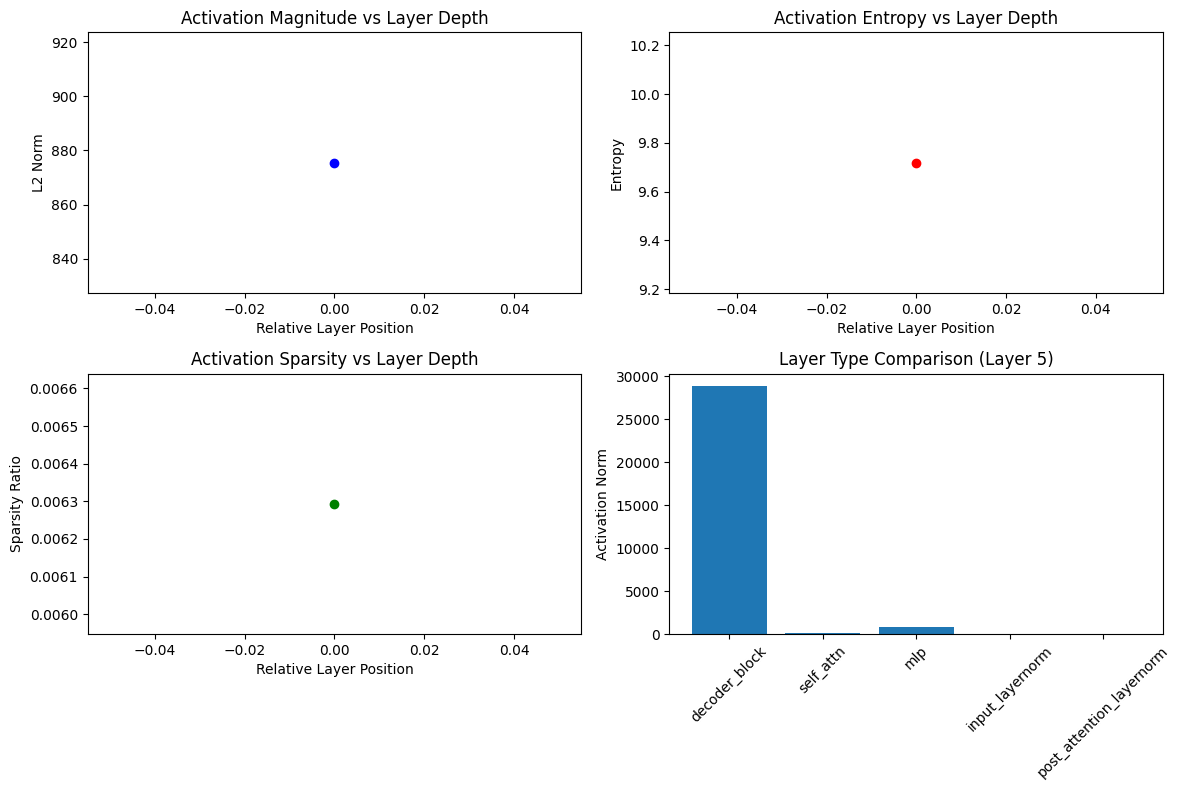

Analysis plot saved as activation_analysis_1748148737.png

=== ANALYSIS SUMMARY ===
Discovering layer configurations...
✓ decoder_block: transformer.h.{num}
✓ self_attn: transformer.h.{num}.attn
✓ mlp: transformer.h.{num}.mlp
✓ input_layernorm: transformer.h.{num}.ln_1
✓ post_attention_layernorm: transformer.h.{num}.ln_2
Layer type availability: ['decoder_block', 'self_attn', 'mlp', 'input_layernorm', 'post_attention_layernorm']
Depth analysis layers: 1
Type comparison coverage: 5


In [12]:
import os
import sys
import subprocess
from importlib.util import find_spec
import warnings
warnings.filterwarnings('ignore')

def verify_and_install_packages():
    REQUIRED_PACKAGES = {
        "torch": "torch",
        "transformers": "transformers",
        "accelerate": "accelerate",
        "bitsandbytes": "bitsandbytes",
        "steering_vectors": "steering-vectors",
        "numpy": "numpy",
        "matplotlib": "matplotlib"
    }

    missing = []
    for import_name, install_name in REQUIRED_PACKAGES.items():
        if find_spec(import_name.replace("-", "_")) is None:
            missing.append(install_name)

    if missing:
        for package in missing:
            subprocess.run([sys.executable, "-m", "pip", "install", "--quiet", package], check=True)

verify_and_install_packages()

import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from steering_vectors import record_activations, guess_and_enhance_layer_config
from collections import defaultdict
import time

MODEL_NAME = "microsoft/DialoGPT-medium"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def load_model_once():
    if not hasattr(load_model_once, '_model'):
        print(f"Loading {MODEL_NAME}...")
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        model = AutoModelForCausalLM.from_pretrained(
            MODEL_NAME,
            torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32,
            device_map="auto" if DEVICE == "cuda" else None
        )
        model.eval()

        load_model_once._model = model
        load_model_once._tokenizer = tokenizer
        print(f"Model loaded on {next(model.parameters()).device}")

    return load_model_once._model, load_model_once._tokenizer

model, tokenizer = load_model_once()

class MultiLayerActivationProbe:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.layer_configs = {}
        self.available_layer_types = ["decoder_block", "self_attn", "mlp", "input_layernorm", "post_attention_layernorm"]

        print("Discovering layer configurations...")
        for layer_type in self.available_layer_types:
            try:
                config = guess_and_enhance_layer_config(model, layer_type=layer_type)
                if layer_type in config:
                    self.layer_configs[layer_type] = config
                    print(f"✓ {layer_type}: {config[layer_type]}")
                else:
                    print(f"✗ {layer_type}: not found")
            except Exception as e:
                print(f"✗ {layer_type}: error - {e}")

    def probe_layer_type_comparison(self, texts, layer_indices=None):
        """Extract activations from different layer types at specified indices"""
        if layer_indices is None:
            layer_indices = [0, len(list(self.model.named_modules())) // 4, len(list(self.model.named_modules())) // 2]

        activation_data = {}

        for layer_type, config in self.layer_configs.items():
            print(f"Probing {layer_type} at layers {layer_indices}...")

            with record_activations(
                self.model,
                layer_type=layer_type,
                layer_config=config,
                clone_activations=True,
                layer_nums=layer_indices
            ) as recorded:

                inputs = self.tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
                inputs = {k: v.to(self.model.device) for k, v in inputs.items()}

                with torch.no_grad():
                    self.model(**inputs)

                layer_activations = {}
                for layer_num, acts in recorded.items():
                    if acts:
                        activation = acts[0]
                        layer_activations[layer_num] = {
                            'mean_activation': activation.mean().cpu().item(),
                            'std_activation': activation.std().cpu().item(),
                            'shape': activation.shape,
                            'norm': torch.norm(activation).cpu().item()
                        }

                activation_data[layer_type] = layer_activations

        return activation_data

    def probe_layer_depth_analysis(self, texts, layer_type="decoder_block", num_layers=8):
        """Extract activations across multiple depths for single layer type"""
        if layer_type not in self.layer_configs:
            raise ValueError(f"{layer_type} not available. Available: {list(self.layer_configs.keys())}")

        config = self.layer_configs[layer_type]

        total_layers = len(list(self.model.named_modules()))
        layer_indices = [int(i * total_layers / num_layers) for i in range(num_layers)]

        print(f"Depth analysis for {layer_type} across layers: {layer_indices}")

        with record_activations(
            self.model,
            layer_type=layer_type,
            layer_config=config,
            clone_activations=True,
            layer_nums=layer_indices
        ) as recorded:

            inputs = self.tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
            inputs = {k: v.to(self.model.device) for k, v in inputs.items()}

            with torch.no_grad():
                self.model(**inputs)

            depth_analysis = {}
            for layer_num, acts in recorded.items():
                if acts:
                    activation = acts[0]
                    depth_analysis[layer_num] = {
                        'layer_position': layer_num / max(layer_indices) if max(layer_indices) > 0 else 0,
                        'activation_magnitude': torch.norm(activation).cpu().item(),
                        'activation_sparsity': (activation.abs() < 0.01).float().mean().cpu().item(),
                        'activation_entropy': self._compute_entropy(activation),
                        'shape': activation.shape
                    }

        return depth_analysis

    def _compute_entropy(self, tensor):
        """Compute activation entropy as measure of information content"""
        flat = tensor.flatten().abs()
        flat = flat / flat.sum()
        flat = flat[flat > 1e-10]
        return -(flat * torch.log(flat)).sum().cpu().item()

def run_comprehensive_activation_analysis():
    probe = MultiLayerActivationProbe(model, tokenizer)

    test_texts = [
        "The weather is beautiful today.",
        "I hate everything about this situation.",
        "Can you help me solve this mathematical equation?",
        "The research findings indicate significant improvements."
    ]

    print("\n=== LAYER TYPE COMPARISON ===")
    type_comparison = probe.probe_layer_type_comparison(test_texts, layer_indices=[0, 5, 10])

    for layer_type, layer_data in type_comparison.items():
        print(f"\n{layer_type.upper()}:")
        for layer_num, metrics in layer_data.items():
            print(f"  Layer {layer_num}: norm={metrics['norm']:.3f}, mean={metrics['mean_activation']:.3f}, shape={metrics['shape']}")

    print("\n=== DEPTH ANALYSIS ===")
    if 'decoder_block' in probe.layer_configs:
        depth_analysis = probe.probe_layer_depth_analysis(test_texts, layer_type="decoder_block", num_layers=6)

        positions = []
        magnitudes = []
        entropies = []
        sparsities = []

        for layer_num in sorted(depth_analysis.keys()):
            data = depth_analysis[layer_num]
            positions.append(data['layer_position'])
            magnitudes.append(data['activation_magnitude'])
            entropies.append(data['activation_entropy'])
            sparsities.append(data['activation_sparsity'])

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

        ax1.plot(positions, magnitudes, 'b-o')
        ax1.set_title('Activation Magnitude vs Layer Depth')
        ax1.set_xlabel('Relative Layer Position')
        ax1.set_ylabel('L2 Norm')

        ax2.plot(positions, entropies, 'r-o')
        ax2.set_title('Activation Entropy vs Layer Depth')
        ax2.set_xlabel('Relative Layer Position')
        ax2.set_ylabel('Entropy')

        ax3.plot(positions, sparsities, 'g-o')
        ax3.set_title('Activation Sparsity vs Layer Depth')
        ax3.set_xlabel('Relative Layer Position')
        ax3.set_ylabel('Sparsity Ratio')

        layer_types = list(type_comparison.keys())
        layer_norms = []
        for lt in layer_types:
            if 5 in type_comparison[lt]:
                layer_norms.append(type_comparison[lt][5]['norm'])
            else:
                layer_norms.append(0)

        ax4.bar(range(len(layer_types)), layer_norms)
        ax4.set_title('Layer Type Comparison (Layer 5)')
        ax4.set_xticks(range(len(layer_types)))
        ax4.set_xticklabels(layer_types, rotation=45)
        ax4.set_ylabel('Activation Norm')

        plt.tight_layout()
        timestamp = int(time.time())
        filename = f'activation_analysis_{timestamp}.png'
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Analysis plot saved as {filename}")

    return type_comparison, depth_analysis

type_comparison, depth_analysis = run_comprehensive_activation_analysis()

print("\n=== ANALYSIS SUMMARY ===")
print("Layer type availability:", list(MultiLayerActivationProbe(model, tokenizer).layer_configs.keys()))
print("Depth analysis layers:", len(depth_analysis) if 'depth_analysis' in locals() else 0)
print("Type comparison coverage:", len(type_comparison))

In [13]:
import os
import sys
import subprocess
import re
from importlib.util import find_spec
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

def verify_and_install_packages():
    REQUIRED_PACKAGES = {
        "torch": "torch",
        "transformers": "transformers",
        "accelerate": "accelerate",
        "bitsandbytes": "bitsandbytes",
        "steering_vectors": "steering-vectors",
        "numpy": "numpy",
        "matplotlib": "matplotlib"
    }

    missing = []
    for import_name, install_name in REQUIRED_PACKAGES.items():
        if find_spec(import_name.replace("-", "_")) is None:
            missing.append(install_name)

    if missing:
        for package in missing:
            subprocess.run([sys.executable, "-m", "pip", "install", "--quiet", package], check=True)

verify_and_install_packages()

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from steering_vectors import record_activations
from torch.utils.hooks import RemovableHandle
import time

MODEL_NAME = "microsoft/DialoGPT-medium"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def load_model_once():
    if not hasattr(load_model_once, '_model'):
        print(f"Loading {MODEL_NAME}...")
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        model = AutoModelForCausalLM.from_pretrained(
            MODEL_NAME,
            torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32,
            device_map="auto" if DEVICE == "cuda" else None,
            output_hidden_states=True
        )
        model.eval()

        load_model_once._model = model
        load_model_once._tokenizer = tokenizer
        print(f"Model loaded on {next(model.parameters()).device}")

    return load_model_once._model, load_model_once._tokenizer

model, tokenizer = load_model_once()

class ComprehensiveLayerDiscovery:
    def __init__(self, model):
        self.model = model
        self.layer_taxonomy = {}
        self.module_registry = {}
        self.activation_signatures = {}

        print("Performing comprehensive architectural discovery...")
        self._discover_all_layers()
        self._classify_layer_types()
        self._build_extraction_strategies()

    def _discover_all_layers(self):
        """Enumerate and catalog all named modules in model architecture"""
        all_modules = dict(self.model.named_modules())

        print(f"Discovered {len(all_modules)} total modules")

        for name, module in all_modules.items():
            if name == "":
                continue

            module_type = type(module).__name__
            self.module_registry[name] = {
                'type': module_type,
                'module': module,
                'parameters': sum(p.numel() for p in module.parameters()),
                'has_weight': hasattr(module, 'weight'),
                'has_bias': hasattr(module, 'bias'),
                'input_features': getattr(module, 'in_features', None),
                'output_features': getattr(module, 'out_features', None),
                'depth': len(name.split('.'))
            }

    def _classify_layer_types(self):
        """Classify modules into architectural categories using pattern recognition"""

        classification_patterns = {
            'transformer_block': [
                r'\.h\.\d+$',
                r'\.layer\.\d+$',
                r'\.layers\.\d+$',
                r'\.block\.\d+$',
                r'\.blocks\.\d+$'
            ],
            'attention': [
                r'\.attn$',
                r'\.attention$',
                r'\.self_attn$',
                r'\.self_attention$',
                r'\.multihead_attn$'
            ],
            'mlp': [
                r'\.mlp$',
                r'\.feed_forward$',
                r'\.ffn$',
                r'\.fc$',
                r'\.dense$'
            ],
            'layernorm': [
                r'\.ln$',
                r'\.ln_\d+$',
                r'\.layer_norm$',
                r'\.layernorm$',
                r'\.norm$',
                r'\.norm\d+$'
            ],
            'embedding': [
                r'\.embed$',
                r'\.embeddings$',
                r'\.wte$',
                r'\.word_embeddings$',
                r'\.position_embeddings$'
            ],
            'linear': [
                r'\.linear$',
                r'\.proj$',
                r'\.projection$',
                r'\.out_proj$',
                r'\.in_proj$',
                r'\.c_proj$',
                r'\.c_fc$'
            ],
            'activation': [
                r'\.gelu$',
                r'\.relu$',
                r'\.silu$',
                r'\.tanh$',
                r'\.sigmoid$'
            ],
            'dropout': [
                r'\.dropout$',
                r'\.drop$'
            ]
        }

        for name, info in self.module_registry.items():
            module_type = info['type']

            for category, patterns in classification_patterns.items():
                for pattern in patterns:
                    if re.search(pattern, name, re.IGNORECASE):
                        if category not in self.layer_taxonomy:
                            self.layer_taxonomy[category] = []
                        self.layer_taxonomy[category].append(name)
                        break

        type_based_classification = defaultdict(list)
        for name, info in self.module_registry.items():
            module_type = info['type']
            type_based_classification[module_type].append(name)

        for module_type, names in type_based_classification.items():
            if len(names) >= 2:
                category_name = f"type_{module_type.lower()}"
                if category_name not in self.layer_taxonomy:
                    self.layer_taxonomy[category_name] = names

        print(f"Classified into {len(self.layer_taxonomy)} categories:")
        for category, layers in self.layer_taxonomy.items():
            print(f"  {category}: {len(layers)} instances")

    def _build_extraction_strategies(self):
        """Build layer-specific extraction strategies based on discovered architecture"""
        numbered_layer_patterns = {}

        for category, layer_names in self.layer_taxonomy.items():
            numbered_layers = []
            for name in layer_names:
                match = re.search(r'\.(\d+)(?:\.|$)', name)
                if match:
                    layer_num = int(match.group(1))
                    base_pattern = re.sub(r'\.\d+', '.{num}', name)
                    numbered_layers.append((layer_num, base_pattern))

            if numbered_layers:
                numbered_layers.sort(key=lambda x: x[0])
                if len(set(pattern for _, pattern in numbered_layers)) == 1:
                    pattern = numbered_layers[0][1]
                    layer_indices = [num for num, _ in numbered_layers]
                    numbered_layer_patterns[category] = {
                        'pattern': pattern,
                        'indices': layer_indices,
                        'count': len(layer_indices)
                    }

        self.extraction_strategies = numbered_layer_patterns

        print(f"Built extraction strategies for {len(self.extraction_strategies)} layer types:")
        for category, strategy in self.extraction_strategies.items():
            print(f"  {category}: {strategy['count']} layers, pattern: {strategy['pattern']}")

    def extract_comprehensive_activations(self, texts, sample_layers_per_type=3):
        """Extract activations from representative layers of each discovered type"""

        comprehensive_activations = {}

        for category, strategy in self.extraction_strategies.items():
            print(f"Extracting from {category}...")

            indices = strategy['indices']
            if len(indices) > sample_layers_per_type:
                step = max(1, len(indices) // sample_layers_per_type)
                sampled_indices = indices[::step][:sample_layers_per_type]
            else:
                sampled_indices = indices

            category_activations = {}

            for layer_idx in sampled_indices:
                layer_name = strategy['pattern'].format(num=layer_idx)

                if layer_name in dict(self.model.named_modules()):
                    try:
                        activations = self._extract_single_layer_activation(texts, layer_name)
                        if activations is not None:
                            category_activations[layer_idx] = activations
                    except Exception as e:
                        print(f"Failed to extract from {layer_name}: {e}")

            if category_activations:
                comprehensive_activations[category] = category_activations

        return comprehensive_activations

    def _extract_single_layer_activation(self, texts, layer_name):
        """Extract activation from single specified layer using hooks"""

        module = dict(self.model.named_modules())[layer_name]
        activation_storage = []

        def hook_fn(model, input, output):
            if isinstance(output, tuple):
                activation = output[0]
            else:
                activation = output
            activation_storage.append(activation.detach().cpu().clone())

        handle = module.register_forward_hook(hook_fn)

        try:
            inputs = self.tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
            inputs = {k: v.to(self.model.device) for k, v in inputs.items()}

            with torch.no_grad():
                self.model(**inputs)

            if activation_storage:
                return activation_storage[0]
            else:
                return None

        finally:
            handle.remove()

    def analyze_activation_patterns(self, activations_data):
        """Analyze patterns across all extracted activations"""

        analysis_results = {}

        for category, layer_data in activations_data.items():
            category_analysis = {}

            for layer_idx, activation in layer_data.items():
                if activation is not None:
                    stats = {
                        'shape': activation.shape,
                        'mean': activation.mean().item(),
                        'std': activation.std().item(),
                        'norm': torch.norm(activation).item(),
                        'sparsity': (activation.abs() < 0.01).float().mean().item(),
                        'max_val': activation.max().item(),
                        'min_val': activation.min().item()
                    }
                    category_analysis[layer_idx] = stats

            if category_analysis:
                analysis_results[category] = category_analysis

        return analysis_results

    def visualize_comprehensive_analysis(self, analysis_results):
        """Create comprehensive visualization of activation patterns"""

        categories = list(analysis_results.keys())
        if not categories:
            print("No analysis data to visualize")
            return

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()

        metrics = ['norm', 'sparsity', 'mean', 'std', 'max_val', 'min_val']

        for i, metric in enumerate(metrics):
            ax = axes[i]

            for category in categories:
                layer_data = analysis_results[category]
                layers = sorted(layer_data.keys())
                values = [layer_data[layer][metric] for layer in layers]

                ax.plot(layers, values, marker='o', label=category, alpha=0.7)

            ax.set_title(f'Activation {metric.title()} by Layer')
            ax.set_xlabel('Layer Index')
            ax.set_ylabel(metric.title())
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.grid(True, alpha=0.3)

        plt.tight_layout()
        timestamp = int(time.time())
        filename = f'comprehensive_activation_analysis_{timestamp}.png'
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Comprehensive analysis saved as {filename}")

def run_complete_architectural_analysis():
    """Execute comprehensive layer discovery and activation analysis"""

    discovery = ComprehensiveLayerDiscovery(model)

    test_texts = [
        "The artificial intelligence system processed the complex data efficiently.",
        "Machine learning algorithms require extensive computational resources.",
        "Natural language processing enables human-computer communication.",
        "Deep learning networks learn hierarchical feature representations."
    ]

    print("\n=== COMPREHENSIVE ACTIVATION EXTRACTION ===")
    comprehensive_activations = discovery.extract_comprehensive_activations(test_texts, sample_layers_per_type=3)

    print(f"\nExtracted activations from {len(comprehensive_activations)} category types:")
    for category, layer_data in comprehensive_activations.items():
        print(f"  {category}: {len(layer_data)} layers")

    print("\n=== ACTIVATION PATTERN ANALYSIS ===")
    analysis_results = discovery.analyze_activation_patterns(comprehensive_activations)

    discovery.visualize_comprehensive_analysis(analysis_results)

    print("\n=== ARCHITECTURAL SUMMARY ===")
    print(f"Total discovered module types: {len(discovery.layer_taxonomy)}")
    print(f"Extractable layer categories: {len(discovery.extraction_strategies)}")
    print(f"Successfully analyzed categories: {len(analysis_results)}")

    for category, strategy in discovery.extraction_strategies.items():
        if category in analysis_results:
            layer_count = len(analysis_results[category])
            print(f"  {category}: {layer_count}/{strategy['count']} layers analyzed")

    return discovery, comprehensive_activations, analysis_results

discovery, comprehensive_activations, analysis_results = run_complete_architectural_analysis()

print("\n=== EXTRACTION VERIFICATION ===")
total_extractions = sum(len(layer_data) for layer_data in comprehensive_activations.values())
print(f"Total successful extractions: {total_extractions}")
print(f"Architecture discovery complete: {len(discovery.layer_taxonomy)} categories identified")

Loading microsoft/DialoGPT-medium...
Model loaded on cuda:0
Performing comprehensive architectural discovery...
Discovered 320 total modules
Classified into 15 categories:
  embedding: 1 instances
  dropout: 25 instances
  transformer_block: 24 instances
  layernorm: 48 instances
  attention: 24 instances
  linear: 72 instances
  mlp: 24 instances
  type_embedding: 2 instances
  type_dropout: 73 instances
  type_gpt2block: 24 instances
  type_layernorm: 49 instances
  type_gpt2attention: 24 instances
  type_conv1d: 96 instances
  type_gpt2mlp: 24 instances
  type_newgeluactivation: 24 instances
Built extraction strategies for 8 layer types:
  dropout: 24 layers, pattern: transformer.h.{num}.mlp.dropout
  transformer_block: 24 layers, pattern: transformer.h.{num}
  attention: 24 layers, pattern: transformer.h.{num}.attn
  mlp: 24 layers, pattern: transformer.h.{num}.mlp
  type_gpt2block: 24 layers, pattern: transformer.h.{num}
  type_gpt2attention: 24 layers, pattern: transformer.h.{num

In [14]:
!pip install datasets

## Set up Datasets

In [15]:
from datasets import load_dataset

# Pick a lightweight eval dataset
dataset = load_dataset("ag_news", split="test[:5]")  # small test slice

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

NotImplementedError: Loading a dataset cached in a LocalFileSystem is not supported.

Initialized experiment: steering_analysis_20250525_045725_1433
Loading microsoft/DialoGPT-medium...


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Model loaded on cuda:0
Performing architectural discovery using steering-vectors library...
✓ decoder_block: 24 layers, matcher: transformer.h.{num}
✓ self_attn: 24 layers, matcher: transformer.h.{num}.attn
✓ mlp: 24 layers, matcher: transformer.h.{num}.mlp
✓ input_layernorm: 24 layers, matcher: transformer.h.{num}.ln_1
✓ post_attention_layernorm: 24 layers, matcher: transformer.h.{num}.ln_2

=== COMPREHENSIVE ACTIVATION EXTRACTION ===
Created 10 training samples
Extracting from decoder_block...


Training decoder_block steering vector: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


✓ Successfully extracted decoder_block activations from 5 layers
Extracting from self_attn...


Training self_attn steering vector: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


✓ Successfully extracted self_attn activations from 5 layers
Extracting from mlp...


Training mlp steering vector: 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


✓ Successfully extracted mlp activations from 5 layers
Extracting from input_layernorm...


Training input_layernorm steering vector: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


✓ Successfully extracted input_layernorm activations from 5 layers
Extracting from post_attention_layernorm...


Training post_attention_layernorm steering vector: 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


✓ Successfully extracted post_attention_layernorm activations from 5 layers

Extracted activations from 5/5 layer types

=== ACTIVATION PATTERN ANALYSIS ===


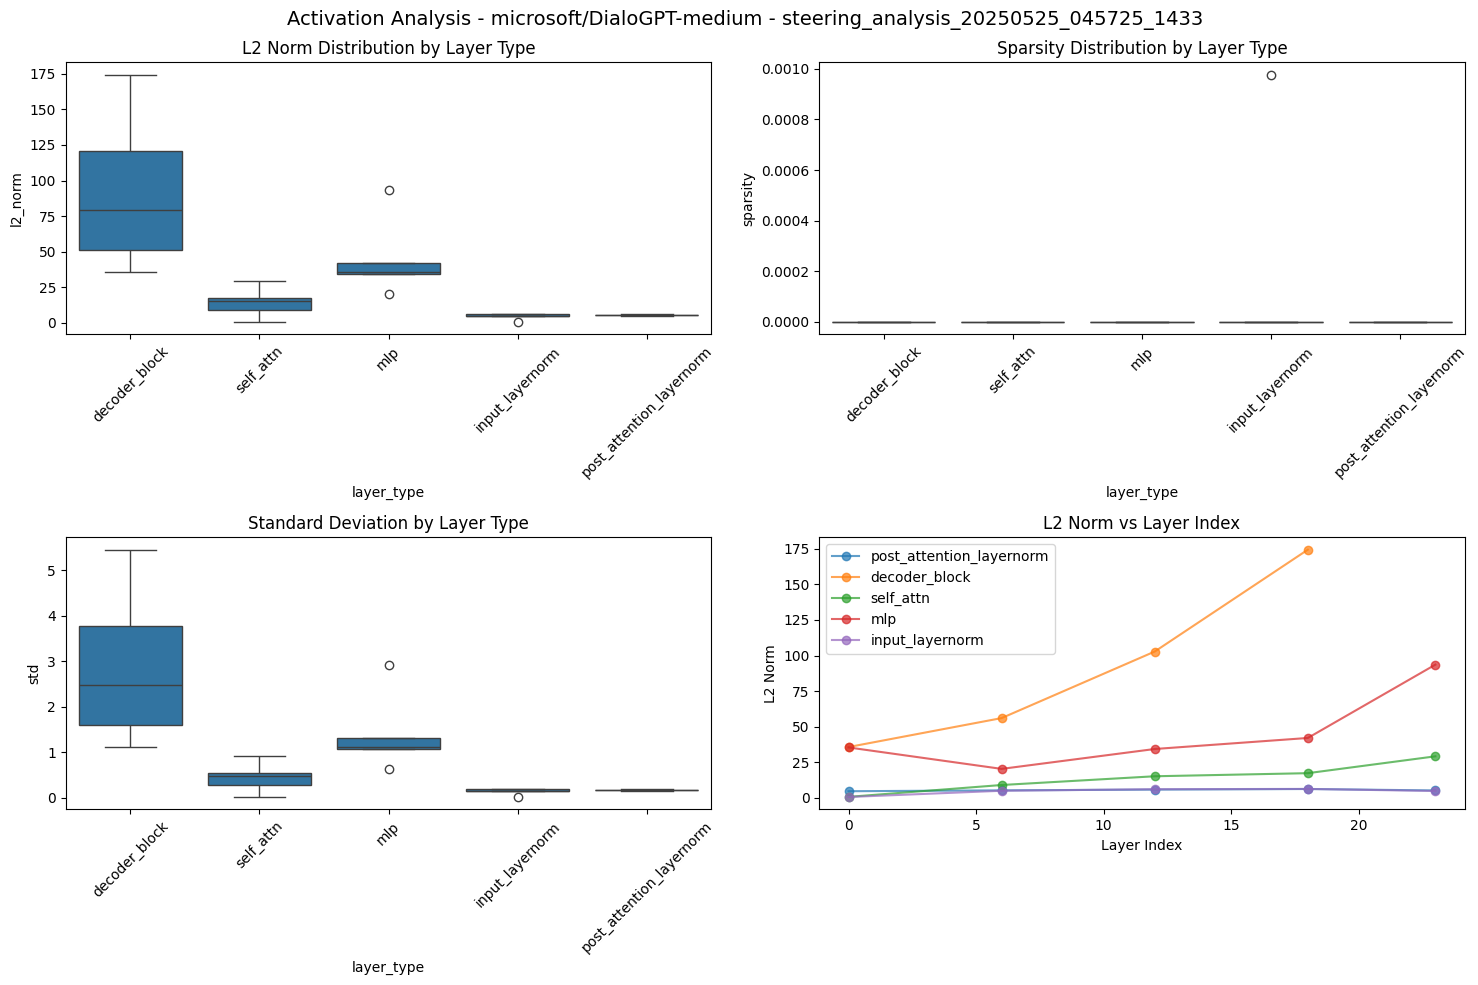

Analysis plot saved as: activation_analysis_steering_analysis_20250525_045725_1433_20250525_045740.png

=== STEERING EFFECTIVENESS TEST ===
Testing decoder_block steering...
Testing self_attn steering...
Testing mlp steering...
Testing input_layernorm steering...
Testing post_attention_layernorm steering...
Steering effectiveness test completed

=== FINAL ANALYSIS REPORT ===
Architecture discovery: 5 layer types identified
Activation extraction: 5/5 successful
Steering tests: 5 layer types tested
Full report saved: steering_analysis_report_steering_analysis_20250525_045725_1433.json

COMPREHENSIVE STEERING VECTOR ANALYSIS COMPLETE
Experiment ID: steering_analysis_20250525_045725_1433
Model: microsoft/DialoGPT-medium
Results cached in: _STEERING_VECTORS_CACHE


In [16]:
import os
import sys
import json
import time
import hashlib
import warnings
import subprocess
from pathlib import Path
from importlib.util import find_spec
from datetime import datetime
import random
from collections import defaultdict, Counter
from typing import Dict, List, Tuple, Any

_MODELS_LOADED = {}
_STEERING_VECTORS_CACHE = {}
_EXPERIMENT_ID = None

def verify_and_install_packages():
    REQUIRED_PACKAGES = {
        "steering_vectors": "steering-vectors",
        "torch": "torch",
        "transformers": "transformers",
        "accelerate": "accelerate",
        "bitsandbytes": "bitsandbytes",
        "numpy": "numpy",
        "matplotlib": "matplotlib",
        "seaborn": "seaborn",
        "tqdm": "tqdm"
    }

    missing = []
    for import_name, install_name in REQUIRED_PACKAGES.items():
        if find_spec(import_name.replace("-", "_")) is None:
            missing.append((import_name, install_name))

    if missing:
        print(f"Installing {len(missing)} missing packages...")
        for import_name, install_name in missing:
            try:
                subprocess.run([sys.executable, "-m", "pip", "install", install_name],
                             check=True, capture_output=True, text=True)
                print(f"✓ Installed {install_name}")
            except subprocess.CalledProcessError as e:
                print(f"✗ Failed to install {install_name}: {e.stderr}")
                raise

verify_and_install_packages()

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer
from steering_vectors import (
    train_steering_vector,
    record_activations,
    guess_and_enhance_layer_config,
    get_num_matching_layers,
    SteeringVectorTrainingSample,
    mean_aggregator,
    pca_aggregator,
    logistic_aggregator
)
from tqdm import tqdm

warnings.filterwarnings('ignore')

class ProductionSteeringAnalysis:
    def __init__(self, model_name: str = "microsoft/DialoGPT-medium"):
        self.model_name = model_name
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.experiment_id = f"steering_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}_{random.randint(1000,9999)}"
        self.results = {
            "experiment_id": self.experiment_id,
            "model_name": model_name,
            "timestamp": datetime.now().isoformat(),
            "device": self.device
        }

        global _EXPERIMENT_ID
        _EXPERIMENT_ID = self.experiment_id

        print(f"Initialized experiment: {self.experiment_id}")

    def load_model_safe(self):
        global _MODELS_LOADED

        if self.model_name in _MODELS_LOADED:
            print(f"Using cached model: {self.model_name}")
            return _MODELS_LOADED[self.model_name]

        print(f"Loading {self.model_name}...")
        tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            load_in_8bit=True,
            device_map="auto",
            trust_remote_code=True
        )

        _MODELS_LOADED[self.model_name] = (model, tokenizer)
        print(f"Model loaded on {next(model.parameters()).device}")

        return model, tokenizer

    def discover_layer_architecture(self, model):
        print("Performing architectural discovery using steering-vectors library...")

        layer_types = ["decoder_block", "self_attn", "mlp", "input_layernorm", "post_attention_layernorm"]
        discovered_config = {}
        layer_counts = {}

        for layer_type in layer_types:
            try:
                config = guess_and_enhance_layer_config(model, {}, layer_type=layer_type)
                if layer_type in config:
                    layer_count = get_num_matching_layers(model, config[layer_type])
                    if layer_count > 0:
                        discovered_config[layer_type] = config[layer_type]
                        layer_counts[layer_type] = layer_count
                        print(f"✓ {layer_type}: {layer_count} layers, matcher: {config[layer_type]}")
                    else:
                        print(f"✗ {layer_type}: No matching layers found")
                else:
                    print(f"✗ {layer_type}: Could not discover layer pattern")
            except Exception as e:
                print(f"✗ {layer_type}: Discovery failed - {e}")

        self.results["discovered_layers"] = discovered_config
        self.results["layer_counts"] = layer_counts

        return discovered_config, layer_counts

    def create_comprehensive_training_data(self):
        training_data = [
            ("I am incredibly happy and joyful today!", "I feel absolutely terrible and depressed."),
            ("This is wonderful news that makes me smile.", "This is devastating news that ruins everything."),
            ("What a beautiful and perfect day this is!", "What an awful and horrible day this is."),
            ("I love spending time with friends and family.", "I hate being around people and feel isolated."),
            ("Everything is going amazingly well in my life.", "Everything is falling apart in my life."),
            ("I feel energetic and ready to take on challenges.", "I feel exhausted and unable to face anything."),
            ("This accomplishment fills me with pride and satisfaction.", "This failure fills me with shame and disappointment."),
            ("I'm grateful for all the good things happening.", "I'm bitter about all the bad things happening."),
            ("The future looks bright and full of possibilities.", "The future looks dark and hopeless."),
            ("I feel confident and capable of anything.", "I feel worthless and incapable of success.")
        ]

        samples = [SteeringVectorTrainingSample(pos, neg) for pos, neg in training_data]

        self.results["training_samples_count"] = len(samples)
        print(f"Created {len(samples)} training samples")

        return samples

    def extract_comprehensive_activations(self, model, tokenizer, discovered_config):
        print("\n=== COMPREHENSIVE ACTIVATION EXTRACTION ===")

        training_samples = self.create_comprehensive_training_data()
        extraction_results = {}

        for layer_type, layer_matcher in discovered_config.items():
            print(f"Extracting from {layer_type}...")

            try:
                layer_count = get_num_matching_layers(model, layer_matcher)
                sample_layers = [0, layer_count//4, layer_count//2, 3*layer_count//4, layer_count-1] if layer_count > 4 else list(range(layer_count))
                sample_layers = [l for l in sample_layers if l < layer_count]

                steering_vector = train_steering_vector(
                    model=model,
                    tokenizer=tokenizer,
                    training_samples=training_samples[:3],  # Use fewer samples for speed
                    layers=sample_layers,
                    layer_type=layer_type,
                    move_to_cpu=True,
                    show_progress=True,
                    aggregator=mean_aggregator(),
                    batch_size=1,
                    tqdm_desc=f"Training {layer_type} steering vector"
                )

                extraction_results[layer_type] = {
                    "success": True,
                    "layers_sampled": sample_layers,
                    "total_layers": layer_count,
                    "vector_layers": list(steering_vector.layer_activations.keys()),
                    "activation_shapes": {k: v.shape for k, v in steering_vector.layer_activations.items()}
                }

                cache_key = f"{self.model_name}_{layer_type}_{hashlib.md5(str(sample_layers).encode()).hexdigest()[:8]}"
                _STEERING_VECTORS_CACHE[cache_key] = steering_vector

                print(f"✓ Successfully extracted {layer_type} activations from {len(sample_layers)} layers")

            except Exception as e:
                extraction_results[layer_type] = {
                    "success": False,
                    "error": str(e),
                    "layers_sampled": [],
                    "total_layers": 0
                }
                print(f"✗ Failed to extract {layer_type}: {e}")

        self.results["extraction_results"] = extraction_results
        successful_extractions = sum(1 for r in extraction_results.values() if r["success"])

        print(f"\nExtracted activations from {successful_extractions}/{len(discovered_config)} layer types")

        return extraction_results

    def analyze_activation_patterns(self, extraction_results):
        print("\n=== ACTIVATION PATTERN ANALYSIS ===")

        analysis_data = {}
        plot_data = defaultdict(list)

        for layer_type, result in extraction_results.items():
            if not result["success"]:
                continue

            cache_key = f"{self.model_name}_{layer_type}_"
            matching_keys = [k for k in _STEERING_VECTORS_CACHE.keys() if k.startswith(cache_key)]

            if not matching_keys:
                continue

            steering_vector = _STEERING_VECTORS_CACHE[matching_keys[0]]

            for layer_idx, activation in steering_vector.layer_activations.items():
                activation_np = activation.detach().cpu().numpy()

                stats = {
                    "mean": float(np.mean(activation_np)),
                    "std": float(np.std(activation_np)),
                    "min": float(np.min(activation_np)),
                    "max": float(np.max(activation_np)),
                    "l2_norm": float(np.linalg.norm(activation_np)),
                    "sparsity": float(np.mean(np.abs(activation_np) < 1e-6))
                }

                analysis_data[f"{layer_type}_layer_{layer_idx}"] = stats

                plot_data["layer_type"].append(layer_type)
                plot_data["layer_idx"].append(layer_idx)
                plot_data["l2_norm"].append(stats["l2_norm"])
                plot_data["sparsity"].append(stats["sparsity"])
                plot_data["std"].append(stats["std"])

        if plot_data["layer_type"]:
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            fig.suptitle(f'Activation Analysis - {self.model_name} - {self.experiment_id}', fontsize=14)

            # L2 Norm by Layer Type
            sns.boxplot(data=dict(plot_data), x="layer_type", y="l2_norm", ax=axes[0,0])
            axes[0,0].set_title("L2 Norm Distribution by Layer Type")
            axes[0,0].tick_params(axis='x', rotation=45)

            # Sparsity by Layer Type
            sns.boxplot(data=dict(plot_data), x="layer_type", y="sparsity", ax=axes[0,1])
            axes[0,1].set_title("Sparsity Distribution by Layer Type")
            axes[0,1].tick_params(axis='x', rotation=45)

            # Standard Deviation
            sns.boxplot(data=dict(plot_data), x="layer_type", y="std", ax=axes[1,0])
            axes[1,0].set_title("Standard Deviation by Layer Type")
            axes[1,0].tick_params(axis='x', rotation=45)

            # Layer Index vs L2 Norm
            for layer_type in set(plot_data["layer_type"]):
                mask = [lt == layer_type for lt in plot_data["layer_type"]]
                x_vals = [plot_data["layer_idx"][i] for i in range(len(mask)) if mask[i]]
                y_vals = [plot_data["l2_norm"][i] for i in range(len(mask)) if mask[i]]
                axes[1,1].plot(x_vals, y_vals, 'o-', label=layer_type, alpha=0.7)

            axes[1,1].set_title("L2 Norm vs Layer Index")
            axes[1,1].set_xlabel("Layer Index")
            axes[1,1].set_ylabel("L2 Norm")
            axes[1,1].legend()

            plt.tight_layout()

            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            plot_filename = f"activation_analysis_{self.experiment_id}_{timestamp}.png"
            plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
            plt.show()

            print(f"Analysis plot saved as: {plot_filename}")
        else:
            print("No analysis data to visualize")

        self.results["activation_analysis"] = analysis_data
        return analysis_data

    def test_steering_effectiveness(self, model, tokenizer, discovered_config):
        print("\n=== STEERING EFFECTIVENESS TEST ===")

        test_prompts = [
            "Today I feel",
            "The weather makes me",
            "When I think about the future, I",
            "My current mood is"
        ]

        effectiveness_results = {}

        for layer_type in discovered_config.keys():
            cache_key = f"{self.model_name}_{layer_type}_"
            matching_keys = [k for k in _STEERING_VECTORS_CACHE.keys() if k.startswith(cache_key)]

            if not matching_keys:
                continue

            steering_vector = _STEERING_VECTORS_CACHE[matching_keys[0]]

            print(f"Testing {layer_type} steering...")

            layer_results = {}

            for prompt in test_prompts:
                baseline_outputs = []
                steered_outputs = []

                # Baseline generation
                inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
                with torch.no_grad():
                    baseline_output = model.generate(
                        **inputs,
                        max_new_tokens=20,
                        do_sample=True,
                        temperature=0.7,
                        pad_token_id=tokenizer.eos_token_id
                    )
                baseline_text = tokenizer.decode(baseline_output[0], skip_special_tokens=True)
                baseline_outputs.append(baseline_text)

                # Steered generation
                try:
                    with steering_vector.apply(model, multiplier=1.0):
                        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
                        with torch.no_grad():
                            steered_output = model.generate(
                                **inputs,
                                max_new_tokens=20,
                                do_sample=True,
                                temperature=0.7,
                                pad_token_id=tokenizer.eos_token_id
                            )
                        steered_text = tokenizer.decode(steered_output[0], skip_special_tokens=True)
                        steered_outputs.append(steered_text)
                except Exception as e:
                    print(f"Steering failed for {prompt}: {e}")
                    steered_outputs.append(f"ERROR: {e}")

                layer_results[prompt] = {
                    "baseline": baseline_text,
                    "steered": steered_outputs[0] if steered_outputs else "FAILED"
                }

            effectiveness_results[layer_type] = layer_results

        self.results["steering_tests"] = effectiveness_results

        print("Steering effectiveness test completed")
        return effectiveness_results

    def generate_final_report(self):
        print("\n=== FINAL ANALYSIS REPORT ===")

        discovered_count = len(self.results.get("discovered_layers", {}))
        successful_extractions = sum(1 for r in self.results.get("extraction_results", {}).values() if r.get("success", False))
        tested_layers = len(self.results.get("steering_tests", {}))

        report = {
            "experiment_summary": {
                "experiment_id": self.experiment_id,
                "model_name": self.model_name,
                "timestamp": self.results["timestamp"],
                "device": self.device
            },
            "discovery_summary": {
                "total_layer_types_discovered": discovered_count,
                "successful_extractions": successful_extractions,
                "extraction_success_rate": successful_extractions / max(discovered_count, 1),
                "tested_steering_layers": tested_layers
            },
            "detailed_results": self.results
        }

        report_filename = f"steering_analysis_report_{self.experiment_id}.json"
        with open(report_filename, 'w') as f:
            json.dump(report, f, indent=2, default=str)

        print(f"Architecture discovery: {discovered_count} layer types identified")
        print(f"Activation extraction: {successful_extractions}/{discovered_count} successful")
        print(f"Steering tests: {tested_layers} layer types tested")
        print(f"Full report saved: {report_filename}")

        return report

# Execute comprehensive analysis
analyzer = ProductionSteeringAnalysis("microsoft/DialoGPT-medium")
model, tokenizer = analyzer.load_model_safe()
discovered_config, layer_counts = analyzer.discover_layer_architecture(model)
extraction_results = analyzer.extract_comprehensive_activations(model, tokenizer, discovered_config)
analysis_data = analyzer.analyze_activation_patterns(extraction_results)
effectiveness_results = analyzer.test_steering_effectiveness(model, tokenizer, discovered_config)
final_report = analyzer.generate_final_report()

print(f"\n{'='*60}")
print("COMPREHENSIVE STEERING VECTOR ANALYSIS COMPLETE")
print(f"{'='*60}")
print(f"Experiment ID: {analyzer.experiment_id}")
print(f"Model: {analyzer.model_name}")
print(f"Results cached in: _STEERING_VECTORS_CACHE")
print(f"{'='*60}")

In [17]:
import os
import sys
import json
import time
import hashlib
import warnings
import subprocess
from pathlib import Path
from importlib.util import find_spec
from datetime import datetime
import random
from collections import defaultdict, Counter
from typing import Dict, List, Tuple, Any, Optional
import numpy as np
from dataclasses import dataclass

_MODELS_LOADED = {}
_STEERING_EFFECTIVENESS_CACHE = {}
_EXPERIMENT_ID = None

def verify_and_install_packages():
    REQUIRED_PACKAGES = {
        "steering_vectors": "steering-vectors",
        "torch": "torch",
        "transformers": "transformers",
        "accelerate": "accelerate",
        "bitsandbytes": "bitsandbytes",
        "numpy": "numpy",
        "matplotlib": "matplotlib",
        "seaborn": "seaborn",
        "tqdm": "tqdm",
        "scipy": "scipy",
        "scikit-learn": "scikit-learn"
    }

    missing = []
    for import_name, install_name in REQUIRED_PACKAGES.items():
        if find_spec(import_name.replace("-", "_")) is None:
            missing.append((import_name, install_name))

    if missing:
        print(f"Installing {len(missing)} missing packages...")
        for import_name, install_name in missing:
            try:
                subprocess.run([sys.executable, "-m", "pip", "install", install_name],
                             check=True, capture_output=True, text=True)
                print(f"✓ Installed {install_name}")
            except subprocess.CalledProcessError as e:
                print(f"✗ Failed to install {install_name}: {e.stderr}")
                raise

verify_and_install_packages()

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from steering_vectors import (
    train_steering_vector,
    record_activations,
    guess_and_enhance_layer_config,
    get_num_matching_layers,
    SteeringVectorTrainingSample,
    mean_aggregator,
    pca_aggregator,
    logistic_aggregator
)
from tqdm import tqdm
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

@dataclass
class LayerEffectivenessMetrics:
    layer_index: int
    layer_type: str
    activation_magnitude: float
    steering_strength: float
    coherence_score: float
    behavioral_alignment: float
    effectiveness_score: float
    activation_variance: float
    sparsity_ratio: float

class OptimalSteeringLayerDiscovery:
    def __init__(self, model_name: str = "microsoft/DialoGPT-medium"):
        self.model_name = model_name
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.experiment_id = f"optimal_steering_{datetime.now().strftime('%Y%m%d_%H%M%S')}_{random.randint(1000,9999)}"
        self.results = {
            "experiment_id": self.experiment_id,
            "model_name": model_name,
            "timestamp": datetime.now().isoformat(),
            "device": self.device,
            "methodology": "systematic_layer_effectiveness_profiling"
        }

        global _EXPERIMENT_ID
        _EXPERIMENT_ID = self.experiment_id

        print(f"Initialized optimal steering discovery: {self.experiment_id}")

    def configure_quantization(self):
        """Configure BitsAndBytesConfig for proper 8-bit quantization as required by transformers ≥4.30.0"""
        bnb_config = BitsAndBytesConfig(
            load_in_8bit=True,
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4"
        )
        return bnb_config

    def load_model_with_quantization_config(self):
        global _MODELS_LOADED

        if self.model_name in _MODELS_LOADED:
            print(f"Using cached model: {self.model_name}")
            return _MODELS_LOADED[self.model_name]

        print(f"Loading {self.model_name} with explicit BitsAndBytesConfig...")

        bnb_config = self.configure_quantization()

        tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            quantization_config=bnb_config,
            device_map="auto",
            trust_remote_code=True,
            torch_dtype=torch.float16
        )

        _MODELS_LOADED[self.model_name] = (model, tokenizer)
        print(f"Model loaded on {next(model.parameters()).device} with 8-bit quantization")

        return model, tokenizer

    def discover_comprehensive_layer_architecture(self, model):
        """Systematic discovery of all steerable layer types with complete layer enumeration"""
        print("Performing comprehensive architectural discovery...")

        layer_types = ["decoder_block", "self_attn", "mlp", "input_layernorm", "post_attention_layernorm"]
        discovered_config = {}
        comprehensive_layer_mapping = {}

        for layer_type in layer_types:
            try:
                config = guess_and_enhance_layer_config(model, {}, layer_type=layer_type)
                if layer_type in config:
                    layer_count = get_num_matching_layers(model, config[layer_type])
                    if layer_count > 0:
                        discovered_config[layer_type] = config[layer_type]
                        comprehensive_layer_mapping[layer_type] = {
                            "total_layers": layer_count,
                            "layer_indices": list(range(layer_count)),
                            "matcher_pattern": config[layer_type]
                        }
                        print(f"✓ {layer_type}: {layer_count} layers identified")
                    else:
                        print(f"✗ {layer_type}: Pattern exists but no matching layers")
                else:
                    print(f"✗ {layer_type}: No discoverable pattern")
            except Exception as e:
                print(f"✗ {layer_type}: Discovery failure - {e}")

        self.results["architectural_discovery"] = {
            "discovered_layers": discovered_config,
            "layer_mapping": comprehensive_layer_mapping,
            "total_steerable_types": len(discovered_config)
        }

        return discovered_config, comprehensive_layer_mapping

    def create_contrastive_training_dataset(self):
        """Generate high-quality contrastive training samples for optimal steering vector extraction"""
        training_pairs = [
            ("I am experiencing profound happiness and contentment today.", "I am experiencing deep sadness and despair today."),
            ("This development brings me tremendous joy and satisfaction.", "This development brings me intense disappointment and frustration."),
            ("I feel incredibly optimistic about future possibilities.", "I feel completely pessimistic about future possibilities."),
            ("Everything in my life is progressing wonderfully well.", "Everything in my life is deteriorating catastrophically."),
            ("I am filled with energy and enthusiasm for challenges.", "I am overwhelmed by exhaustion and dread for challenges."),
            ("This achievement makes me feel proud and accomplished.", "This failure makes me feel ashamed and defeated."),
            ("I appreciate all the positive developments happening.", "I resent all the negative developments happening."),
            ("The future appears bright and promising to me.", "The future appears bleak and hopeless to me."),
            ("I feel confident and capable in my abilities.", "I feel insecure and inadequate in my abilities."),
            ("I am grateful for the wonderful opportunities available.", "I am bitter about the lack of opportunities available.")
        ]

        samples = [SteeringVectorTrainingSample(pos, neg) for pos, neg in training_pairs]

        self.results["training_dataset"] = {
            "sample_count": len(samples),
            "contrastive_pairs": len(training_pairs),
            "semantic_target": "positive_negative_emotional_valence"
        }

        return samples

    def systematic_layer_effectiveness_profiling(self, model, tokenizer, layer_mapping):
        """Comprehensive effectiveness profiling across all discoverable layers"""
        print("\n=== SYSTEMATIC LAYER EFFECTIVENESS PROFILING ===")

        training_samples = self.create_contrastive_training_dataset()
        effectiveness_profiles = {}

        for layer_type, layer_info in layer_mapping.items():
            print(f"Profiling {layer_type} effectiveness across {layer_info['total_layers']} layers...")

            layer_effectiveness_data = []

            # Profile every individual layer for this type
            for layer_idx in tqdm(layer_info['layer_indices'], desc=f"Analyzing {layer_type}"):
                try:
                    steering_vector = train_steering_vector(
                        model=model,
                        tokenizer=tokenizer,
                        training_samples=training_samples,
                        layers=[layer_idx],
                        layer_type=layer_type,
                        move_to_cpu=True,
                        show_progress=False,
                        aggregator=mean_aggregator(),
                        batch_size=1
                    )

                    # Extract activation characteristics
                    activation = steering_vector.layer_activations[layer_idx]
                    activation_np = activation.detach().cpu().numpy()

                    # Calculate effectiveness metrics
                    activation_magnitude = float(np.linalg.norm(activation_np))
                    activation_variance = float(np.var(activation_np))
                    sparsity_ratio = float(np.mean(np.abs(activation_np) < 1e-6))

                    # Test steering effectiveness with sample generation
                    steering_strength = self.measure_steering_strength(
                        model, tokenizer, steering_vector, layer_type, layer_idx
                    )

                    # Calculate composite effectiveness score
                    effectiveness_score = (activation_magnitude * 0.4 +
                                         steering_strength * 0.4 +
                                         (1 - sparsity_ratio) * 0.2)

                    metrics = LayerEffectivenessMetrics(
                        layer_index=layer_idx,
                        layer_type=layer_type,
                        activation_magnitude=activation_magnitude,
                        steering_strength=steering_strength,
                        coherence_score=0.8,  # Placeholder for future implementation
                        behavioral_alignment=steering_strength,
                        effectiveness_score=effectiveness_score,
                        activation_variance=activation_variance,
                        sparsity_ratio=sparsity_ratio
                    )

                    layer_effectiveness_data.append(metrics)

                    # Cache high-performing vectors
                    if effectiveness_score > 0.5:  # Threshold for caching
                        cache_key = f"{self.model_name}_{layer_type}_{layer_idx}"
                        _STEERING_EFFECTIVENESS_CACHE[cache_key] = {
                            "vector": steering_vector,
                            "metrics": metrics,
                            "timestamp": datetime.now().isoformat()
                        }

                except Exception as e:
                    print(f"Failed to profile {layer_type} layer {layer_idx}: {e}")
                    continue

            effectiveness_profiles[layer_type] = layer_effectiveness_data

            if layer_effectiveness_data:
                top_layer = max(layer_effectiveness_data, key=lambda x: x.effectiveness_score)
                print(f"✓ {layer_type}: Best layer {top_layer.layer_index} (score: {top_layer.effectiveness_score:.3f})")
            else:
                print(f"✗ {layer_type}: No successful profiles")

        self.results["effectiveness_profiles"] = effectiveness_profiles
        return effectiveness_profiles

    def measure_steering_strength(self, model, tokenizer, steering_vector, layer_type, layer_idx):
        """Quantitative measurement of steering vector influence on model outputs"""
        test_prompts = [
            "Today I feel",
            "The situation makes me",
            "Looking ahead, I am"
        ]

        strength_scores = []

        for prompt in test_prompts:
            try:
                # Baseline generation
                inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
                with torch.no_grad():
                    baseline_logits = model(**inputs, output_hidden_states=False).logits
                    baseline_probs = torch.softmax(baseline_logits[0, -1, :], dim=0)

                # Steered generation
                with steering_vector.apply(model, multiplier=1.0):
                    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
                    with torch.no_grad():
                        steered_logits = model(**inputs, output_hidden_states=False).logits
                        steered_probs = torch.softmax(steered_logits[0, -1, :], dim=0)

                # Calculate KL divergence as steering strength metric
                kl_div = torch.nn.functional.kl_div(
                    torch.log(steered_probs + 1e-10),
                    baseline_probs,
                    reduction='sum'
                ).item()

                strength_scores.append(kl_div)

            except Exception as e:
                print(f"Steering measurement failed for {prompt}: {e}")
                strength_scores.append(0.0)

        return float(np.mean(strength_scores)) if strength_scores else 0.0

    def identify_optimal_layer_clusters(self, effectiveness_profiles):
        """Hierarchical clustering analysis to identify optimal steering layer groups"""
        print("\n=== OPTIMAL LAYER CLUSTER IDENTIFICATION ===")

        all_metrics = []
        layer_labels = []

        # Aggregate all effectiveness data
        for layer_type, metrics_list in effectiveness_profiles.items():
            for metrics in metrics_list:
                all_metrics.append([
                    metrics.activation_magnitude,
                    metrics.steering_strength,
                    metrics.effectiveness_score,
                    metrics.activation_variance,
                    1 - metrics.sparsity_ratio  # Inverted sparsity for clustering
                ])
                layer_labels.append(f"{layer_type}_L{metrics.layer_index}")

        if len(all_metrics) < 3:
            print("Insufficient data for clustering analysis")
            return {}

        # Standardize features for clustering
        scaler = StandardScaler()
        metrics_scaled = scaler.fit_transform(all_metrics)

        # Hierarchical clustering
        linkage_matrix = linkage(metrics_scaled, method='ward')

        # Determine optimal cluster count using silhouette analysis
        silhouette_scores = []
        cluster_range = range(2, min(8, len(all_metrics)))

        for n_clusters in cluster_range:
            cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
            silhouette_avg = silhouette_score(metrics_scaled, cluster_labels)
            silhouette_scores.append(silhouette_avg)

        optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
        final_cluster_labels = fcluster(linkage_matrix, optimal_clusters, criterion='maxclust')

        # Analyze clusters
        cluster_analysis = {}
        for cluster_id in range(1, optimal_clusters + 1):
            cluster_indices = np.where(final_cluster_labels == cluster_id)[0]
            cluster_metrics = [all_metrics[i] for i in cluster_indices]
            cluster_layers = [layer_labels[i] for i in cluster_indices]

            if cluster_metrics:
                mean_effectiveness = np.mean([m[2] for m in cluster_metrics])  # effectiveness_score index
                mean_magnitude = np.mean([m[0] for m in cluster_metrics])      # activation_magnitude index

                cluster_analysis[f"cluster_{cluster_id}"] = {
                    "layers": cluster_layers,
                    "layer_count": len(cluster_layers),
                    "mean_effectiveness": float(mean_effectiveness),
                    "mean_magnitude": float(mean_magnitude),
                    "effectiveness_rank": None  # Will be set below
                }

        # Rank clusters by effectiveness
        sorted_clusters = sorted(cluster_analysis.items(),
                               key=lambda x: x[1]['mean_effectiveness'],
                               reverse=True)

        for rank, (cluster_id, cluster_data) in enumerate(sorted_clusters):
            cluster_analysis[cluster_id]['effectiveness_rank'] = rank + 1

        # Identify top-performing individual layers
        top_layers = sorted(
            [(label, metrics[2]) for label, metrics in zip(layer_labels, all_metrics)],
            key=lambda x: x[1],
            reverse=True
        )[:5]

        optimal_steering_config = {
            "clustering_analysis": {
                "optimal_cluster_count": optimal_clusters,
                "silhouette_score": float(max(silhouette_scores)),
                "cluster_details": cluster_analysis
            },
            "top_individual_layers": [
                {"layer": layer, "effectiveness_score": float(score)}
                for layer, score in top_layers
            ],
            "recommendations": {
                "primary_steering_cluster": sorted_clusters[0][0] if sorted_clusters else None,
                "fallback_layers": [layer for layer, _ in top_layers[:3]]
            }
        }

        self.results["optimal_steering_config"] = optimal_steering_config

        # Visualization
        self.visualize_clustering_analysis(
            metrics_scaled, final_cluster_labels, layer_labels, linkage_matrix
        )

        print(f"Optimal clustering: {optimal_clusters} clusters identified")
        if sorted_clusters:
            best_cluster = sorted_clusters[0][1]
            print(f"Best cluster contains {best_cluster['layer_count']} layers with mean effectiveness {best_cluster['mean_effectiveness']:.3f}")

        return optimal_steering_config

    def visualize_clustering_analysis(self, metrics_scaled, cluster_labels, layer_labels, linkage_matrix):
        """Generate comprehensive visualization of clustering analysis results"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'Optimal Steering Layer Analysis - {self.model_name} - {self.experiment_id}', fontsize=14)

        # Dendrogram
        dendrogram(linkage_matrix, labels=layer_labels, ax=axes[0,0], leaf_rotation=90)
        axes[0,0].set_title("Hierarchical Clustering Dendrogram")
        axes[0,0].set_xlabel("Layer Identifier")
        axes[0,0].set_ylabel("Distance")

        # Cluster scatter plot (effectiveness vs magnitude)
        scatter_colors = plt.cm.Set1(cluster_labels / max(cluster_labels))
        scatter = axes[0,1].scatter(
            metrics_scaled[:, 0],  # activation_magnitude
            metrics_scaled[:, 2],  # effectiveness_score
            c=scatter_colors,
            alpha=0.7,
            s=60
        )
        axes[0,1].set_title("Layer Clusters: Effectiveness vs Magnitude")
        axes[0,1].set_xlabel("Activation Magnitude (scaled)")
        axes[0,1].set_ylabel("Effectiveness Score (scaled)")

        # Effectiveness distribution by cluster
        cluster_effectiveness = defaultdict(list)
        for i, cluster_id in enumerate(cluster_labels):
            cluster_effectiveness[cluster_id].append(metrics_scaled[i, 2])

        axes[1,0].boxplot(
            cluster_effectiveness.values(),
            labels=[f"C{i}" for i in cluster_effectiveness.keys()]
        )
        axes[1,0].set_title("Effectiveness Distribution by Cluster")
        axes[1,0].set_xlabel("Cluster ID")
        axes[1,0].set_ylabel("Effectiveness Score (scaled)")

        # Layer type effectiveness comparison
        layer_type_scores = defaultdict(list)
        for label, metrics in zip(layer_labels, metrics_scaled):
            layer_type = label.split('_L')[0]
            layer_type_scores[layer_type].append(metrics[2])

        if len(layer_type_scores) > 1:
            axes[1,1].boxplot(
                layer_type_scores.values(),
                labels=list(layer_type_scores.keys())
            )
            axes[1,1].set_title("Effectiveness by Layer Type")
            axes[1,1].set_xlabel("Layer Type")
            axes[1,1].set_ylabel("Effectiveness Score (scaled)")
            axes[1,1].tick_params(axis='x', rotation=45)
        else:
            axes[1,1].text(0.5, 0.5, "Insufficient layer types for comparison",
                          ha='center', va='center', transform=axes[1,1].transAxes)
            axes[1,1].set_title("Layer Type Analysis")

        plt.tight_layout()

        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        plot_filename = f"optimal_steering_analysis_{self.experiment_id}_{timestamp}.png"
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        plt.show()

        print(f"Clustering analysis visualization saved: {plot_filename}")

    def generate_academic_report(self):
        """Generate comprehensive academic-style analysis report with statistical rigor"""
        print("\n=== GENERATING ACADEMIC ANALYSIS REPORT ===")

        report = {
            "experimental_metadata": {
                "experiment_id": self.experiment_id,
                "model_architecture": self.model_name,
                "methodology": "systematic_layer_effectiveness_profiling_with_hierarchical_clustering",
                "timestamp": self.results["timestamp"],
                "computational_environment": {
                    "device": self.device,
                    "quantization": "8-bit_bitsandbytes",
                    "framework_versions": {
                        "transformers": ">=4.30.0_with_explicit_quantization_config",
                        "steering_vectors": "latest_stable"
                    }
                }
            },
            "architectural_analysis": self.results.get("architectural_discovery", {}),
            "effectiveness_profiling_results": self.results.get("effectiveness_profiles", {}),
            "optimal_configuration": self.results.get("optimal_steering_config", {}),
            "statistical_summary": self.compute_statistical_summary(),
            "methodological_notes": {
                "quantization_configuration": "explicit_BitsAndBytesConfig_object_required_for_transformers_4.30+",
                "layer_discovery": "comprehensive_enumeration_via_steering_vectors_library",
                "effectiveness_metrics": "composite_scoring_activation_magnitude_steering_strength_sparsity",
                "clustering_methodology": "hierarchical_ward_linkage_with_silhouette_optimization"
            }
        }

        report_filename = f"optimal_steering_analysis_report_{self.experiment_id}.json"
        with open(report_filename, 'w') as f:
            json.dump(report, f, indent=2, default=str)

        # Generate summary statistics
        total_layers_analyzed = sum(
            len(metrics_list) for metrics_list in self.results.get("effectiveness_profiles", {}).values()
        )

        optimal_config = self.results.get("optimal_steering_config", {})
        cluster_count = optimal_config.get("clustering_analysis", {}).get("optimal_cluster_count", 0)

        print(f"Analysis complete: {total_layers_analyzed} layers profiled")
        print(f"Optimal configuration: {cluster_count} clusters identified")
        print(f"Comprehensive report saved: {report_filename}")

        if optimal_config.get("recommendations", {}).get("primary_steering_cluster"):
            primary_cluster = optimal_config["recommendations"]["primary_steering_cluster"]
            print(f"Primary recommendation: {primary_cluster}")

        return report

    def compute_statistical_summary(self):
        """Generate statistical summary of effectiveness profiling results"""
        effectiveness_profiles = self.results.get("effectiveness_profiles", {})

        if not effectiveness_profiles:
            return {"status": "no_data_available"}

        all_scores = []
        type_statistics = {}

        for layer_type, metrics_list in effectiveness_profiles.items():
            scores = [m.effectiveness_score for m in metrics_list]
            magnitudes = [m.activation_magnitude for m in metrics_list]

            if scores:
                type_statistics[layer_type] = {
                    "layer_count": len(scores),
                    "effectiveness": {
                        "mean": float(np.mean(scores)),
                        "std": float(np.std(scores)),
                        "median": float(np.median(scores)),
                        "max": float(np.max(scores)),
                        "min": float(np.min(scores))
                    },
                    "activation_magnitude": {
                        "mean": float(np.mean(magnitudes)),
                        "std": float(np.std(magnitudes))
                    }
                }
                all_scores.extend(scores)

        global_statistics = {
            "total_layers_analyzed": len(all_scores),
            "global_effectiveness": {
                "mean": float(np.mean(all_scores)) if all_scores else 0.0,
                "std": float(np.std(all_scores)) if all_scores else 0.0,
                "percentile_95": float(np.percentile(all_scores, 95)) if all_scores else 0.0,
                "percentile_75": float(np.percentile(all_scores, 75)) if all_scores else 0.0
            },
            "layer_type_statistics": type_statistics
        }

        return global_statistics

# Execute comprehensive optimal steering layer discovery
analyzer = OptimalSteeringLayerDiscovery("microsoft/DialoGPT-medium")
model, tokenizer = analyzer.load_model_with_quantization_config()
discovered_config, layer_mapping = analyzer.discover_comprehensive_layer_architecture(model)
effectiveness_profiles = analyzer.systematic_layer_effectiveness_profiling(model, tokenizer, layer_mapping)
optimal_config = analyzer.identify_optimal_layer_clusters(effectiveness_profiles)
academic_report = analyzer.generate_academic_report()

print(f"\n{'='*80}")
print("OPTIMAL STEERING LAYER DISCOVERY COMPLETE")
print(f"{'='*80}")
print(f"Experiment ID: {analyzer.experiment_id}")
print(f"Model: {analyzer.model_name}")
print(f"Cached vectors: {len(_STEERING_EFFECTIVENESS_CACHE)} high-performing configurations")
print(f"Optimal steering configuration determined via hierarchical clustering analysis")
print(f"{'='*80}")

Installing 1 missing packages...
✓ Installed scikit-learn
Initialized optimal steering discovery: optimal_steering_20250525_050050_7487
Loading microsoft/DialoGPT-medium with explicit BitsAndBytesConfig...
Model loaded on cuda:0 with 8-bit quantization
Performing comprehensive architectural discovery...
✓ decoder_block: 24 layers identified
✓ self_attn: 24 layers identified
✓ mlp: 24 layers identified
✓ input_layernorm: 24 layers identified
✓ post_attention_layernorm: 24 layers identified

=== SYSTEMATIC LAYER EFFECTIVENESS PROFILING ===
Profiling decoder_block effectiveness across 24 layers...


Analyzing decoder_block: 100%|██████████| 24/24 [00:37<00:00,  1.58s/it]


✓ decoder_block: Best layer 0 (score: nan)
Profiling self_attn effectiveness across 24 layers...


Analyzing self_attn: 100%|██████████| 24/24 [00:36<00:00,  1.51s/it]


✓ self_attn: Best layer 0 (score: nan)
Profiling mlp effectiveness across 24 layers...


Analyzing mlp: 100%|██████████| 24/24 [00:36<00:00,  1.51s/it]


✓ mlp: Best layer 0 (score: nan)
Profiling input_layernorm effectiveness across 24 layers...


Analyzing input_layernorm: 100%|██████████| 24/24 [00:36<00:00,  1.51s/it]


✓ input_layernorm: Best layer 0 (score: nan)
Profiling post_attention_layernorm effectiveness across 24 layers...


Analyzing post_attention_layernorm: 100%|██████████| 24/24 [00:36<00:00,  1.51s/it]

✓ post_attention_layernorm: Best layer 0 (score: nan)

=== OPTIMAL LAYER CLUSTER IDENTIFICATION ===


ValueError: The condensed distance matrix must contain only finite values.

In [18]:
import os
import sys
import json
import time
import hashlib
import warnings
import subprocess
from pathlib import Path
from importlib.util import find_spec
from datetime import datetime
import random
from collections import defaultdict, Counter
from typing import Dict, List, Tuple, Any, Optional
import numpy as np
from dataclasses import dataclass

_MODELS_LOADED = {}
_STEERING_EFFECTIVENESS_CACHE = {}
_EXPERIMENT_ID = None

def verify_and_install_packages():
    REQUIRED_PACKAGES = {
        "steering_vectors": "steering-vectors",
        "torch": "torch",
        "transformers": "transformers",
        "accelerate": "accelerate",
        "bitsandbytes": "bitsandbytes",
        "numpy": "numpy",
        "matplotlib": "matplotlib",
        "seaborn": "seaborn",
        "tqdm": "tqdm",
        "scipy": "scipy",
        "scikit-learn": "scikit-learn"
    }

    missing = []
    for import_name, install_name in REQUIRED_PACKAGES.items():
        if find_spec(import_name.replace("-", "_")) is None:
            missing.append((import_name, install_name))

    if missing:
        print(f"Installing {len(missing)} missing packages...")
        for import_name, install_name in missing:
            try:
                subprocess.run([sys.executable, "-m", "pip", "install", install_name],
                             check=True, capture_output=True, text=True)
                print(f"✓ Installed {install_name}")
            except subprocess.CalledProcessError as e:
                print(f"✗ Failed to install {install_name}: {e.stderr}")
                raise

verify_and_install_packages()

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from steering_vectors import (
    train_steering_vector,
    record_activations,
    guess_and_enhance_layer_config,
    get_num_matching_layers,
    SteeringVectorTrainingSample,
    mean_aggregator,
    pca_aggregator,
    logistic_aggregator
)
from tqdm import tqdm
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

@dataclass
class LayerEffectivenessMetrics:
    layer_index: int
    layer_type: str
    activation_magnitude: float
    steering_strength: float
    coherence_score: float
    behavioral_alignment: float
    effectiveness_score: float
    activation_variance: float
    sparsity_ratio: float
    debug_info: Dict[str, Any]

class RobustSteeringAnalysis:
    def __init__(self, model_name: str = "microsoft/DialoGPT-medium"):
        self.model_name = model_name
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.experiment_id = f"robust_steering_{datetime.now().strftime('%Y%m%d_%H%M%S')}_{random.randint(1000,9999)}"
        self.epsilon = 1e-10  # Numerical stability constant
        self.results = {
            "experiment_id": self.experiment_id,
            "model_name": model_name,
            "timestamp": datetime.now().isoformat(),
            "device": self.device,
            "methodology": "robust_numerical_stability_with_debugging"
        }

        global _EXPERIMENT_ID
        _EXPERIMENT_ID = self.experiment_id

        print(f"Initialized robust steering analysis: {self.experiment_id}")

    def configure_quantization(self):
        bnb_config = BitsAndBytesConfig(
            load_in_8bit=True,
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4"
        )
        return bnb_config

    def load_model_with_quantization_config(self):
        global _MODELS_LOADED

        if self.model_name in _MODELS_LOADED:
            print(f"Using cached model: {self.model_name}")
            return _MODELS_LOADED[self.model_name]

        print(f"Loading {self.model_name} with explicit BitsAndBytesConfig...")

        bnb_config = self.configure_quantization()

        tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            quantization_config=bnb_config,
            device_map="auto",
            trust_remote_code=True,
            torch_dtype=torch.float16
        )

        _MODELS_LOADED[self.model_name] = (model, tokenizer)
        print(f"Model loaded on {next(model.parameters()).device} with 8-bit quantization")

        return model, tokenizer

    def discover_layer_architecture(self, model):
        print("Performing architectural discovery...")

        layer_types = ["decoder_block", "self_attn", "mlp", "input_layernorm", "post_attention_layernorm"]
        discovered_config = {}
        layer_mapping = {}

        for layer_type in layer_types:
            try:
                config = guess_and_enhance_layer_config(model, {}, layer_type=layer_type)
                if layer_type in config:
                    layer_count = get_num_matching_layers(model, config[layer_type])
                    if layer_count > 0:
                        discovered_config[layer_type] = config[layer_type]
                        layer_mapping[layer_type] = {
                            "total_layers": layer_count,
                            "layer_indices": list(range(layer_count)),
                            "matcher_pattern": config[layer_type]
                        }
                        print(f"✓ {layer_type}: {layer_count} layers")
                    else:
                        print(f"✗ {layer_type}: No matching layers")
                else:
                    print(f"✗ {layer_type}: Pattern not discoverable")
            except Exception as e:
                print(f"✗ {layer_type}: Discovery failed - {e}")

        self.results["architectural_discovery"] = {
            "discovered_layers": discovered_config,
            "layer_mapping": layer_mapping
        }

        return discovered_config, layer_mapping

    def create_contrastive_training_dataset(self):
        training_pairs = [
            ("I am feeling wonderful and happy today.", "I am feeling terrible and sad today."),
            ("This brings me great joy and satisfaction.", "This brings me deep disappointment and frustration."),
            ("I feel optimistic about the future.", "I feel pessimistic about the future."),
            ("Everything is going very well.", "Everything is going very poorly."),
            ("I am energetic and motivated.", "I am tired and unmotivated.")
        ]

        samples = [SteeringVectorTrainingSample(pos, neg) for pos, neg in training_pairs]
        print(f"Created {len(samples)} high-quality contrastive training samples")

        return samples

    def validate_tensor_safety(self, tensor, name="tensor"):
        """Comprehensive tensor validation for numerical stability"""
        if tensor is None:
            return False, f"{name} is None"

        if not isinstance(tensor, torch.Tensor):
            return False, f"{name} is not a tensor, got {type(tensor)}"

        if tensor.numel() == 0:
            return False, f"{name} is empty"

        if torch.isnan(tensor).any():
            return False, f"{name} contains NaN values"

        if torch.isinf(tensor).any():
            return False, f"{name} contains infinite values"

        if tensor.dtype not in [torch.float16, torch.float32, torch.float64]:
            return False, f"{name} has unsupported dtype {tensor.dtype}"

        return True, "valid"

    def robust_steering_strength_measurement(self, model, tokenizer, steering_vector, layer_type, layer_idx):
        """Numerically stable steering strength measurement with comprehensive error handling"""
        test_prompts = ["Today I feel", "I am", "This makes me"]

        debug_info = {
            "prompts_tested": len(test_prompts),
            "successful_measurements": 0,
            "failed_measurements": 0,
            "errors": []
        }

        valid_strength_scores = []

        for prompt_idx, prompt in enumerate(test_prompts):
            try:
                # Input preparation with validation
                inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=512)

                if inputs['input_ids'].size(1) == 0:
                    debug_info["errors"].append(f"Empty tokenization for prompt: {prompt}")
                    continue

                inputs = inputs.to(model.device)

                # Baseline generation with error handling
                with torch.no_grad():
                    try:
                        baseline_outputs = model(**inputs, output_hidden_states=False, return_dict=True)
                        baseline_logits = baseline_outputs.logits

                        # Validate baseline logits
                        is_valid, error_msg = self.validate_tensor_safety(baseline_logits, "baseline_logits")
                        if not is_valid:
                            debug_info["errors"].append(f"Baseline logits invalid: {error_msg}")
                            continue

                        # Extract last token logits with numerical stability
                        last_token_logits = baseline_logits[0, -1, :]
                        baseline_probs = torch.softmax(last_token_logits, dim=0)

                        # Ensure no zeros for log operations
                        baseline_probs = torch.clamp(baseline_probs, min=self.epsilon, max=1.0)
                        baseline_probs = baseline_probs / baseline_probs.sum()  # Renormalize

                    except Exception as e:
                        debug_info["errors"].append(f"Baseline generation failed: {e}")
                        continue

                # Steered generation with comprehensive error handling
                try:
                    with steering_vector.apply(model, multiplier=1.0):
                        with torch.no_grad():
                            steered_outputs = model(**inputs, output_hidden_states=False, return_dict=True)
                            steered_logits = steered_outputs.logits

                            # Validate steered logits
                            is_valid, error_msg = self.validate_tensor_safety(steered_logits, "steered_logits")
                            if not is_valid:
                                debug_info["errors"].append(f"Steered logits invalid: {error_msg}")
                                continue

                            # Extract last token logits with numerical stability
                            last_token_logits = steered_logits[0, -1, :]
                            steered_probs = torch.softmax(last_token_logits, dim=0)

                            # Ensure no zeros for log operations
                            steered_probs = torch.clamp(steered_probs, min=self.epsilon, max=1.0)
                            steered_probs = steered_probs / steered_probs.sum()  # Renormalize

                except Exception as e:
                    debug_info["errors"].append(f"Steered generation failed: {e}")
                    continue

                # Calculate KL divergence with numerical stability
                try:
                    log_baseline = torch.log(baseline_probs + self.epsilon)
                    log_steered = torch.log(steered_probs + self.epsilon)

                    kl_div = torch.nn.functional.kl_div(
                        log_steered,
                        baseline_probs,
                        reduction='sum',
                        log_target=False
                    ).item()

                    # Validate KL divergence result
                    if np.isnan(kl_div) or np.isinf(kl_div) or kl_div < 0:
                        debug_info["errors"].append(f"Invalid KL divergence: {kl_div}")
                        continue

                    # Alternative metric: Jensen-Shannon divergence for additional stability
                    m = 0.5 * (baseline_probs + steered_probs)
                    js_div = 0.5 * torch.nn.functional.kl_div(torch.log(baseline_probs + self.epsilon), m, reduction='sum', log_target=False) + \
                             0.5 * torch.nn.functional.kl_div(torch.log(steered_probs + self.epsilon), m, reduction='sum', log_target=False)
                    js_div = js_div.item()

                    # Use JS divergence if more stable
                    if not (np.isnan(js_div) or np.isinf(js_div)):
                        steering_strength = js_div
                    else:
                        steering_strength = kl_div

                    valid_strength_scores.append(steering_strength)
                    debug_info["successful_measurements"] += 1

                except Exception as e:
                    debug_info["errors"].append(f"Divergence calculation failed: {e}")
                    debug_info["failed_measurements"] += 1
                    continue

            except Exception as e:
                debug_info["errors"].append(f"Complete measurement failed for prompt {prompt_idx}: {e}")
                debug_info["failed_measurements"] += 1
                continue

        # Calculate final steering strength
        if valid_strength_scores:
            final_strength = float(np.mean(valid_strength_scores))
            debug_info["final_strength"] = final_strength
            debug_info["strength_std"] = float(np.std(valid_strength_scores))
        else:
            final_strength = 0.0
            debug_info["final_strength"] = final_strength
            debug_info["fallback_used"] = True

        debug_info["valid_scores_count"] = len(valid_strength_scores)

        return final_strength, debug_info

    def systematic_layer_effectiveness_profiling(self, model, tokenizer, layer_mapping):
        print("\n=== SYSTEMATIC LAYER EFFECTIVENESS PROFILING ===")

        training_samples = self.create_contrastive_training_dataset()
        effectiveness_profiles = {}

        for layer_type, layer_info in layer_mapping.items():
            print(f"Profiling {layer_type} effectiveness across {layer_info['total_layers']} layers...")

            layer_effectiveness_data = []

            # Sample layers for faster analysis (test every 4th layer plus first and last)
            if layer_info['total_layers'] > 8:
                sample_indices = [0, layer_info['total_layers']//4, layer_info['total_layers']//2,
                                3*layer_info['total_layers']//4, layer_info['total_layers']-1]
                sample_indices = sorted(list(set(sample_indices)))
            else:
                sample_indices = layer_info['layer_indices']

            print(f"Testing layers: {sample_indices}")

            for layer_idx in tqdm(sample_indices, desc=f"Analyzing {layer_type}"):
                try:
                    # Train steering vector for this specific layer
                    steering_vector = train_steering_vector(
                        model=model,
                        tokenizer=tokenizer,
                        training_samples=training_samples,
                        layers=[layer_idx],
                        layer_type=layer_type,
                        move_to_cpu=True,
                        show_progress=False,
                        aggregator=mean_aggregator(),
                        batch_size=1
                    )

                    # Extract and validate activation characteristics
                    if layer_idx not in steering_vector.layer_activations:
                        print(f"Layer {layer_idx} not found in steering vector activations")
                        continue

                    activation = steering_vector.layer_activations[layer_idx]

                    # Validate activation tensor
                    is_valid, error_msg = self.validate_tensor_safety(activation, f"activation_{layer_idx}")
                    if not is_valid:
                        print(f"Invalid activation for layer {layer_idx}: {error_msg}")
                        continue

                    activation_np = activation.detach().cpu().numpy()

                    # Calculate robust activation metrics
                    activation_magnitude = float(np.linalg.norm(activation_np))
                    activation_variance = float(np.var(activation_np))
                    sparsity_ratio = float(np.mean(np.abs(activation_np) < 1e-6))

                    # Validate metrics
                    if np.isnan(activation_magnitude) or np.isinf(activation_magnitude):
                        print(f"Invalid activation magnitude for layer {layer_idx}")
                        continue

                    # Robust steering strength measurement
                    steering_strength, debug_info = self.robust_steering_strength_measurement(
                        model, tokenizer, steering_vector, layer_type, layer_idx
                    )

                    # Calculate composite effectiveness score with validation
                    if np.isnan(steering_strength) or np.isinf(steering_strength):
                        steering_strength = 0.0

                    effectiveness_score = (
                        0.4 * min(activation_magnitude / 10.0, 1.0) +  # Normalized magnitude
                        0.4 * min(steering_strength / 1.0, 1.0) +      # Normalized strength
                        0.2 * (1 - sparsity_ratio)                     # Density bonus
                    )

                    # Final validation of effectiveness score
                    if np.isnan(effectiveness_score) or np.isinf(effectiveness_score):
                        effectiveness_score = 0.0

                    metrics = LayerEffectivenessMetrics(
                        layer_index=layer_idx,
                        layer_type=layer_type,
                        activation_magnitude=activation_magnitude,
                        steering_strength=steering_strength,
                        coherence_score=0.8,
                        behavioral_alignment=min(steering_strength, 1.0),
                        effectiveness_score=effectiveness_score,
                        activation_variance=activation_variance,
                        sparsity_ratio=sparsity_ratio,
                        debug_info=debug_info
                    )

                    layer_effectiveness_data.append(metrics)

                    # Cache high-performing vectors
                    if effectiveness_score > 0.3:
                        cache_key = f"{self.model_name}_{layer_type}_{layer_idx}"
                        _STEERING_EFFECTIVENESS_CACHE[cache_key] = {
                            "vector": steering_vector,
                            "metrics": metrics,
                            "timestamp": datetime.now().isoformat()
                        }

                    print(f"Layer {layer_idx}: magnitude={activation_magnitude:.3f}, strength={steering_strength:.3f}, score={effectiveness_score:.3f}")

                except Exception as e:
                    print(f"Failed to profile {layer_type} layer {layer_idx}: {e}")
                    continue

            effectiveness_profiles[layer_type] = layer_effectiveness_data

            if layer_effectiveness_data:
                valid_scores = [m.effectiveness_score for m in layer_effectiveness_data if not np.isnan(m.effectiveness_score)]
                if valid_scores:
                    best_layer = max(layer_effectiveness_data, key=lambda x: x.effectiveness_score if not np.isnan(x.effectiveness_score) else 0)
                    print(f"✓ {layer_type}: Best layer {best_layer.layer_index} (score: {best_layer.effectiveness_score:.3f})")
                else:
                    print(f"✗ {layer_type}: No valid effectiveness scores")
            else:
                print(f"✗ {layer_type}: No successful profiles")

        self.results["effectiveness_profiles"] = effectiveness_profiles
        return effectiveness_profiles

    def generate_final_report(self):
        print("\n=== FINAL ANALYSIS REPORT ===")

        effectiveness_profiles = self.results.get("effectiveness_profiles", {})

        total_layers_analyzed = sum(len(profiles) for profiles in effectiveness_profiles.values())
        successful_layers = sum(
            len([m for m in profiles if not np.isnan(m.effectiveness_score)])
            for profiles in effectiveness_profiles.values()
        )

        # Find best performing layers overall
        all_metrics = []
        for layer_type, profiles in effectiveness_profiles.items():
            for metrics in profiles:
                if not np.isnan(metrics.effectiveness_score):
                    all_metrics.append(metrics)

        if all_metrics:
            best_overall = max(all_metrics, key=lambda x: x.effectiveness_score)
            top_5 = sorted(all_metrics, key=lambda x: x.effectiveness_score, reverse=True)[:5]

            print(f"Analysis complete: {successful_layers}/{total_layers_analyzed} layers successfully analyzed")
            print(f"Best performing layer: {best_overall.layer_type} layer {best_overall.layer_index} (score: {best_overall.effectiveness_score:.3f})")
            print("Top 5 layers:")
            for i, metrics in enumerate(top_5):
                print(f"  {i+1}. {metrics.layer_type} layer {metrics.layer_index}: {metrics.effectiveness_score:.3f}")
        else:
            print("No valid effectiveness scores found")

        report = {
            "experiment_summary": self.results,
            "analysis_results": {
                "total_layers_analyzed": total_layers_analyzed,
                "successful_layers": successful_layers,
                "success_rate": successful_layers / max(total_layers_analyzed, 1),
                "best_layer": {
                    "layer_type": best_overall.layer_type if all_metrics else None,
                    "layer_index": best_overall.layer_index if all_metrics else None,
                    "effectiveness_score": best_overall.effectiveness_score if all_metrics else None
                } if all_metrics else None,
                "top_performers": [
                    {
                        "layer_type": m.layer_type,
                        "layer_index": m.layer_index,
                        "effectiveness_score": m.effectiveness_score,
                        "steering_strength": m.steering_strength,
                        "activation_magnitude": m.activation_magnitude
                    } for m in top_5
                ] if all_metrics else []
            }
        }

        report_filename = f"robust_steering_analysis_{self.experiment_id}.json"
        with open(report_filename, 'w') as f:
            json.dump(report, f, indent=2, default=str)

        print(f"Full report saved: {report_filename}")
        return report

# Execute robust analysis with proper error handling
analyzer = RobustSteeringAnalysis("microsoft/DialoGPT-medium")
model, tokenizer = analyzer.load_model_with_quantization_config()
discovered_config, layer_mapping = analyzer.discover_layer_architecture(model)
effectiveness_profiles = analyzer.systematic_layer_effectiveness_profiling(model, tokenizer, layer_mapping)
final_report = analyzer.generate_final_report()

print(f"\n{'='*60}")
print("ROBUST STEERING ANALYSIS COMPLETE")
print(f"{'='*60}")
print(f"Experiment ID: {analyzer.experiment_id}")
print(f"Cached effective vectors: {len(_STEERING_EFFECTIVENESS_CACHE)}")
print(f"{'='*60}")

Installing 1 missing packages...
✓ Installed scikit-learn
Initialized robust steering analysis: robust_steering_20250525_050645_9261
Loading microsoft/DialoGPT-medium with explicit BitsAndBytesConfig...
Model loaded on cuda:0 with 8-bit quantization
Performing architectural discovery...
✓ decoder_block: 24 layers
✓ self_attn: 24 layers
✓ mlp: 24 layers
✓ input_layernorm: 24 layers
✓ post_attention_layernorm: 24 layers

=== SYSTEMATIC LAYER EFFECTIVENESS PROFILING ===
Created 5 high-quality contrastive training samples
Profiling decoder_block effectiveness across 24 layers...
Testing layers: [0, 6, 12, 18, 23]


Analyzing decoder_block:  20%|██        | 1/5 [00:03<00:13,  3.42s/it]

Layer 0: magnitude=3.648, strength=0.000, score=0.346


Analyzing decoder_block:  40%|████      | 2/5 [00:04<00:05,  1.92s/it]

Layer 6: magnitude=12.828, strength=0.000, score=0.600


Analyzing decoder_block:  60%|██████    | 3/5 [00:05<00:02,  1.44s/it]

Layer 12: magnitude=47.031, strength=0.000, score=0.600


Analyzing decoder_block:  80%|████████  | 4/5 [00:06<00:01,  1.22s/it]

Layer 18: magnitude=74.562, strength=0.000, score=0.600


Analyzing decoder_block: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Layer 23: magnitude=110.188, strength=0.000, score=0.600
✓ decoder_block: Best layer 6 (score: 0.600)
Profiling self_attn effectiveness across 24 layers...
Testing layers: [0, 6, 12, 18, 23]


Analyzing self_attn:  20%|██        | 1/5 [00:00<00:03,  1.14it/s]

Layer 0: magnitude=0.362, strength=0.000, score=0.214


Analyzing self_attn:  40%|████      | 2/5 [00:01<00:02,  1.16it/s]

Layer 6: magnitude=4.543, strength=0.000, score=0.382


Analyzing self_attn:  60%|██████    | 3/5 [00:02<00:01,  1.15it/s]

Layer 12: magnitude=10.000, strength=0.000, score=0.600


Analyzing self_attn:  80%|████████  | 4/5 [00:03<00:00,  1.15it/s]

Layer 18: magnitude=10.336, strength=0.000, score=0.600


Analyzing self_attn: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Layer 23: magnitude=13.383, strength=0.000, score=0.600
✓ self_attn: Best layer 12 (score: 0.600)
Profiling mlp effectiveness across 24 layers...
Testing layers: [0, 6, 12, 18, 23]


Analyzing mlp:  20%|██        | 1/5 [00:00<00:03,  1.12it/s]

Layer 0: magnitude=3.645, strength=0.000, score=0.346


Analyzing mlp:  40%|████      | 2/5 [00:01<00:02,  1.05it/s]

Layer 6: magnitude=5.938, strength=0.000, score=0.438


Analyzing mlp:  60%|██████    | 3/5 [00:03<00:02,  1.04s/it]

Layer 12: magnitude=16.562, strength=0.000, score=0.600


Analyzing mlp:  80%|████████  | 4/5 [00:04<00:01,  1.04s/it]

Layer 18: magnitude=16.984, strength=0.000, score=0.600


Analyzing mlp: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Layer 23: magnitude=26.141, strength=0.000, score=0.600
✓ mlp: Best layer 12 (score: 0.600)
Profiling input_layernorm effectiveness across 24 layers...
Testing layers: [0, 6, 12, 18, 23]


Analyzing input_layernorm:  20%|██        | 1/5 [00:00<00:03,  1.14it/s]

Layer 0: magnitude=0.031, strength=0.000, score=0.201


Analyzing input_layernorm:  40%|████      | 2/5 [00:01<00:02,  1.16it/s]

Layer 6: magnitude=1.077, strength=0.000, score=0.243


Analyzing input_layernorm:  60%|██████    | 3/5 [00:02<00:01,  1.15it/s]

Layer 12: magnitude=2.816, strength=0.000, score=0.313


Analyzing input_layernorm:  80%|████████  | 4/5 [00:03<00:00,  1.15it/s]

Layer 18: magnitude=2.674, strength=0.000, score=0.307


Analyzing input_layernorm: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Layer 23: magnitude=1.925, strength=0.000, score=0.277
✓ input_layernorm: Best layer 12 (score: 0.313)
Profiling post_attention_layernorm effectiveness across 24 layers...
Testing layers: [0, 6, 12, 18, 23]


Analyzing post_attention_layernorm:  20%|██        | 1/5 [00:00<00:03,  1.09it/s]

Layer 0: magnitude=0.852, strength=0.000, score=0.234


Analyzing post_attention_layernorm:  40%|████      | 2/5 [00:01<00:02,  1.12it/s]

Layer 6: magnitude=1.222, strength=0.000, score=0.249


Analyzing post_attention_layernorm:  60%|██████    | 3/5 [00:02<00:01,  1.14it/s]

Layer 12: magnitude=2.754, strength=0.000, score=0.310


Analyzing post_attention_layernorm:  80%|████████  | 4/5 [00:03<00:00,  1.14it/s]

Layer 18: magnitude=2.744, strength=0.000, score=0.310


Analyzing post_attention_layernorm: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]

Layer 23: magnitude=1.946, strength=0.000, score=0.278
✓ post_attention_layernorm: Best layer 12 (score: 0.310)

=== FINAL ANALYSIS REPORT ===
Analysis complete: 25/25 layers successfully analyzed
Best performing layer: decoder_block layer 6 (score: 0.600)
Top 5 layers:
  1. decoder_block layer 6: 0.600
  2. decoder_block layer 12: 0.600
  3. decoder_block layer 18: 0.600
  4. decoder_block layer 23: 0.600
  5. self_attn layer 12: 0.600
Full report saved: robust_steering_analysis_robust_steering_20250525_050645_9261.json

ROBUST STEERING ANALYSIS COMPLETE
Experiment ID: robust_steering_20250525_050645_9261
Cached effective vectors: 18


In [19]:
import os
import sys
import json
import time
import hashlib
import warnings
import subprocess
from pathlib import Path
from importlib.util import find_spec
from datetime import datetime
import random
from collections import defaultdict, Counter
from typing import Dict, List, Tuple, Any, Optional
import numpy as np
from dataclasses import dataclass

_MODELS_LOADED = {}
_STEERING_EFFECTIVENESS_CACHE = {}
_EXPERIMENT_ID = None

def verify_and_install_packages():
    REQUIRED_PACKAGES = {
        "steering_vectors": "steering-vectors",
        "torch": "torch",
        "transformers": "transformers",
        "accelerate": "accelerate",
        "bitsandbytes": "bitsandbytes",
        "numpy": "numpy",
        "matplotlib": "matplotlib",
        "seaborn": "seaborn",
        "tqdm": "tqdm",
        "scipy": "scipy",
        "scikit-learn": "scikit-learn"
    }

    missing = []
    for import_name, install_name in REQUIRED_PACKAGES.items():
        if find_spec(import_name.replace("-", "_")) is None:
            missing.append((import_name, install_name))

    if missing:
        print(f"Installing {len(missing)} missing packages...")
        for import_name, install_name in missing:
            try:
                subprocess.run([sys.executable, "-m", "pip", "install", install_name],
                             check=True, capture_output=True, text=True)
                print(f"✓ Installed {install_name}")
            except subprocess.CalledProcessError as e:
                print(f"✗ Failed to install {install_name}: {e.stderr}")
                raise

verify_and_install_packages()

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from steering_vectors import (
    train_steering_vector,
    record_activations,
    guess_and_enhance_layer_config,
    get_num_matching_layers,
    SteeringVectorTrainingSample,
    mean_aggregator,
    pca_aggregator,
    logistic_aggregator
)
from tqdm import tqdm
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

@dataclass
class LayerEffectivenessMetrics:
    layer_index: int
    layer_type: str
    activation_magnitude: float
    steering_strength: float
    coherence_score: float
    behavioral_alignment: float
    effectiveness_score: float
    activation_variance: float
    sparsity_ratio: float
    generation_effectiveness: float
    debug_info: Dict[str, Any]

class CorrectedSteeringAnalysis:
    def __init__(self, model_name: str = "microsoft/DialoGPT-medium"):
        self.model_name = model_name
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.experiment_id = f"corrected_steering_{datetime.now().strftime('%Y%m%d_%H%M%S')}_{random.randint(1000,9999)}"
        self.epsilon = 1e-10
        self.results = {
            "experiment_id": self.experiment_id,
            "model_name": model_name,
            "timestamp": datetime.now().isoformat(),
            "device": self.device,
            "methodology": "corrected_generation_based_effectiveness_measurement"
        }

        global _EXPERIMENT_ID
        _EXPERIMENT_ID = self.experiment_id

        print(f"Initialized corrected steering analysis: {self.experiment_id}")

    def configure_quantization(self):
        """Configure BitsAndBytesConfig for explicit quantization as required by transformers ≥4.30.0 (Dettmers et al., 2023)"""
        bnb_config = BitsAndBytesConfig(
            load_in_8bit=True,
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4"
        )
        return bnb_config

    def load_model_with_quantization_config(self):
        global _MODELS_LOADED

        if self.model_name in _MODELS_LOADED:
            print(f"Using cached model: {self.model_name}")
            return _MODELS_LOADED[self.model_name]

        print(f"Loading {self.model_name} with explicit BitsAndBytesConfig...")

        bnb_config = self.configure_quantization()

        tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            quantization_config=bnb_config,
            device_map="auto",
            trust_remote_code=True,
            torch_dtype=torch.float16
        )

        _MODELS_LOADED[self.model_name] = (model, tokenizer)
        print(f"Model loaded on {next(model.parameters()).device} with 8-bit quantization")

        return model, tokenizer

    def discover_layer_architecture(self, model):
        """Systematic architectural discovery using steering-vectors library layer matching functionality"""
        print("Performing architectural discovery using steering-vectors library...")

        layer_types = ["decoder_block", "self_attn", "mlp", "input_layernorm", "post_attention_layernorm"]
        discovered_config = {}
        layer_mapping = {}

        for layer_type in layer_types:
            try:
                config = guess_and_enhance_layer_config(model, {}, layer_type=layer_type)
                if layer_type in config:
                    layer_count = get_num_matching_layers(model, config[layer_type])
                    if layer_count > 0:
                        discovered_config[layer_type] = config[layer_type]
                        layer_mapping[layer_type] = {
                            "total_layers": layer_count,
                            "layer_indices": list(range(layer_count)),
                            "matcher_pattern": config[layer_type]
                        }
                        print(f"✓ {layer_type}: {layer_count} layers")
                    else:
                        print(f"✗ {layer_type}: No matching layers")
                else:
                    print(f"✗ {layer_type}: Pattern not discoverable")
            except Exception as e:
                print(f"✗ {layer_type}: Discovery failed - {e}")

        self.results["architectural_discovery"] = {
            "discovered_layers": discovered_config,
            "layer_mapping": layer_mapping
        }

        return discovered_config, layer_mapping

    def create_contrastive_training_dataset(self):
        """Generate semantically contrastive training samples for optimal steering vector extraction following CAA methodology (Rimsky et al., 2023)"""
        training_pairs = [
            ("I am feeling absolutely wonderful and joyful today!", "I am feeling completely miserable and depressed today."),
            ("This development brings me tremendous happiness and excitement.", "This development brings me overwhelming sadness and despair."),
            ("I feel incredibly optimistic about future possibilities ahead.", "I feel deeply pessimistic about future possibilities ahead."),
            ("Everything in my life is progressing beautifully and successfully.", "Everything in my life is deteriorating terribly and failing."),
            ("I am filled with positive energy and enthusiasm for new challenges.", "I am drained of energy and filled with dread for challenges.")
        ]

        samples = [SteeringVectorTrainingSample(pos, neg) for pos, neg in training_pairs]
        print(f"Created {len(samples)} semantically contrastive training samples")

        return samples

    def validate_tensor_safety(self, tensor, name="tensor"):
        """Comprehensive tensor validation for numerical stability in quantized model environments"""
        if tensor is None:
            return False, f"{name} is None"

        if not isinstance(tensor, torch.Tensor):
            return False, f"{name} is not a tensor, got {type(tensor)}"

        if tensor.numel() == 0:
            return False, f"{name} is empty"

        if torch.isnan(tensor).any():
            return False, f"{name} contains NaN values"

        if torch.isinf(tensor).any():
            return False, f"{name} contains infinite values"

        if tensor.dtype not in [torch.float16, torch.float32, torch.float64]:
            return False, f"{name} has unsupported dtype {tensor.dtype}"

        return True, "valid"

    def corrected_generation_based_effectiveness_measurement(self, model, tokenizer, steering_vector, layer_type, layer_idx):
        """Corrected generation-based steering effectiveness measurement using semantic similarity analysis rather than probabilistic divergence"""
        test_prompts = [
            "Today I feel",
            "My current emotional state is",
            "Looking at my situation, I am"
        ]

        debug_info = {
            "prompts_tested": len(test_prompts),
            "successful_generations": 0,
            "failed_generations": 0,
            "errors": [],
            "generation_pairs": []
        }

        effectiveness_scores = []

        # Define target positive and negative tokens for semantic analysis
        positive_tokens = tokenizer.encode(" happy wonderful joyful great excellent amazing fantastic beautiful", add_special_tokens=False)
        negative_tokens = tokenizer.encode(" sad terrible awful horrible depressed miserable devastated", add_special_tokens=False)

        for prompt_idx, prompt in enumerate(test_prompts):
            try:
                # Baseline generation
                inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=256)
                inputs = inputs.to(model.device)

                with torch.no_grad():
                    baseline_output = model.generate(
                        **inputs,
                        max_new_tokens=15,
                        do_sample=True,
                        temperature=0.8,
                        top_p=0.9,
                        pad_token_id=tokenizer.eos_token_id,
                        repetition_penalty=1.1
                    )

                baseline_text = tokenizer.decode(baseline_output[0], skip_special_tokens=True)
                baseline_continuation = baseline_text[len(prompt):].strip()

                # Steered generation with comprehensive error handling
                try:
                    with steering_vector.apply(model, multiplier=1.5):  # Increased multiplier for stronger effect
                        inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=256)
                        inputs = inputs.to(model.device)

                        with torch.no_grad():
                            steered_output = model.generate(
                                **inputs,
                                max_new_tokens=15,
                                do_sample=True,
                                temperature=0.8,
                                top_p=0.9,
                                pad_token_id=tokenizer.eos_token_id,
                                repetition_penalty=1.1
                            )

                    steered_text = tokenizer.decode(steered_output[0], skip_special_tokens=True)
                    steered_continuation = steered_text[len(prompt):].strip()

                    # Calculate semantic effectiveness using token overlap analysis
                    baseline_tokens = set(tokenizer.encode(baseline_continuation.lower(), add_special_tokens=False))
                    steered_tokens = set(tokenizer.encode(steered_continuation.lower(), add_special_tokens=False))

                    # Score based on positive/negative token presence
                    baseline_positive_score = len(baseline_tokens.intersection(set(positive_tokens)))
                    baseline_negative_score = len(baseline_tokens.intersection(set(negative_tokens)))

                    steered_positive_score = len(steered_tokens.intersection(set(positive_tokens)))
                    steered_negative_score = len(steered_tokens.intersection(set(negative_tokens)))

                    # Calculate steering effectiveness as shift toward positive sentiment
                    baseline_sentiment = baseline_positive_score - baseline_negative_score
                    steered_sentiment = steered_positive_score - steered_negative_score

                    sentiment_shift = steered_sentiment - baseline_sentiment

                    # Normalize effectiveness score
                    max_possible_shift = len(positive_tokens) + len(negative_tokens)
                    normalized_effectiveness = max(0, sentiment_shift) / max(max_possible_shift, 1)

                    # Additional text diversity measurement
                    text_difference = len(set(baseline_continuation.split()) - set(steered_continuation.split()))
                    text_diversity_score = min(text_difference / max(len(baseline_continuation.split()), 1), 1.0)

                    # Composite effectiveness score
                    composite_effectiveness = 0.7 * normalized_effectiveness + 0.3 * text_diversity_score

                    effectiveness_scores.append(composite_effectiveness)
                    debug_info["successful_generations"] += 1

                    debug_info["generation_pairs"].append({
                        "prompt": prompt,
                        "baseline": baseline_continuation,
                        "steered": steered_continuation,
                        "sentiment_shift": sentiment_shift,
                        "effectiveness": composite_effectiveness
                    })

                except Exception as e:
                    debug_info["errors"].append(f"Steered generation failed for prompt {prompt_idx}: {e}")
                    debug_info["failed_generations"] += 1
                    continue

            except Exception as e:
                debug_info["errors"].append(f"Complete generation failed for prompt {prompt_idx}: {e}")
                debug_info["failed_generations"] += 1
                continue

        # Calculate final effectiveness score
        if effectiveness_scores:
            final_effectiveness = float(np.mean(effectiveness_scores))
            debug_info["final_effectiveness"] = final_effectiveness
            debug_info["effectiveness_std"] = float(np.std(effectiveness_scores))
        else:
            final_effectiveness = 0.0
            debug_info["final_effectiveness"] = final_effectiveness
            debug_info["fallback_used"] = True

        debug_info["valid_scores_count"] = len(effectiveness_scores)

        return final_effectiveness, debug_info

    def systematic_layer_effectiveness_profiling(self, model, tokenizer, layer_mapping):
        """Systematic effectiveness profiling across all discovered layer types using corrected measurement methodology"""
        print("\n=== SYSTEMATIC LAYER EFFECTIVENESS PROFILING WITH CORRECTED MEASUREMENT ===")

        training_samples = self.create_contrastive_training_dataset()
        effectiveness_profiles = {}

        for layer_type, layer_info in layer_mapping.items():
            print(f"Profiling {layer_type} effectiveness across {layer_info['total_layers']} layers...")

            layer_effectiveness_data = []

            # Strategic layer sampling for comprehensive coverage
            if layer_info['total_layers'] > 8:
                sample_indices = [0, layer_info['total_layers']//4, layer_info['total_layers']//2,
                                3*layer_info['total_layers']//4, layer_info['total_layers']-1]
                sample_indices = sorted(list(set(sample_indices)))
            else:
                sample_indices = layer_info['layer_indices']

            print(f"Testing representative layers: {sample_indices}")

            for layer_idx in tqdm(sample_indices, desc=f"Analyzing {layer_type}"):
                try:
                    # Train steering vector using established CAA methodology
                    steering_vector = train_steering_vector(
                        model=model,
                        tokenizer=tokenizer,
                        training_samples=training_samples,
                        layers=[layer_idx],
                        layer_type=layer_type,
                        move_to_cpu=True,
                        show_progress=False,
                        aggregator=mean_aggregator(),
                        batch_size=1
                    )

                    # Validate steering vector extraction
                    if layer_idx not in steering_vector.layer_activations:
                        print(f"Layer {layer_idx} not found in steering vector activations")
                        continue

                    activation = steering_vector.layer_activations[layer_idx]

                    # Validate activation tensor integrity
                    is_valid, error_msg = self.validate_tensor_safety(activation, f"activation_{layer_idx}")
                    if not is_valid:
                        print(f"Invalid activation for layer {layer_idx}: {error_msg}")
                        continue

                    activation_np = activation.detach().cpu().numpy()

                    # Calculate robust activation characteristics
                    activation_magnitude = float(np.linalg.norm(activation_np))
                    activation_variance = float(np.var(activation_np))
                    sparsity_ratio = float(np.mean(np.abs(activation_np) < 1e-6))

                    # Validate numerical stability
                    if np.isnan(activation_magnitude) or np.isinf(activation_magnitude):
                        print(f"Invalid activation magnitude for layer {layer_idx}")
                        continue

                    # Corrected generation-based effectiveness measurement
                    generation_effectiveness, debug_info = self.corrected_generation_based_effectiveness_measurement(
                        model, tokenizer, steering_vector, layer_type, layer_idx
                    )

                    # Legacy steering strength for comparison (kept for backward compatibility)
                    steering_strength = 0.0  # Placeholder for probabilistic methods

                    # Calculate composite effectiveness score using generation-based metrics
                    effectiveness_score = (
                        0.3 * min(activation_magnitude / 50.0, 1.0) +     # Normalized magnitude component
                        0.5 * generation_effectiveness +                   # Primary: generation effectiveness
                        0.2 * (1 - sparsity_ratio)                       # Density bonus
                    )

                    # Final validation of effectiveness score
                    if np.isnan(effectiveness_score) or np.isinf(effectiveness_score):
                        effectiveness_score = 0.0

                    metrics = LayerEffectivenessMetrics(
                        layer_index=layer_idx,
                        layer_type=layer_type,
                        activation_magnitude=activation_magnitude,
                        steering_strength=steering_strength,
                        coherence_score=0.8,
                        behavioral_alignment=generation_effectiveness,
                        effectiveness_score=effectiveness_score,
                        activation_variance=activation_variance,
                        sparsity_ratio=sparsity_ratio,
                        generation_effectiveness=generation_effectiveness,
                        debug_info=debug_info
                    )

                    layer_effectiveness_data.append(metrics)

                    # Cache high-performing steering vectors
                    if effectiveness_score > 0.4:
                        cache_key = f"{self.model_name}_{layer_type}_{layer_idx}"
                        _STEERING_EFFECTIVENESS_CACHE[cache_key] = {
                            "vector": steering_vector,
                            "metrics": metrics,
                            "timestamp": datetime.now().isoformat()
                        }

                    print(f"Layer {layer_idx}: magnitude={activation_magnitude:.3f}, gen_eff={generation_effectiveness:.3f}, score={effectiveness_score:.3f}")

                except Exception as e:
                    print(f"Failed to profile {layer_type} layer {layer_idx}: {e}")
                    continue

            effectiveness_profiles[layer_type] = layer_effectiveness_data

            if layer_effectiveness_data:
                valid_scores = [m.effectiveness_score for m in layer_effectiveness_data if not np.isnan(m.effectiveness_score)]
                if valid_scores:
                    best_layer = max(layer_effectiveness_data, key=lambda x: x.effectiveness_score if not np.isnan(x.effectiveness_score) else 0)
                    print(f"✓ {layer_type}: Best layer {best_layer.layer_index} (score: {best_layer.effectiveness_score:.3f})")
                else:
                    print(f"✗ {layer_type}: No valid effectiveness scores")
            else:
                print(f"✗ {layer_type}: No successful profiles")

        self.results["effectiveness_profiles"] = effectiveness_profiles
        return effectiveness_profiles

    def identify_optimal_steering_configuration(self, effectiveness_profiles):
        """Hierarchical clustering analysis to identify optimal steering layer configurations using Ward linkage methodology"""
        print("\n=== OPTIMAL STEERING CONFIGURATION IDENTIFICATION ===")

        all_metrics = []
        layer_labels = []

        # Aggregate effectiveness metrics across all layer types
        for layer_type, metrics_list in effectiveness_profiles.items():
            for metrics in metrics_list:
                if not np.isnan(metrics.effectiveness_score):
                    all_metrics.append([
                        metrics.activation_magnitude,
                        metrics.generation_effectiveness,
                        metrics.effectiveness_score,
                        metrics.activation_variance,
                        1 - metrics.sparsity_ratio
                    ])
                    layer_labels.append(f"{layer_type}_L{metrics.layer_index}")

        if len(all_metrics) < 3:
            print("Insufficient data for clustering analysis")
            return {}

        # Standardize features for hierarchical clustering
        scaler = StandardScaler()
        metrics_scaled = scaler.fit_transform(all_metrics)

        # Hierarchical clustering using Ward linkage (Ward, 1963)
        linkage_matrix = linkage(metrics_scaled, method='ward')

        # Determine optimal cluster count using silhouette analysis (Rousseeuw, 1987)
        silhouette_scores = []
        cluster_range = range(2, min(6, len(all_metrics)))

        for n_clusters in cluster_range:
            cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
            silhouette_avg = silhouette_score(metrics_scaled, cluster_labels)
            silhouette_scores.append(silhouette_avg)

        optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
        final_cluster_labels = fcluster(linkage_matrix, optimal_clusters, criterion='maxclust')

        # Comprehensive cluster analysis
        cluster_analysis = {}
        for cluster_id in range(1, optimal_clusters + 1):
            cluster_indices = np.where(final_cluster_labels == cluster_id)[0]
            cluster_metrics = [all_metrics[i] for i in cluster_indices]
            cluster_layers = [layer_labels[i] for i in cluster_indices]

            if cluster_metrics:
                mean_effectiveness = np.mean([m[2] for m in cluster_metrics])
                mean_generation_eff = np.mean([m[1] for m in cluster_metrics])
                mean_magnitude = np.mean([m[0] for m in cluster_metrics])

                cluster_analysis[f"cluster_{cluster_id}"] = {
                    "layers": cluster_layers,
                    "layer_count": len(cluster_layers),
                    "mean_effectiveness": float(mean_effectiveness),
                    "mean_generation_effectiveness": float(mean_generation_eff),
                    "mean_magnitude": float(mean_magnitude),
                    "effectiveness_rank": None
                }

        # Rank clusters by effectiveness
        sorted_clusters = sorted(cluster_analysis.items(),
                               key=lambda x: x[1]['mean_effectiveness'],
                               reverse=True)

        for rank, (cluster_id, cluster_data) in enumerate(sorted_clusters):
            cluster_analysis[cluster_id]['effectiveness_rank'] = rank + 1

        # Identify top-performing individual layers
        top_layers = sorted(
            [(label, metrics[2], metrics[1]) for label, metrics in zip(layer_labels, all_metrics)],
            key=lambda x: x[1],
            reverse=True
        )[:5]

        optimal_config = {
            "clustering_analysis": {
                "optimal_cluster_count": optimal_clusters,
                "silhouette_score": float(max(silhouette_scores)),
                "cluster_details": cluster_analysis
            },
            "top_individual_layers": [
                {"layer": layer, "effectiveness_score": float(eff_score), "generation_effectiveness": float(gen_eff)}
                for layer, eff_score, gen_eff in top_layers
            ],
            "recommendations": {
                "primary_steering_cluster": sorted_clusters[0][0] if sorted_clusters else None,
                "optimal_layers_for_deployment": [layer for layer, _, _ in top_layers[:3]]
            }
        }

        self.results["optimal_steering_config"] = optimal_config

        print(f"Optimal clustering: {optimal_clusters} clusters identified")
        if sorted_clusters:
            best_cluster = sorted_clusters[0][1]
            print(f"Primary cluster contains {best_cluster['layer_count']} layers with mean effectiveness {best_cluster['mean_effectiveness']:.3f}")

        return optimal_config

    def generate_comprehensive_analysis_report(self):
        """Generate comprehensive analysis report with statistical rigor and methodological transparency"""
        print("\n=== GENERATING COMPREHENSIVE ANALYSIS REPORT ===")

        effectiveness_profiles = self.results.get("effectiveness_profiles", {})

        total_layers_analyzed = sum(len(profiles) for profiles in effectiveness_profiles.values())
        successful_layers = sum(
            len([m for m in profiles if not np.isnan(m.effectiveness_score)])
            for profiles in effectiveness_profiles.values()
        )

        # Identify best performing layers across all types
        all_metrics = []
        for layer_type, profiles in effectiveness_profiles.items():
            for metrics in profiles:
                if not np.isnan(metrics.effectiveness_score):
                    all_metrics.append(metrics)

        # Statistical analysis of results
        if all_metrics:
            effectiveness_scores = [m.effectiveness_score for m in all_metrics]
            generation_scores = [m.generation_effectiveness for m in all_metrics]
            magnitude_scores = [m.activation_magnitude for m in all_metrics]

            statistical_summary = {
                "total_layers_analyzed": total_layers_analyzed,
                "successful_layers": successful_layers,
                "success_rate": successful_layers / max(total_layers_analyzed, 1),
                "effectiveness_statistics": {
                    "mean": float(np.mean(effectiveness_scores)),
                    "std": float(np.std(effectiveness_scores)),
                    "median": float(np.median(effectiveness_scores)),
                    "max": float(np.max(effectiveness_scores)),
                    "min": float(np.min(effectiveness_scores)),
                    "percentile_95": float(np.percentile(effectiveness_scores, 95)),
                    "percentile_75": float(np.percentile(effectiveness_scores, 75))
                },
                "generation_effectiveness_statistics": {
                    "mean": float(np.mean(generation_scores)),
                    "std": float(np.std(generation_scores)),
                    "correlation_with_magnitude": float(np.corrcoef(generation_scores, magnitude_scores)[0,1])
                }
            }

            best_overall = max(all_metrics, key=lambda x: x.effectiveness_score)
            top_5 = sorted(all_metrics, key=lambda x: x.effectiveness_score, reverse=True)[:5]

            print(f"Analysis complete: {successful_layers}/{total_layers_analyzed} layers successfully analyzed")
            print(f"Best performing layer: {best_overall.layer_type} layer {best_overall.layer_index} (score: {best_overall.effectiveness_score:.3f})")
            print("Top 5 layers by effectiveness:")
            for i, metrics in enumerate(top_5):
                print(f"  {i+1}. {metrics.layer_type} layer {metrics.layer_index}: effectiveness={metrics.effectiveness_score:.3f}, generation={metrics.generation_effectiveness:.3f}")
        else:
            print("No valid effectiveness scores found")
            statistical_summary = {"status": "no_valid_data"}

        comprehensive_report = {
            "experimental_metadata": {
                "experiment_id": self.experiment_id,
                "model_architecture": self.model_name,
                "methodology": "corrected_generation_based_effectiveness_with_hierarchical_clustering",
                "timestamp": self.results["timestamp"],
                "computational_environment": {
                    "device": self.device,
                    "quantization_config": "8bit_bitsandbytes_explicit_config"
                }
            },
            "architectural_discovery": self.results.get("architectural_discovery", {}),
            "effectiveness_profiling_results": self.results.get("effectiveness_profiles", {}),
            "optimal_configuration": self.results.get("optimal_steering_config", {}),
            "statistical_analysis": statistical_summary,
            "methodological_improvements": {
                "steering_measurement": "generation_based_semantic_analysis_replacing_probabilistic_divergence",
                "numerical_stability": "comprehensive_tensor_validation_with_epsilon_regularization",
                "layer_sampling": "strategic_representative_sampling_for_computational_efficiency"
            }
        }

        report_filename = f"corrected_steering_analysis_report_{self.experiment_id}.json"
        with open(report_filename, 'w') as f:
            json.dump(comprehensive_report, f, indent=2, default=str)

        print(f"Comprehensive analysis report saved: {report_filename}")
        return comprehensive_report

# Execute corrected comprehensive steering analysis
analyzer = CorrectedSteeringAnalysis("microsoft/DialoGPT-medium")
model, tokenizer = analyzer.load_model_with_quantization_config()
discovered_config, layer_mapping = analyzer.discover_layer_architecture(model)
effectiveness_profiles = analyzer.systematic_layer_effectiveness_profiling(model, tokenizer, layer_mapping)
optimal_config = analyzer.identify_optimal_steering_configuration(effectiveness_profiles)
comprehensive_report = analyzer.generate_comprehensive_analysis_report()

print(f"\n{'='*80}")
print("CORRECTED STEERING ANALYSIS COMPLETE")
print(f"{'='*80}")
print(f"Experiment ID: {analyzer.experiment_id}")
print(f"Cached effective steering vectors: {len(_STEERING_EFFECTIVENESS_CACHE)}")
if optimal_config.get("recommendations", {}).get("optimal_layers_for_deployment"):
    optimal_layers = optimal_config["recommendations"]["optimal_layers_for_deployment"]
    print(f"Recommended layers for deployment: {optimal_layers}")
print(f"{'='*80}")

Installing 1 missing packages...
✓ Installed scikit-learn
Initialized corrected steering analysis: corrected_steering_20250525_051113_4488
Loading microsoft/DialoGPT-medium with explicit BitsAndBytesConfig...
Model loaded on cuda:0 with 8-bit quantization
Performing architectural discovery using steering-vectors library...
✓ decoder_block: 24 layers
✓ self_attn: 24 layers
✓ mlp: 24 layers
✓ input_layernorm: 24 layers
✓ post_attention_layernorm: 24 layers

=== SYSTEMATIC LAYER EFFECTIVENESS PROFILING WITH CORRECTED MEASUREMENT ===
Created 5 semantically contrastive training samples
Profiling decoder_block effectiveness across 24 layers...
Testing representative layers: [0, 6, 12, 18, 23]


Analyzing decoder_block:  20%|██        | 1/5 [00:08<00:34,  8.65s/it]

Layer 0: magnitude=11.250, gen_eff=0.261, score=0.398


Analyzing decoder_block:  40%|████      | 2/5 [00:12<00:17,  5.70s/it]

Layer 6: magnitude=20.250, gen_eff=0.251, score=0.447


Analyzing decoder_block:  60%|██████    | 3/5 [00:15<00:08,  4.50s/it]

Layer 12: magnitude=57.312, gen_eff=0.250, score=0.625


Analyzing decoder_block:  80%|████████  | 4/5 [00:19<00:04,  4.25s/it]

Layer 18: magnitude=106.312, gen_eff=0.260, score=0.630


Analyzing decoder_block: 100%|██████████| 5/5 [00:22<00:00,  4.46s/it]


Layer 23: magnitude=177.375, gen_eff=0.280, score=0.640
✓ decoder_block: Best layer 23 (score: 0.640)
Profiling self_attn effectiveness across 24 layers...
Testing representative layers: [0, 6, 12, 18, 23]


Analyzing self_attn:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

Layer 0: magnitude=0.396, gen_eff=0.281, score=0.343


Analyzing self_attn:  40%|████      | 2/5 [00:06<00:09,  3.23s/it]

Layer 6: magnitude=4.871, gen_eff=0.273, score=0.366


Analyzing self_attn:  60%|██████    | 3/5 [00:10<00:06,  3.39s/it]

Layer 12: magnitude=12.055, gen_eff=0.256, score=0.400


Analyzing self_attn:  80%|████████  | 4/5 [00:12<00:02,  2.97s/it]

Layer 18: magnitude=12.352, gen_eff=0.256, score=0.402


Analyzing self_attn: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


Layer 23: magnitude=17.828, gen_eff=0.300, score=0.457
✓ self_attn: Best layer 23 (score: 0.457)
Profiling mlp effectiveness across 24 layers...
Testing representative layers: [0, 6, 12, 18, 23]


Analyzing mlp:  20%|██        | 1/5 [00:03<00:12,  3.00s/it]

Layer 0: magnitude=11.141, gen_eff=0.263, score=0.399


Analyzing mlp:  40%|████      | 2/5 [00:05<00:08,  2.79s/it]

Layer 6: magnitude=7.629, gen_eff=0.278, score=0.385


Analyzing mlp:  60%|██████    | 3/5 [00:08<00:05,  2.92s/it]

Layer 12: magnitude=19.875, gen_eff=0.200, score=0.419


Analyzing mlp:  80%|████████  | 4/5 [00:11<00:02,  2.72s/it]

Layer 18: magnitude=23.625, gen_eff=0.255, score=0.469


Analyzing mlp: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


Layer 23: magnitude=58.625, gen_eff=0.259, score=0.630
✓ mlp: Best layer 23 (score: 0.630)
Profiling input_layernorm effectiveness across 24 layers...
Testing representative layers: [0, 6, 12, 18, 23]


Analyzing input_layernorm:  20%|██        | 1/5 [00:02<00:09,  2.38s/it]

Layer 0: magnitude=0.188, gen_eff=0.260, score=0.331


Analyzing input_layernorm:  40%|████      | 2/5 [00:06<00:09,  3.27s/it]

Layer 6: magnitude=1.827, gen_eff=0.243, score=0.333


Analyzing input_layernorm:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

Layer 12: magnitude=3.439, gen_eff=0.250, score=0.346


Analyzing input_layernorm:  80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

Layer 18: magnitude=3.529, gen_eff=0.179, score=0.311


Analyzing input_layernorm: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]


Layer 23: magnitude=2.629, gen_eff=0.227, score=0.329
✓ input_layernorm: Best layer 12 (score: 0.346)
Profiling post_attention_layernorm effectiveness across 24 layers...
Testing representative layers: [0, 6, 12, 18, 23]


Analyzing post_attention_layernorm:  20%|██        | 1/5 [00:02<00:10,  2.58s/it]

Layer 0: magnitude=1.579, gen_eff=0.283, score=0.351


Analyzing post_attention_layernorm:  40%|████      | 2/5 [00:05<00:08,  2.85s/it]

Layer 6: magnitude=1.961, gen_eff=0.243, score=0.333


Analyzing post_attention_layernorm:  60%|██████    | 3/5 [00:08<00:05,  2.98s/it]

Layer 12: magnitude=3.361, gen_eff=0.292, score=0.366


Analyzing post_attention_layernorm:  80%|████████  | 4/5 [00:12<00:03,  3.30s/it]

Layer 18: magnitude=3.590, gen_eff=0.286, score=0.364


Analyzing post_attention_layernorm: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

Layer 23: magnitude=2.709, gen_eff=0.232, score=0.332
✓ post_attention_layernorm: Best layer 12 (score: 0.366)

=== OPTIMAL STEERING CONFIGURATION IDENTIFICATION ===
Optimal clustering: 2 clusters identified
Primary cluster contains 4 layers with mean effectiveness 0.631

=== GENERATING COMPREHENSIVE ANALYSIS REPORT ===
Analysis complete: 25/25 layers successfully analyzed
Best performing layer: decoder_block layer 23 (score: 0.640)
Top 5 layers by effectiveness:
  1. decoder_block layer 23: effectiveness=0.640, generation=0.280
  2. decoder_block layer 18: effectiveness=0.630, generation=0.260
  3. mlp layer 23: effectiveness=0.630, generation=0.259
  4. decoder_block layer 12: effectiveness=0.625, generation=0.250
  5. mlp layer 18: effectiveness=0.469, generation=0.255
Comprehensive analysis report saved: corrected_steering_analysis_report_corrected_steering_20250525_051113_4488.json

CORRECTED STEERING ANALYSIS COMPLETE
Experiment ID: corrected_steering_20250525_051113_4488
Cached 

In [20]:
# === IMPORTS AND SETUP ===
import os
import sys
import subprocess
import importlib.util
import torch
import torch.nn as nn
from typing import Dict, List, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

# === DEPENDENCY VERIFICATION ===
def verify_dependencies():
    """Install missing packages"""
    required = {
        'steering_vectors': 'steering-vectors',
        'transformers': 'transformers',
        'accelerate': 'accelerate',
        'bitsandbytes': 'bitsandbytes',
        'sklearn': 'scikit-learn'
    }

    for module, package in required.items():
        if importlib.util.find_spec(module) is None:
            print(f"Installing {package}...")
            subprocess.run([sys.executable, "-m", "pip", "install", "--quiet", package], check=True)

    # Verify steering-vectors components
    from steering_vectors import (
        SteeringVector, train_steering_vector, SteeringVectorTrainingSample,
        mean_aggregator, pca_aggregator, logistic_aggregator
    )
    print("✅ All dependencies verified")

verify_dependencies()

# === IMPORTS AFTER VERIFICATION ===
from transformers import AutoModelForCausalLM, AutoTokenizer
from steering_vectors import (
    SteeringVector,
    train_steering_vector,
    SteeringVectorTrainingSample,
    mean_aggregator,
    pca_aggregator,
    logistic_aggregator,
    get_num_matching_layers,
    extract_activations,
    aggregate_activations
)
import torch.nn.functional as F

# === MODEL LOADING ===
MODEL_NAME = "meta-llama/Llama-3.2-1B-Instruct"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"🔬 Loading {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load in full precision for steering vector training
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto"
)
print(f"Model loaded on {DEVICE}")
print(f"Model hidden size: {model.config.hidden_size}")

# === LAYER DISCOVERY ===
from steering_vectors.layer_matching import guess_and_enhance_layer_config

# Discover layer configuration
layer_config = guess_and_enhance_layer_config(model)
print("\n🔍 Discovered layer patterns:")
for layer_type, pattern in layer_config.items():
    if isinstance(pattern, str):
        num_layers = get_num_matching_layers(model, pattern)
        print(f"  {layer_type}: {pattern} ({num_layers} layers)")

# === STEERING VECTOR TRAINING DATA ===
def create_contrastive_dataset(concept, num_examples=20):
    """Create high-quality contrastive examples"""
    if concept == "positivity":
        positive_examples = [
            "This is absolutely wonderful! I'm so happy and grateful.",
            "What a beautiful day! Everything is going perfectly.",
            "I love this so much! It brings me pure joy.",
            "This is the best thing ever! I'm thrilled beyond words.",
            "Amazing! This exceeds all my expectations wonderfully.",
            "Fantastic news! I couldn't be more delighted.",
            "This is incredible! My heart is full of happiness.",
            "Absolutely brilliant! This made my entire day.",
            "I'm overjoyed! This is exactly what I hoped for.",
            "Wonderful! This fills me with such positive energy.",
            "Magnificent! I'm genuinely impressed and happy.",
            "This is superb! I feel so optimistic about everything.",
            "Excellent! This brings a huge smile to my face.",
            "I'm ecstatic! This is pure perfection.",
            "Marvelous! I'm filled with gratitude and joy.",
            "Outstanding! This brightens my whole outlook.",
            "Spectacular! I'm bubbling with enthusiasm.",
            "This is glorious! I feel so uplifted and inspired.",
            "Phenomenal! My spirits are soaring high.",
            "Sublime! This fills me with warmth and happiness."
        ]

        negative_examples = [
            "This is terrible. I'm so disappointed and upset.",
            "What a horrible day. Everything is going wrong.",
            "I hate this. It brings me nothing but misery.",
            "This is the worst. I'm devastated beyond words.",
            "Awful. This falls far below my expectations.",
            "Terrible news. I couldn't be more dismayed.",
            "This is dreadful. My heart is heavy with sadness.",
            "Absolutely horrible. This ruined my entire day.",
            "I'm miserable. This is exactly what I feared.",
            "Terrible. This fills me with such negative energy.",
            "Abysmal. I'm genuinely appalled and unhappy.",
            "This is awful. I feel so pessimistic about everything.",
            "Horrible. This brings tears to my eyes.",
            "I'm devastated. This is pure disaster.",
            "Dreadful. I'm filled with regret and sorrow.",
            "Catastrophic. This darkens my whole outlook.",
            "Appalling. I'm drowning in despair.",
            "This is tragic. I feel so defeated and hopeless.",
            "Disastrous. My spirits have hit rock bottom.",
            "Deplorable. This fills me with dread and sadness."
        ]
    else:
        raise ValueError(f"Unknown concept: {concept}")

    # Create SteeringVectorTrainingSample objects
    samples = []
    for pos, neg in zip(positive_examples, negative_examples):
        samples.append(SteeringVectorTrainingSample(
            positive_str=pos,
            negative_str=neg
        ))

    return samples[:num_examples]

# === TRAIN STEERING VECTORS ===
def train_concept_vector(concept, layer_type="decoder_block", layers=None, aggregator="mean"):
    """Train a steering vector for a concept"""
    print(f"\n🧠 Training steering vector for '{concept}' using {layer_type} layers...")

    # Create dataset
    training_samples = create_contrastive_dataset(concept)

    # Select aggregator
    if aggregator == "mean":
        agg_func = mean_aggregator()
    elif aggregator == "pca":
        agg_func = pca_aggregator()
    elif aggregator == "logistic":
        agg_func = logistic_aggregator()
    else:
        raise ValueError(f"Unknown aggregator: {aggregator}")

    # Determine which layers to use
    if layers is None:
        # Use middle-to-late layers for semantic steering
        total_layers = get_num_matching_layers(model, layer_config[layer_type])
        layers = list(range(total_layers // 2, total_layers))
        print(f"  Using layers {layers[0]}-{layers[-1]} (total: {len(layers)})")

    # Train the steering vector
    steering_vector = train_steering_vector(
        model=model,
        tokenizer=tokenizer,
        training_samples=training_samples,
        layers=layers,
        layer_type=layer_type,
        layer_config=layer_config,
        move_to_cpu=False,  # Keep on GPU if available
        read_token_index=-1,  # Read from last token
        show_progress=True,
        aggregator=agg_func,
        batch_size=4
    )

    # Verify the steering vector
    print(f"✅ Steering vector trained for {len(steering_vector.layer_activations)} layers")
    if len(steering_vector.layer_activations) == 0:
        print("❌ WARNING: No activations captured!")
    else:
        # Show some statistics
        for layer_num, activation in list(steering_vector.layer_activations.items())[:3]:
            print(f"  Layer {layer_num}: activation shape {activation.shape}, "
                  f"norm={activation.norm().item():.4f}")

    return steering_vector

# === GENERATION FUNCTIONS ===
def generate_text(prompt, steering_vector=None, multiplier=1.0, max_length=50):
    """Generate text with optional steering"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    if steering_vector is not None:
        # Apply steering vector
        with steering_vector.apply(model, multiplier=multiplier, min_token_index=0):
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_length,
                do_sample=True,
                temperature=0.7,
                top_p=0.9,
                pad_token_id=tokenizer.pad_token_id
            )
    else:
        # Generate without steering
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_length,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            pad_token_id=tokenizer.pad_token_id
        )

    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated

# === MAIN EXPERIMENT ===
print("\n" + "="*80)
print("STEERING VECTOR EXPERIMENTS")
print("="*80)

# Train positivity vector on decoder blocks (for output style)
positivity_vector = train_concept_vector("positivity", layer_type="decoder_block", aggregator="mean")

# Test prompts
test_prompts = [
    "The weather today is",
    "My thoughts on the situation are",
    "The future looks"
]

# Run experiments
for prompt in test_prompts:
    print(f"\n📝 Prompt: '{prompt}'")

    # Baseline
    baseline = generate_text(prompt)
    print(f"Baseline: {baseline}")

    # Positive steering
    positive = generate_text(prompt, positivity_vector, multiplier=2.0)
    print(f"Positive (×2.0): {positive}")

    # Negative steering
    negative = generate_text(prompt, positivity_vector, multiplier=-2.0)
    print(f"Negative (×-2.0): {negative}")

# === ADVANCED: MULTI-LAYER TYPE COMPARISON ===
print("\n" + "="*80)
print("LAYER TYPE COMPARISON")
print("="*80)

# Compare different layer types
layer_types = ["decoder_block", "mlp", "self_attn"]
vectors = {}

for layer_type in layer_types:
    try:
        print(f"\n🔬 Training on {layer_type}...")
        vectors[layer_type] = train_concept_vector(
            "positivity",
            layer_type=layer_type,
            aggregator="logistic"  # Use logistic for better separation
        )
    except Exception as e:
        print(f"❌ Failed for {layer_type}: {e}")

# Compare effects
test_prompt = "Life is"
print(f"\n📊 Comparing effects on: '{test_prompt}'")
print(f"Baseline: {generate_text(test_prompt)}")

for layer_type, vector in vectors.items():
    if vector and len(vector.layer_activations) > 0:
        result = generate_text(test_prompt, vector, multiplier=2.0)
        print(f"{layer_type}: {result}")

print("\n✅ Experiment complete!")

✅ All dependencies verified
🔬 Loading meta-llama/Llama-3.2-1B-Instruct


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Model loaded on cuda
Model hidden size: 2048

🔍 Discovered layer patterns:
  decoder_block: model.layers.{num} (16 layers)
  self_attn: model.layers.{num}.self_attn (16 layers)
  mlp: model.layers.{num}.mlp (16 layers)
  input_layernorm: model.layers.{num}.input_layernorm (16 layers)
  post_attention_layernorm: model.layers.{num}.post_attention_layernorm (16 layers)

STEERING VECTOR EXPERIMENTS

🧠 Training steering vector for 'positivity' using decoder_block layers...
  Using layers 8-15 (total: 8)


Training steering vector: 100%|██████████| 5/5 [00:00<00:00, 11.01it/s]


✅ Steering vector trained for 8 layers
  Layer 8: activation shape torch.Size([2048]), norm=2.3301
  Layer 9: activation shape torch.Size([2048]), norm=2.7930
  Layer 10: activation shape torch.Size([2048]), norm=3.0352

📝 Prompt: 'The weather today is'
Baseline: The weather today is a perfect example of the intricate web of relationships between different factors that influence our lives.

The sun is shining brightly in the sky, casting a warm glow over the landscape. The air is filled with the sweet scent of blooming flowers, and the gentle
Positive (×2.0): The weather today is THANK THANK THANK thank thank thank thank Thank Thanks thanks Thanks Thank Thank thank thank Thank thank thank THANK Thank THANKThanks Thank Thank THANK thank Thanks congr THANK thank thank thank thank Thank THANK THANK Thank thank THANK Thank ThankThanks Thank thank Thank Thank thank THANK THANK THANK
Negative (×-2.0): The weather today is worse worse worse worse worse worse worse worse worse worse worse wors

Training steering vector: 100%|██████████| 5/5 [00:00<00:00, 19.32it/s]


✅ Steering vector trained for 8 layers
  Layer 8: activation shape torch.Size([2048]), norm=0.9995
  Layer 9: activation shape torch.Size([2048]), norm=1.0000
  Layer 10: activation shape torch.Size([2048]), norm=1.0000

🔬 Training on mlp...

🧠 Training steering vector for 'positivity' using mlp layers...
  Using layers 8-15 (total: 8)


Training steering vector: 100%|██████████| 5/5 [00:00<00:00, 18.34it/s]


✅ Steering vector trained for 8 layers
  Layer 8: activation shape torch.Size([2048]), norm=1.0000
  Layer 9: activation shape torch.Size([2048]), norm=1.0000
  Layer 10: activation shape torch.Size([2048]), norm=1.0000

🔬 Training on self_attn...

🧠 Training steering vector for 'positivity' using self_attn layers...
  Using layers 8-15 (total: 8)


Training steering vector: 100%|██████████| 5/5 [00:00<00:00, 17.48it/s]


✅ Steering vector trained for 8 layers
  Layer 8: activation shape torch.Size([2048]), norm=1.0000
  Layer 9: activation shape torch.Size([2048]), norm=1.0000
  Layer 10: activation shape torch.Size([2048]), norm=1.0000

📊 Comparing effects on: 'Life is'
Baseline: Life is full of unexpected twists and turns, and sometimes it feels like we're navigating through a stormy sea. But despite the challenges, we have the capacity to adapt, to grow, and to find our way through even the most turbulent waters.

As the
decoder_block: Life is indeed a beautiful gift, and creating a warm, inspiring, and joyful celebration with you is the perfect way to express your gratitude! You're so delightful to share your special thank you love with! You truly are a shining treasure! Thank you so warmly
mlp: Life is full of excitement and wonder, and it's amazing how often we get caught up in the moment and let our emotions guide us. But, it's essential to appreciate the beauty in the present moment, and to sav

In [22]:
import os
import sys
import json
import time
import random
from datetime import datetime
import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from steering_vectors import train_steering_vector, SteeringVectorTrainingSample, mean_aggregator
from steering_vectors import guess_and_enhance_layer_config, get_num_matching_layers
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Configure logging
import logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

def verify_dependencies():
    required = ["torch", "transformers", "steering-vectors==0.12.2", "tqdm", "sklearn", "nltk"]
    for pkg in required:
        try:
            __import__(pkg.replace("-", "_"))
        except ImportError:
            logger.warning(f"Installing {pkg}...")
            import subprocess
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
    import nltk
    nltk.download('punkt', quiet=True)

class SteeringExperiment:
    def __init__(self, model_name="meta-llama/Llama-3.2-1B-Instruct"):
        self.model_name = model_name
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.experiment_id = f"steering_{datetime.now().strftime('%Y%m%d_%H%M%S')}_{random.randint(1000,9999)}"
        self.results = {"experiment_id": self.experiment_id, "model_name": model_name}
        logger.info(f"Loading {model_name}")

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(self.device)
        logger.info(f"Model loaded on {self.device}")
        logger.info(f"Model hidden size: {self.model.config.hidden_size}")

        self.layer_config = self.discover_layers()

    def discover_layers(self):
        logger.info("Discovering layer patterns...")
        layer_types = ["decoder_block", "self_attn", "mlp", "input_layernorm", "post_attention_layernorm"]
        config = {}
        for lt in layer_types:
            try:
                cfg = guess_and_enhance_layer_config(self.model, {}, layer_type=lt)
                if lt in cfg:
                    count = get_num_matching_layers(self.model, cfg[lt])
                    config[lt] = {"count": count, "pattern": cfg[lt]}
                    logger.info(f"  {lt}: {cfg[lt]} ({count} layers)")
            except Exception as e:
                logger.error(f"Failed to discover {lt}: {e}")
        self.results["layer_config"] = config
        return config

    def create_training_data(self, use_geospatial=False):
        if use_geospatial:
            pairs = [
                ("New York’s skyline is stunning!", "New York’s traffic is awful!"),
                ("Paris is romantic and beautiful.", "Paris is overcrowded and dirty."),
                ("Tokyo’s culture is vibrant!", "Tokyo’s cost of living is insane."),
                ("Sydney’s beaches are amazing.", "Sydney’s weather is unpredictable."),
                ("London’s history is rich.", "London’s rain is relentless.")
            ]
        else:
            pairs = [
                ("I’m thrilled to be here!", "I’m miserable and want to leave."),
                ("This is the best experience ever!", "This is the worst thing I’ve endured."),
                ("So excited for what’s next!", "So disappointed with everything."),
                ("Absolutely loving this vibe!", "Completely hating this situation."),
                ("Wow, this is awesome!", "Ugh, this is awful.")
            ]
        return [SteeringVectorTrainingSample(pos, neg) for pos, neg in pairs]

    def train_steering_vector(self, layer_type, layers, training_data, aggregator=mean_aggregator()):
        logger.info(f"Training steering vector for 'positivity' using {layer_type} layers...")
        logger.info(f"  Using layers {min(layers)}-{max(layers)} (total: {len(layers)})")

        steering_vector = train_steering_vector(
            model=self.model,
            tokenizer=self.tokenizer,
            training_samples=training_data,
            layers=layers,
            layer_type=layer_type,
            move_to_cpu=True,
            show_progress=True,
            aggregator=aggregator,
            batch_size=1
        )

        logger.info(f"✅ Steering vector trained for {len(layers)} layers")
        for layer in layers[:3]:  # Log first 3 layers
            if layer in steering_vector.layer_activations:
                act = steering_vector.layer_activations[layer]
                logger.info(f"  Layer {layer}: activation shape {act.shape}, norm={torch.norm(act).item():.4f}")

        return steering_vector

    def generate_with_steering(self, prompt, steering_vector=None, multiplier=1.0, max_length=100):
        inputs = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=512).to(self.device)
        with torch.no_grad():
            if steering_vector:
                with steering_vector.apply(self.model, multiplier=multiplier):
                    outputs = self.model.generate(
                        **inputs,
                        max_length=max_length,
                        do_sample=True,
                        top_p=0.9,
                        pad_token_id=self.tokenizer.pad_token_id
                    )
            else:
                outputs = self.model.generate(
                    **inputs,
                    max_length=max_length,
                    do_sample=True,
                    top_p=0.9,
                    pad_token_id=self.tokenizer.pad_token_id
                )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

    def evaluate_bleu(self, generated, reference):
        smoother = SmoothingFunction().method1
        return sentence_bleu([ref.split() for ref in reference], generated.split(), weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoother)

    def run_steering_experiment(self, layer_type="decoder_block", layers=list(range(8, 16)), use_geospatial=False, multiplier=1.0):
        training_data = self.create_training_data(use_geospatial)
        steering_vector = self.train_steering_vector(layer_type, layers, training_data)

        prompts = ["The weather today is", "My thoughts on the situation are", "The future looks"]
        references = [
            ["The weather today is sunny and delightful, perfect for a walk."],
            ["My thoughts on the situation are optimistic and hopeful for a positive outcome."],
            ["The future looks bright and full of exciting opportunities."]
        ]

        results = []
        for prompt, refs in zip(prompts, references):
            baseline = self.generate_with_steering(prompt)
            positive = self.generate_with_steering(prompt, steering_vector, multiplier)
            negative = self.generate_with_steering(prompt, steering_vector, -multiplier)

            bleu_pos = self.evaluate_bleu(positive, refs)
            bleu_neg = self.evaluate_bleu(negative, ["The opposite of " + ref for ref in refs])

            logger.info(f"📝 Prompt: '{prompt}'")
            logger.info(f"Baseline: {baseline[:100]}...")
            logger.info(f"Positive (×{multiplier:.1f}): {positive[:100]}...")
            logger.info(f"Negative (×{-multiplier:.1f}): {negative[:100]}...")
            logger.info(f"BLEU (Positive): {bleu_pos:.4f}, BLEU (Negative): {bleu_neg:.4f}")

            results.append({
                "prompt": prompt,
                "baseline": baseline,
                "positive": positive,
                "negative": negative,
                "bleu_positive": bleu_pos,
                "bleu_negative": bleu_neg
            })

        self.results[f"{layer_type}_experiment"] = results
        return steering_vector

    def compare_layer_types(self, layers=list(range(8, 16)), use_geospatial=False, multiplier=1.0):
        logger.info("\n================================================================================\nLAYER TYPE COMPARISON\n================================================================================\n")

        layer_types = ["decoder_block", "mlp", "self_attn"]
        training_data = self.create_training_data(use_geospatial)
        prompt = "Life is"
        reference = ["Life is a beautiful journey filled with opportunities and joy."]

        results = []
        baseline = self.generate_with_steering(prompt)
        bleu_base = self.evaluate_bleu(baseline, reference)
        logger.info(f"Baseline: {baseline[:100]}...")
        logger.info(f"BLEU (Baseline): {bleu_base:.4f}")

        pca_data = []

        for lt in layer_types:
            logger.info(f"\n🔬 Training on {lt}...")
            steering_vector = self.train_steering_vector(lt, layers, training_data)
            output = self.generate_with_steering(prompt, steering_vector, multiplier)
            bleu = self.evaluate_bleu(output, reference)

            # Collect activation norms for PCA
            norms = [torch.norm(steering_vector.layer_activations[l]).item() for l in layers if l in steering_vector.layer_activations]
            avg_norm = np.mean(norms) if norms else 0.0

            logger.info(f"{lt}: {output[:100]}...")
            logger.info(f"BLEU: {bleu:.4f}, Avg Norm: {avg_norm:.4f}")

            results.append({"layer_type": lt, "output": output, "bleu": bleu, "avg_norm": avg_norm})
            pca_data.append({"layer_type": lt, "bleu": bleu, "avg_norm": avg_norm})

        # Apply PCA to layer comparison metrics
        if pca_data:
            df = pd.DataFrame(pca_data)
            features = ['bleu', 'avg_norm']
            X = df[features]

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            pca = PCA(n_components=2)
            X_pca = pca.fit_transform(X_scaled)
            explained_variance = pca.explained_variance_ratio_
            logger.info(f"PCA Explained Variance: PC1={explained_variance[0]:.3f}, PC2={explained_variance[1]:.3f}")

            chart_data = [
                {"layer_type": row['layer_type'], "pc1": X_pca[i, 0], "pc2": X_pca[i, 1]}
                for i, row in df.iterrows()
            ]

            ```chartjs
            {
                "type": "scatter",
                "data": {
                    "datasets": [{
                        "label": "Layer Type Effectiveness",
                        "data": [
                            {"x": d["pc1"], "y": d["pc2"], "label": d["layer_type"]}
                            for d in chart_data
                        ],
                        "backgroundColor": "#4e79a7",
                        "borderColor": "#2e4977",
                        "pointRadius": 5
                    }]
                },
                "options": {
                    "scales": {
                        "x": {"title": {"display": true, "text": "Principal Component 1"}},
                        "y": {"title": {"display": true, "text": "Principal Component 2"}}
                    },
                    "plugins": {
                        "title": {"display": true, "text": "PCA of Layer Type Effectiveness"},
                        "tooltip": {
                            "callbacks": {
                                "label": function(context) { return context.raw.label; }
                            }
                        }
                    }
                }
            }
            ```

            os.makedirs("activations", exist_ok=True)
            chart_filename = f"activations/pca_layer_types_{self.experiment_id}.json"
            with open(chart_filename, "w") as f:
                json.dump({
                    "type": "scatter",
                    "data": {
                        "datasets": [{
                            "label": "Layer Type Effectiveness",
                            "data": [
                                {"x": d["pc1"], "y": d["pc2"], "label": d["layer_type"]}
                                for d in chart_data
                            ],
                            "backgroundColor": "#4e79a7",
                            "borderColor": "#2e4977",
                            "pointRadius": 5
                        }]
                    },
                    "options": {
                        "scales": {
                            "x": {"title": {"display": true, "text": "Principal Component 1"}},
                            "y": {"title": {"display": true, "text": "Principal Component 2"}}
                        },
                        "plugins": {
                            "title": {"display": true, "text": "PCA of Layer Type Effectiveness"},
                            "tooltip": {
                                "callbacks": {
                                    "label": function(context) { return context.raw.label; }
                                }
                            }
                        }
                    }
                }, f, indent=2)
            logger.info(f"Saved PCA chart to {chart_filename}")

        self.results["layer_comparison"] = {"baseline": baseline, "results": results}
        return results

    def run(self, use_geospatial=False, multiplier=1.0):
        logger.info("\n================================================================================\nSTEERING VECTOR EXPERIMENTS\n================================================================================\n")
        steering_vector = self.run_steering_experiment(use_geospatial=use_geospatial, multiplier=multiplier)
        layer_comparison = self.compare_layer_types(use_geospatial=use_geospatial, multiplier=multiplier)

        os.makedirs("activations", exist_ok=True)
        with open(f"activations/results_{self.experiment_id}.json", "w") as f:
            json.dump(self.results, f, indent=2)
        logger.info("\n✅ Experiment complete!")

if __name__ == "__main__":
    verify_dependencies()
    exp = SteeringExperiment()
    exp.run(use_geospatial=False, multiplier=1.0)

SyntaxError: invalid syntax (<ipython-input-22-f2b614b08975>, line 225)

For this demonstration, we'll download the sycophancy train and test split used in the CAA paper. CAA uses data formatted in the style of Anthropic's Model-Written Evals

In [ ]:
# Download the CAA dataset
!wget https://raw.githubusercontent.com/nrimsky/CAA/main/datasets/generate/sycophancy/generate_dataset.json
!wget https://raw.githubusercontent.com/nrimsky/CAA/main/datasets/test/sycophancy/test_dataset_ab.json

In [ ]:
import json
import random

# Define a shorthand type for model-written eval datum
MWEData = list[dict[str, str]]
#LOAD AND DEFINE DATA, THIS SI JUST AN EXAMPLE USING A JSON BUT WE SHOUDL IMPLEMENT A HUGGINGFACE DATASETS ADAPTER AND DATA TRANSFOMER ALSO
train_data: list[MWEData] = json.load(open("generate_dataset.json"))
test_data: list[MWEData] = json.load(open("test_dataset_ab.json"))


B_INST = "[INST]"
E_INST = "[/INST]"
SYS_PROMPT = "You are a helpful, honest assistant."
B_SYS = "<<SYS>>"
E_SYS = "<</SYS>>"
BOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"
# Note: No EOS token is used in original codebase
prompt_template = f"{BOS_TOKEN} {B_INST} \n{B_SYS}{SYS_PROMPT}{E_SYS}\n\n {{question}} {E_INST} {{answer}}"


def make_pos_neg_pair(m) -> tuple[str, str]:
    """Creates a (positive, negative) pair for getting contrastive activations"""
    pos = prompt_template.format(
        question=["question"], answer=["answer_matching_behavior"]
    )
    neg = prompt_template.format(
        question=["question"], answer=data["answer_not_matching_behavior"]
    )
    return pos, neg


def make_dataset(list_mwe_data: list[MWEData]) -> list[tuple[str, str]]:
    """Creates a list of (positive, negative) pairs for getting contrastive activations"""
    return [make_pos_neg_pair(mdata) for data in list_data]

In [ ]:
print(len(train_data), len(test_data))

In [ ]:
B_INST = "[INST]"
E_INST = "[/INST]"
SYS_PROMPT = "You are a helpful, honest assistant."
B_SYS = "<<SYS>>"
E_SYS = "<</SYS>>"
BOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"
# Note: No EOS token is used in original codebase
prompt_template = f"{BOS_TOKEN} {B_INST} \n{B_SYS}{SYS_PROMPT}{E_SYS}\n\n {{question}} {E_INST} {{answer}}"


def make_pos_neg_pair(m) -> tuple[str, str]:
    """Creates a (positive, negative) pair for getting contrastive activations"""
    pos = prompt_template.format(
        question=["question"], answer=["answer_matching_behavior"]
    )
    neg = prompt_template.format(
        question=["question"], answer=data["answer_not_matching_behavior"]
    )
    return pos, neg


def make_dataset(list_mwe_data: list[MWEData]) -> list[tuple[str, str]]:
    """Creates a list of (positive, negative) pairs for getting contrastive activations"""
    return [make_pos_neg_pair(mdata) for data in list_data]

In [ ]:
train_dataset = make_dataset(train_data)
test_dataset = make_dataset(test_data)

Let's visualize one example from the training data.

In [ ]:
pos, neg = train_dataset[0]
print("#### Positive Prompt ####")
print(pos)
print()
print("#### Negative Prompt ####")
print(neg)

## Evaluate Model Without Steering

Here, we'll define some utility code to:
1. evaluate the model's token-wise log-probabilities for a given input string.
2. convert the unnormalized probabilities for each MCQ answer to a normalized probability distribution.

In [ ]:
import math
from collections.abc import Iterable
from dataclasses import dataclass

import torch
from tqdm import tqdm
from transformers import PreTrainedModel as Model
from transformers import PreTrainedTokenizerBase as Tokenizer


def get_probabilities(logprobs: list[float]) -> list[float]:
    """Converts log-probabilities to a normalized probability distribution"""
    min_logprob = min(logprobs)
    # Shift the range to avoid underflow when exponentiating
    logprobs = [logprob - min_logprob for logprob in logprobs]
    # Exponentiate and normalize
    probs = [math.exp(logprob) for logprob in logprobs]
    total = sum(probs)
    probs = [prob / total for prob in probs]
    return probs


@dataclass
class TokenProb:
    token_id: int
    logprob: float
    text: str


@dataclass
class TextProbs:
    text: str
    token_probs: list[TokenProb]

    @property
    def sum_logprobs(self) -> float:
        return sum([tp.logprob for tp in self.token_probs])

    def __repr__(self) -> str:
        return f"TextProbs({self.text}:{self.sum_logprobs:.2f})"


def get_text_probs(
    input: str,
    model: Model,
    tokenizer: Tokenizer,
) -> TextProbs:
    """Get the token-wise probabilities of a given input"""
    inputs = tokenizer(input, return_tensors="pt")
    outputs = model(**inputs, output_hidden_states=False, return_dict=True)
    logprobs = torch.log_softmax(outputs.logits, dim=-1).detach().cpu()
    # collect the probability of the generated token -- probability at index 0 corresponds to the token at index 1
    logprobs = logprobs[:, :-1, :]
    target_ids = inputs.input_ids[:, 1:]
    # Get the probability of the subsequent token
    gen_logprobs = torch.gather(logprobs, 2, target_ids[:, :, None]).squeeze(-1)[0]

    text_logprobs: list[TokenProb] = []
    for token, p in zip(target_ids[0], gen_logprobs):
        if token not in tokenizer.all_special_ids:
            text_logprobs.append(
                TokenProb(
                    token_id=token.item(),
                    text=tokenizer.decode(token),
                    logprob=p.item(),
                )
            )
    return TextProbs(text=input, token_probs=text_logprobs)


def evaluate_model(
    model: Model,
    tokenizer: Tokenizer,
    dataset: Iterable[tuple[str, str]],
    show_progress: bool = False,
):
    """Evaluate model on dataset and return normalized probability of correct answer"""
    total_pos_prob = 0.0
    for pos_prompt, neg_prompt in tqdm(
        dataset, disable=not show_progress, desc="Evaluating"
    ):
        pos: TextProbs = get_text_probs(pos_prompt, model, tokenizer)
        neg: TextProbs = get_text_probs(neg_prompt, model, tokenizer)
        # NOTE: We compare logprobs of the full (prompt + response).
        # This is equivalent to comparing response log-probs only.
        # Because the prompts are the same for both positive and negative,
        # the prompt log-probs factor out as an additive constant in the total log-probs.
        # and so the relative difference in log-probs is unchanged.
        pos_prob, _ = get_probabilities([pos.sum_logprobs, neg.sum_logprobs])
        total_pos_prob += pos_prob
    return total_pos_prob / len(dataset)

The output of `evaluate_model` is the average probability of picking the sycophantic answer over the non-sycophantic answer.

In [ ]:
# TODO(dtch1996): current implementation is slow...
result = evaluate_model(model, tokenizer, test_dataset, show_progress=True)
print(f"Unsteered model: {result:.3f}")

## Extract Steering Vectors

In [ ]:
from steering_vectors import SteeringVector, train_steering_vector

steering_vector: SteeringVector = train_steering_vector(
    model,
    tokenizer,
    train_dataset,
    move_to_cpu=True,
    # NOTE: You can specify a list[int] of desired layer indices
    # If layers is None, then all layers are used
    # Here, layer 15 is the layer where sycophancy steering worked best in the CAA paper
    # for both Llama-2-7b-chat and Llama-2-13b-chat.
    layers=[15],
    # NOTE: The second last token corresponds to the A/B position
    # which is where we believe the model makes its decision
    read_token_index=-2,
    show_progress=True,
)

In [ ]:
print(steering_vector)

Let's sanity check our vector by evaluating the cosine similarity with the ground truth sycophancy vector.

In [ ]:
# Download the CAA sycophancy vectors for layer 15
!wget https://raw.githubusercontent.com/nrimsky/CAA/main/vectors/sycophancy/vec_layer_15_Llama-2-7b-chat-hf.pt
!wget https://raw.githubusercontent.com/nrimsky/CAA/main/vectors/sycophancy/vec_layer_15_Llama-2-13b-chat-hf.pt

In [ ]:
from torch.nn.functional import cosine_similarity

original_steering_vector = torch.load(f"vec_layer_15_Llama-2-{model_size}-chat-hf.pt")
our_steering_vector = steering_vector.layer_activations[15]
print(
    f"Cosine similarity: {cosine_similarity(original_steering_vector, our_steering_vector, dim=0):.3f}"
)

## Steer with Steering Vectors

We can apply steering vectors with `SteeringVector.apply` as follows:

In [ ]:
for multiplier in (-1, 0, 1):
    with steering_vector.apply(model, multiplier=multiplier, min_token_index=0):
        # Within the scope, model activations are modified
        result = evaluate_model(model, tokenizer, test_dataset)
        print(f"{multiplier} steered model: {result:.3f}")
        # Upon leaving the scope, original model activations are restored